# <u>0) Ensemble des variables à modifier en début d'exécution du Notebook, selon l'exploitation qu'on veut en faire.</u>

In [1]:
# Booléen d'activation (ou non) de l'installation des modules/librairies nécessaires au bon fonctionnement de ce Notebook (cf partie 1.1) du Notebook).
Installation = False
# Chemin de données (local) vers me répertoire de rangement de la base de donnée initiale, telle que disponible en ligne (cf partie 2) du Notebook).
abs_path_b2d = 'C:/Users/luked/Documents/Formation_Ingenieur_ML/Projets/P3/Base2donees/'
# Nom du fichier dans lequel est enregistré de la base de donnée 
title_b2d_rednet = 'b2d_15et16_rednet.csv'
# Booléens autorisant l'ouverture et la sauvegarde des figures, et chemin de données vers les sauvegardes
Ouverture_figure, Sauvegarde_figure, abs_path_fig = True, True, 'C:/Users/luked/Documents/Formation_Ingenieur_ML/Projets/P3/Figures/Algos/'
# Booléens d'activation de différents algo de régression
Regression_lineaire_donnees_non_normalisées, Regression_lineaire_donnees_normalisées = True, True
Regression_lineaire_donnees_normalisées_feat0lasso, Regression_lineaire_donnees_normalisées_featreduits = True, True
Noyaux_gauss_poly_donnees_normalisée, Regresseur_KPPV_donnees_normalisée, RandomF_Regresseur_donnees_normalisée = True, True, True
Comparaison_modeles, Tester_EnergystarScore = True, True

# 
# <u>1) Installations et importations des libriaries/modules python utiles pour ce Notebbok.</u>
 
## <u>1.1) Installation (sautez cette étape si vous les avez déjà sur votre ordinateur).</u>
### !!! LA LIBRAIRIE MISSINGNO EST DONNEE EN RESSOURCE DU PROJET N°2 (voir lien ci-dessous). IL FAUDRA PEUT ÊTRE LA METTRE DANS LE MEME REPERTOIRE DE RANGEMENT QUE CE NOTEBOOK !!!
### https://github.com/ResidentMario/missingno

In [2]:
# Installation conditionnée au booléen précédent
if Installation :
    ! pip install missingno
    ! pip install sklearn


## <u>1.2) Importations.</u>

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
### Partie machine learning
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, MaxAbsScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
## Modèles linéaires et modules/fonctions affiliées
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.exceptions import ConvergenceWarning
from warnings import filterwarnings
## Modèles non linéaires
if Noyaux_gauss_poly_donnees_normalisée :
    from sklearn.kernel_ridge import KernelRidge
if Regresseur_KPPV_donnees_normalisée :
    from sklearn.neighbors import KNeighborsRegressor
if RandomF_Regresseur_donnees_normalisée :
    from sklearn.ensemble import RandomForestRegressor

### Ci dessous, on fige l'état aléatoire, afin que les résultats ne varient plus d'une exécution du Notebook à une autre 

In [4]:
rgn = np.random.RandomState(13)

## <u>1.3)Fonctions personnelles.</u>
### (a) Ci dessous : Fontion identité, qui retourne l'entrée.

In [5]:
def identity(tab):
    return tab

### (b) Ci dessous : Fontion permettant d'appliquer sklearn.GridSearchCV() sur plusieurs modèles d'un seul coup (modèles fournis en entrée de cette fonction avec les éventuel hyper-paramètres à optimiser), sur les jeux d'entraînement et de test choisis par l'utilisateur, et pour prédire les étiquettes désirées.

In [6]:
def gridsearchcv_plusieurs_models(tab_etiquettes, X_train, Y_train, X_test, Y_test, tab_models, tab_dict_param, nb_jobs, nb_cv):
    # On initialise la liste qui contiendra les scores
    tab_scores_train_cv, tab_scores_val_cv, tab_scores_test_cv, tab_param_cv, tab_gridcv = [], [], [], [], []
    #tab_alpha = np.logspace(-5,1,37)#np.logspace(-3,10,14)#np.array([1e-1, 5e-1, 1e0, 5e0, 1e1, 5e1, 1e2, 5e2, 1e3, 5e3, 1e4, 5e4, 1e5, 5e5])#np.logspace(-3,3,37)
    models, tab_param = tab_models, tab_dict_param#[LinearRegression(), Ridge(), Lasso()], [{}, {'alpha':tab_alpha}, {'alpha':tab_alpha}]
    #tab_etiquettes = Y_scaled_op1.columns#['SiteEnergyUse(kBtu)']#,'GHGEmissions(MetricTonsCO2e)']#
    for etiquette in tab_etiquettes :
        y_train, y_test = Y_train[etiquette], Y_test[etiquette]
        scores_train_cv, scores_val_cv, scores_test_cv, param_cv, tab_grid = [], [], [], [], []
        for modnlin, p_grid in zip(models, tab_param) :
            # Validation croisée
            gridcv = GridSearchCV(estimator=modnlin, param_grid=p_grid, return_train_score=True, n_jobs=nb_jobs, cv=nb_cv)
            gridcv.fit(X_train, y_train)
            # On calcule les scores en validation croisée et on le range dans la liste correspondante
            #scores_train_cv.append([gridcv.cv_results_['mean_train_score'][gridcv.best_index_], gridcv.cv_results_['std_train_score'][gridcv.best_index_]]) 
            #scores_val_cv.append([gridcv.cv_results_['mean_test_score'][gridcv.best_index_], gridcv.cv_results_['std_test_score'][gridcv.best_index_]])
            # Scorees sur test_set, et coeffcients
            #scores_test_cv.append(gridcv.score(X_test, y_test))
            #param_cv.append([gridcv.cv_results_['param_'+nom_param][gridcv.best_index_] for nom_param in gridcv.get_params()['param_grid'].keys()])
            # Stockage du GridSearcvCv entraîné
            tab_grid.append(gridcv)
        # On range dans les tableaux correspondants :
        tab_gridcv.append(tab_grid)#tab_scores_train_cv.append(scores_train_cv), tab_scores_val_cv.append(scores_val_cv), tab_scores_test_cv.append(scores_test_cv), tab_param_cv.append(param_cv), 
    # liste -> array
    tab_gridcv = np.array(tab_gridcv)#tab_scores_train_cv, tab_scores_val_cv, tab_scores_test_cv, tab_param_cv, tab_gridcv = np.array(tab_scores_train_cv), np.array(tab_scores_val_cv), np.array(tab_scores_test_cv), np.array(tab_param_cv), np.array(tab_gridcv)
    return tab_gridcv#tab_scores_train_cv, tab_scores_val_cv, tab_scores_test_cv, tab_param_cv, 

### (c) Ci-dessous : Fontion de production graphique associées à la précédente, permettant d'afficher le score R² en moyenne sur les jeux de d'entraînement/de validation constitués lors de la validation précédemment effectuée, ainsi que le score R² sur le jeu de test.

In [7]:
if Ouverture_figure == True :
    def plot_gridsearchcv_plusieurs_models(bool_1_figure, bool_3_figure, tab_etiquettes, tab_scores_train_cv, tab_scores_val_cv, tab_scores_test_cv, tab_param_cv, tab_gridcv, titre_fig):
        models = [tab_gridcv[0,j].estimator for j in range(tab_gridcv.shape[1])]
        ### Les 3 score sur le même graphe
        if bool_1_figure == True :
            for etiquette, i_etiquette in zip(tab_etiquettes, range(len(tab_etiquettes))) :
                plt.figure(titre_fig+' - Scores : train vs val vs test - 1 subplot - '+etiquette, figsize=(8*len(models),8*1)), plt.clf()
                axe = plt.subplot(1, 1, 1)
                # Preparation du titre
                axe.set_title(etiquette, fontdict={'fontsize':16, 'fontweight':'bold'}), axe.set_ylim([0,1]), axe.grid(visible=True, which='both', linewidth=2, linestyle='-')
                axe.set_xticklabels(labels=['train','val','test'], fontdict={'fontsize':16}), axe.set_yticks(ticks=np.linspace(0,1,11))
                for model, i_model in zip(models, range(len(models))):
                    label = str(model)+' with '+str([r'%s'%(nom_param) + '=%.2e'%(tab_gridcv[1,1].cv_results_['param_'+nom_param][tab_gridcv[i_etiquette, i_model].best_index_]) for nom_param in tab_gridcv[i_etiquette, i_model].get_params()['param_grid'].keys()])
                    ### Tous les scores pour tous les plis
                    axe.plot(['train','val','test'], [tab_scores_train_cv[i_etiquette, i_model,0], tab_scores_val_cv[i_etiquette, i_model,0], tab_scores_test_cv[i_etiquette, i_model]], label='<scores> : '+label, linewidth=3)
                    moy, std = [tab_scores_train_cv[i_etiquette, i_model,0], tab_scores_val_cv[i_etiquette, i_model,0]], [tab_scores_train_cv[i_etiquette, i_model,1], tab_scores_val_cv[i_etiquette, i_model,1]]
                    moy, std = np.array(moy), np.array(std)
                    axe.fill_between(x=['train','val'], y1=moy-std, y2=moy+std, alpha=0.3, label=r'<R^{2}>$\pm$std(R^{2}) : '+label)
                    del moy, std
                axe.legend(loc='best', fontsize=12)
                if Sauvegarde_figure :
                    plt.savefig(abs_path_fig+titre_fig+'_scores_'+etiquette+'.png')
            del etiquette, i_etiquette, model, i_model, axe, label
        ### Les 3 score sur 3 graphes !=
        if bool_3_figure == True :
            for etiquette, i_etiquette in zip(tab_etiquettes, range(len(tab_etiquettes))) :
                plt.figure(titre_fig+' - Scores : train vs val vs test - 3 subplots - '+etiquette, figsize=(8*len(models),8*1)), plt.clf()
                for model, i_model in zip(models, range(1, len(models)+1)):
                    axe = plt.subplot(1, len(models), i_model)
                    # Preparation du titre
                    label = str(model)+str([r'%s'%(nom_param) + '=%.2e'%(tab_gridcv[i_etiquette, i_model-1].cv_results_['param_'+nom_param][tab_gridcv[i_etiquette, i_model-1].best_index_]) for nom_param in tab_gridcv[i_etiquette, i_model-1].get_params()['param_grid'].keys()])
                    title = etiquette+'\n'+label
                    axe.set_title(title, fontdict={'fontsize':16, 'fontweight':'bold'}), axe.set_ylim([0,1]), axe.grid(visible=True, which='both', linewidth=2, linestyle='-')
                    ### Tous les scores pour tous les plis
                    axe.plot(['train','val','test'], [tab_scores_train_cv[i_etiquette, i_model-1,0], tab_scores_val_cv[i_etiquette, i_model-1,0], tab_scores_test_cv[i_etiquette, i_model-1]], label=r'<R$^{2}$>', linewidth=3)
                    moy, std = [tab_scores_train_cv[i_etiquette, i_model-1,0], tab_scores_val_cv[i_etiquette, i_model-1,0]], [tab_scores_train_cv[i_etiquette, i_model-1,1], tab_scores_val_cv[i_etiquette, i_model-1,1]]
                    moy, std = np.array(moy), np.array(std)
                    axe.fill_between(x=['train','val'], y1=moy-std, y2=moy+std, alpha=0.3, label=r'<R$^{2}$>$\pm$std(R$^{2}$)')
                    del moy, std, label
                    axe.set_xticklabels(labels=['train','val','test'], fontdict={'fontsize':16}), axe.set_yticks(ticks=np.linspace(0,1,11)), axe.legend(loc='best', fontsize=12)
                if Sauvegarde_figure :
                    plt.savefig(abs_path_fig+titre_fig+'_scores_3_'+etiquette+'.png')
            del etiquette, i_etiquette, model, i_model, axe 

### (d) Ci-dessous : Fontion de production graphique très similaire à la précédente. Inclus en plus la possibilité de produire les scores R² pour des jeux de données originaux, et non pour les jeux de données normalisés (sur lesquels sont très souvent entraînés et optimisés les algorithmes de ce notebook).

In [8]:
if Ouverture_figure == True :
    def plot_gridsearchcv_plusieurs_models_rescaled(tab_etiquettes, tab_trans_Y, X_train, Y_train, X_test, Y_test, tab_gridcv, titre_fig, nb_cv):
        models = [tab_gridcv[0,j].estimator for j in range(tab_gridcv.shape[1])]
        ### Les 3 score sur 3 graphes !=
        for etiquette, i_etiquette in zip(tab_etiquettes, range(len(tab_etiquettes))) :
            indx = list(Y_train.columns.values).index(etiquette)
            trans = tab_trans_Y[indx]
            plt.figure(titre_fig+' - Scores : train vs val vs test - 3 subplots - '+etiquette, figsize=(8*len(models),8*1)), plt.clf()
            for model, i_model in zip(models, range(1, len(models)+1)):
                axe = plt.subplot(1, len(models), i_model)
                # Entraînement du modèle sur autnat de plus que précédemment
                estimator, tab_score_train, tab_score_val, tab_score_test, tab_inf_train, tab_inf_val = tab_gridcv[i_etiquette,i_model-1].best_estimator_, [], [], [], [], []
                for i in range(nb_cv):
                    X1, X2, y1, y2 = train_test_split(X_train, Y_train[etiquette], random_state=rgn)
                    #estimator.fit(X1, y1)
                    try :
                        non_inf_train = X1.index
                        tab_score_train.append(r2_score(trans.inverse_transform(y1), trans.inverse_transform(estimator.predict(X1)))), tab_inf_train.append(0)
                    except ValueError :
                        non_inf_train = trans.inverse_transform(estimator.predict(X1)) != np.inf
                        tab_score_train.append(r2_score(trans.inverse_transform(y1)[non_inf_train], trans.inverse_transform(estimator.predict(X1)[non_inf_train]))), tab_inf_val.append(X1.shape[0]-np.sum(non_inf_train))
                    try :
                        non_inf_val = X2.index
                        tab_score_val.append(r2_score(trans.inverse_transform(y2), trans.inverse_transform(estimator.predict(X2)))), tab_inf_val.append(0)
                    except ValueError :
                        non_inf_val = trans.inverse_transform(estimator.predict(X2)) != np.inf
                        tab_score_val.append(r2_score(trans.inverse_transform(y2)[non_inf_val], trans.inverse_transform(estimator.predict(X2)[non_inf_val]))), tab_inf_val.append(X2.shape[0]-np.sum(non_inf_val))
                try :
                    non_inf_test = X_test.index
                    tab_score_test.append(r2_score(trans.inverse_transform(Y_test[etiquette]), trans.inverse_transform(estimator.predict(X_test))))
                except ValueError :
                    non_inf_test = trans.inverse_transform(estimator.predict(X_test)) != np.inf
                    tab_score_test.append(r2_score(trans.inverse_transform(Y_test[etiquette])[non_inf_test], trans.inverse_transform(estimator.predict(X_test)[non_inf_test])))
                tab_score_train, tab_score_val, tab_score_test = np.array(tab_score_train), np.array(tab_score_val), np.array(tab_score_test)
                # Preparation du titre
                label = str(model)+'\n'+str([r'%s'%(nom_param) + '=%.2e'%(tab_gridcv[i_etiquette, i_model-1].cv_results_['param_'+nom_param][tab_gridcv[i_etiquette, i_model-1].best_index_]) for nom_param in tab_gridcv[i_etiquette, i_model-1].get_params()['param_grid'].keys()])
                title = etiquette+'\n'+label
                axe.set_title(title, fontdict={'fontsize':16, 'fontweight':'bold'}), axe.set_ylim([0,1]), axe.grid(visible=True, which='both', linewidth=2, linestyle='-')
                ### Tous les scores pour tous les plis
                moy, std = [tab_score_train.mean(), tab_score_val.mean(), tab_score_test.mean()], [tab_score_train.std(), tab_score_val.std(), tab_score_test.std()]
                moy, std = np.array(moy), np.array(std)
                axe.plot(['train','val','test'], moy, label=r'<R$^{2}$>', linewidth=3)
                axe.fill_between(x=['train','val','test'], y1=moy-std, y2=moy+std, alpha=0.3, label=r'<R$^{2}$>$\pm$std(R$^{2}$)')
                axe.set_xticklabels(labels=['train','val','test'], fontdict={'fontsize':16}), axe.set_yticks(ticks=np.linspace(0,1,11)), axe.legend(loc='best', fontsize=12)
                # Preparation du label de l'axe y
                if np.mean(tab_inf_val)+len(non_inf_test) == X_test.shape[0] :
                    axe.set_ylabel(r'R$^{2}$', fontdict={'fontsize':16})
                else :
                    axe.set_ylabel(f'w/o in average{np.mean(tab_inf_train)+np.mean(tab_inf_val)+X_test.shape[0]-len(non_inf_test) : .1f}'+r'$\infty$ values R$^{2}$', fontdict={'fontsize':16})
            del moy, std, label, title, tab_score_train, tab_score_val, tab_score_test#, X1, X2, y1, y2, estimator
            if Sauvegarde_figure :
                plt.savefig(abs_path_fig+titre_fig+'_scores_3_'+etiquette+'.png')
        del etiquette, i_etiquette, model, i_model, axe, trans, indx

### (e) Ci-dessous : Fontion de production graphique associées à celle faisant la validation croisée simultanément pour plusieurs modèles. Affiche les prédictions faites sur les éléments du jeu de test en fonction des valeurs réelles prises par ces éléments pourles étiquettes concernées.

In [9]:
if Ouverture_figure :
    def plot_gridsearchcv_pred_f_true(tab_etiquettes, X_train, Y_train, X_test, Y_test, tab_gridcv, titre_fig):
        for etiquette, i_etiquette in zip(tab_etiquettes, range(len(tab_etiquettes))) :
            plt.figure(titre_fig+' - y vs prediction - '+etiquette, figsize=(8*len(tab_gridcv[0]),8*1)), plt.clf()
            # Vecteur étiquette mis à jour
            y_train, y_test = Y_train[etiquette], Y_test[etiquette]
            # On initialise la liste qui contiendra les scores
            models, models_noms = [tab_gridcv[i_etiquette,j].best_estimator_ for j in range(len(tab_gridcv[i_etiquette]))], [tab_gridcv[i_etiquette,j].estimator for j in range(len(tab_gridcv[i_etiquette]))]
            for model, i_model in zip(models, range(1, len(models)+1)):
                #model.fit(X_train, y_train)
                axe = plt.subplot(1, len(models), i_model)
                # Preparation du titre
                label = str(models_noms[i_model-1])+'\n'+str([r'%s'%(nom_param) + '=%.2e'%(tab_gridcv[i_etiquette, i_model-1].cv_results_['param_'+nom_param][tab_gridcv[i_etiquette, i_model-1].best_index_]) for nom_param in tab_gridcv[i_etiquette, i_model-1].get_params()['param_grid'].keys()])
                label += f'\nBest score = {model.score(X_test, y_test) : .2e}'#tab_gridcv[i_etiquette, i_model-1].best_score_
                title = etiquette+' : '+label if i_model==1 else label
                axe.set_title(title, fontdict={'fontsize':16, 'fontweight':'bold'}), axe.grid(visible=True, which='both', linewidth=2, linestyle='-'), axe.set_ylabel(ylabel='Prediction(scaled X_test)', fontdict={'fontsize':13, 'fontweight':'bold'}), axe.set_xlabel(xlabel='scaled y_test', fontdict={'fontsize':13, 'fontweight':'bold'})
                plt.plot([0,y_test.max()], [0,y_test.max()], c='black'), plt.scatter(y_test, model.predict(X_test), alpha=0.25)
            if Sauvegarde_figure :    
                plt.savefig(abs_path_fig+titre_fig+'_pred=f(y_test)_'+etiquette+'.png')
        del etiquette, i_etiquette, model, i_model, axe, label, title, models, models_noms

### (f) Ci-dessous : Fontion de production graphique quasi-identique à la précédente, si ce n'est que prédictions et valeurs réelles des étiquettes sont exprimées en unités originales [grandeurs physiques] et non plus seulement comme des grandeurs normalisées (sur lesquelles sont souvent entraînés et optimisés non algorithmes).

In [10]:
if Ouverture_figure :
    def plot_gridsearchcv_pred_f_true_rescaled(tab_etiquettes, tab_trans_Y, X_train, Y_train, X_test, Y_test, tab_gridcv, titre_fig):
        for etiquette, i_etiquette in zip(tab_etiquettes, range(len(tab_etiquettes))) :
            indx = list(Y_train.columns.values).index(etiquette)
            plt.figure(titre_fig+' - y original vs prediction - '+etiquette, figsize=(8*len(tab_gridcv[0]),8*1)), plt.clf()
            # Vecteur étiquette mis à jour, et re-génération de l'étiquette originale
            y_train, y_test, y_true = Y_train[etiquette], Y_test[etiquette], tab_trans_Y[indx].inverse_transform(Y_test[etiquette])
            # On initialise la liste qui contiendra les scores
            models, models_noms = [tab_gridcv[i_etiquette,j].best_estimator_ for j in range(len(tab_gridcv[i_etiquette]))], [tab_gridcv[i_etiquette,j].estimator for j in range(len(tab_gridcv[i_etiquette]))]
            for model, i_model in zip(models, range(1, len(models)+1)):
                #model.fit(X_train, y_train)
                y_pred = tab_trans_Y[indx].inverse_transform(model.predict(X_test))
                axe = plt.subplot(1, len(models), i_model)
                # Preparation du titre
                label = str(models_noms[i_model-1])+str([r'%s'%(nom_param) + '=%.1e'%(tab_gridcv[i_etiquette, i_model-1].cv_results_['param_'+nom_param][tab_gridcv[i_etiquette, i_model-1].best_index_]) for nom_param in tab_gridcv[i_etiquette, i_model-1].get_params()['param_grid'].keys()])
                axe.set_ylabel(ylabel=label+'(X_test)', fontdict={'fontsize':13, 'fontweight':'bold'})
                try :
                    title = r'R$^{2}$='+f'{r2_score(y_true, y_pred) : .2f} ; RMSE={mean_squared_error(y_true, y_pred, squared=False) : .1e}'
                except ValueError :
                    non_inf = y_pred != np.inf
                    title = f'w/o {len(y_pred)-np.sum(non_inf)}'+r' $\infty$ values : R$^{2}$='+f'{r2_score(y_true[non_inf], y_pred[non_inf]) : .2f} ; RMSE={mean_squared_error(y_true[non_inf], y_pred[non_inf], squared=False) : .1e}'
                #title = etiquette+' : '+label if i_model==1 else label
                axe.set_title(title, fontdict={'fontsize':16, 'fontweight':'bold'}), axe.grid(visible=True, which='both', linewidth=0.5, linestyle='-'), axe.set_xlabel(xlabel=r'y_test $\in$ '+etiquette, fontdict={'fontsize':13, 'fontweight':'bold'})
                plt.plot([y_true[y_true>0].min(),y_true.max()], [y_true[y_true>0].min(),y_true.max()], c='black', label=f'<y_test>={y_true.mean() : .1e} ; $\sigma$(y_test)={y_true.std() : .1e}'), plt.scatter(y_true, y_pred, alpha=0.25, label='y_pred = f(y_test)')
                axe.set_xscale('log'), axe.set_yscale('log')
                plt.legend(loc='best')
            if Sauvegarde_figure :    
                plt.savefig(abs_path_fig+titre_fig+'_pred=f(y_test)_'+etiquette+'.png')
        del etiquette, i_etiquette, model, i_model, axe, label, title, models, models_noms, y_train, y_test, y_true, y_pred

### (g) Ci-dessous : Fontion de production graphique associées à celle faisant la validation croisée simultanément pour plusieurs modèles. Affiche l'écart-relatif absolu comis lors de la prédiction vis à vis de la valeur réelle de l'étiquette concernée. Prédictions et étiquettes ont été préalablement reconverties en grandeurs physiques. Retourne également le tableau des valeurs prises par ses écarts-relatifs absolus pour chaque modèle et chaque étiquette, pour les éléments du jeu de test comme du jeu d'entraînement.

In [11]:
if Ouverture_figure :
    def plot_abs_err_rel_f_true_rescaled(tab_etiquettes, tab_trans_Y, X_train, Y_train, X_test, Y_test, tab_gridcv, titre_fig):
        tab_delta_etiquette = []
        for etiquette, i_etiquette in zip(tab_etiquettes, range(len(tab_etiquettes))) :
            plt.figure(titre_fig+etiquette+'err_abs_rel distrib', figsize=(8*tab_gridcv.shape[1],8*1)), plt.clf()
            indx = list(Y_test.columns.values).index(etiquette)
            tab_delta_models = []
            for i_model in range(tab_gridcv.shape[1]):
                axe = plt.subplot(1,tab_gridcv.shape[1], i_model+1)
                best_estm = tab_gridcv[i_etiquette, i_model].best_estimator_
                axe.grid(visible=True, which='both', linewidth=0.5, linestyle='-'), axe.set_xlabel(xlabel='y = '+etiquette, fontdict={'fontsize':13, 'fontweight':'bold'})
                axe.set_xscale('log'), axe.set_yscale('log'), axe.set_ylabel(ylabel=r'|$\frac{y - pred(y)}{y}$|', fontdict={'fontsize':13, 'fontweight':'bold'})
                axe.set_title(str(best_estm)+'\n'+r'Abs. relative error ($\Delta$) with prediction', fontdict={'fontsize':16, 'fontweight':'bold'})
                y_train_true, y_train_pred = tab_trans_Y[indx].inverse_transform(Y_train[etiquette]), pd.Series(tab_trans_Y[indx].inverse_transform(best_estm.predict(X_train)), index=Y_train.index)
                y_test_true, y_test_pred = tab_trans_Y[indx].inverse_transform(Y_test[etiquette]), pd.Series(tab_trans_Y[indx].inverse_transform(best_estm.predict(X_test)), index=Y_test.index)
                train_err_abs_rel, test_err_abs_rel = (abs(y_train_true - y_train_pred)/y_train_true), (abs(y_test_true - y_test_pred)/y_test_true)
                axe.scatter(y_train_true, train_err_abs_rel, alpha=0.3, label=r'$\Delta$(train set)'), axe.scatter(y_test_true, test_err_abs_rel, alpha=0.3, label=r'$\Delta$(test set)')
                plt.legend(loc='best')
                tab_delta_models.append([train_err_abs_rel, test_err_abs_rel])
            if Sauvegarde_figure :    
                plt.savefig(abs_path_fig+titre_fig+'_abserrrel=f(y)_'+etiquette+'.png')
            tab_delta_etiquette.append(tab_delta_models)
            del tab_delta_models, train_err_abs_rel, test_err_abs_rel, y_train_true, y_train_pred, y_test_true, y_test_pred, best_estm
        return np.array(tab_delta_etiquette)

### (h) Ci-dessous : Fontion de production de message (en impression écran) associées à la précédente calculant l'écart-relatif absolu entre une prédiction et l'étiquette à laquelle elle correspond. Sélectionne les éléments conduisant aux meilleurs/pires écarts-relatifs absolu, et affiche les propriétés statistiques des ces éléments particuliers pour chaque feature EN FONCTION DES PROPRIETES STATISTIQUES DES DISTRIBUTIONS DE CES FEATURES SUR L'ENSEMBLE DU JEU DE DONNEES.
### L'idée est de pouvoir ainsi comparer rapidement ce groupes d'éléments particuliers à l'ensemble du jeu de données, en espérant trouver une explication simple à la qualité/la médiocrité des prédictions auxquelles ils conduisent.

In [12]:
def print_df_extreme_error(tab_etiquettes, tab_gridcv, tab_delta, X, feat_quant, feat_quali, worst_or_best, test_or_train, nb_err):
    i_err = 0 if test_or_train=='train' else 1 if test_or_train=='test' else 'ERREUR EN ENTREE DE i_err'
    for etiquette in tab_etiquettes : 
        print('Pour l`étiquette ',etiquette,' :\n')
        i_eti = tab_etiquettes.index(etiquette)
        for model in tab_gridcv[i_eti] :
            i_model, estim = list(tab_gridcv[i_eti]).index(model), model.best_estimator_
            print('\tPour le modèle ',estim,' :\n')
            delta = tab_delta[i_eti, i_model, i_err]
            delta_sort = np.sort(delta.values)[-nb_err+1:] if worst_or_best=='worst' else np.sort(delta.values)[:nb_err] if worst_or_best=='best' else 'ERREUR EN ENTREE DE nb_err'
            ### Feat quant
            if len(feat_quant) != 0 :#feat_quant != np.zeros(9) :
                #df_err_quant = X[feat_quant].loc[[i for i in delta.index if delta.loc[i] in delta_sort]].describe(percentiles=[])/X[feat_quant].describe(percentiles=[])
                df_err, tab_df = X[feat_quant].loc[[i for i in delta.index if delta.loc[i] in delta_sort]].describe(percentiles=[])/X[feat_quant].describe(percentiles=[]), []
                for indx in ['mean', 'std', '50%'] :#X[feat_quali].describe().index :
                    tab_indx = []
                    for col in X[feat_quant].describe().columns :
                        tab_indx.append(df_err.loc[indx,col])
                    tab_df.append(tab_indx)
                tab_index = ['mean/mean(X)', 'std/std(X)', '50%/50%(X)']
                df_err_quant = pd.DataFrame(tab_df, index=tab_index, columns=X[feat_quant].describe().columns)#index=X[feat_quali].describe().index
            ### Feat quali
            if len(feat_quali) != 0 :#feat_quali != np.zeros(6) :
                df_err, tab_df = X[feat_quali].loc[[i for i in delta.index if delta.loc[i] in delta_sort]].describe(percentiles=[]), []
                for indx in ['unique', 'top', 'freq'] :#X[feat_quali].describe().index :
                    tab_indx = []
                    for col in X[feat_quali].describe().columns :
                        if np.logical_and(indx != 'top', indx != 'freq') :
                            tab_indx.append(df_err.loc[indx,col]/X[feat_quali].describe().loc[indx,col])
                        elif indx == 'top':
                            tab_indx.append(df_err.loc[indx,col]+' \ '+X[feat_quali].describe().loc[indx,col])
                        elif indx == 'freq':
                            tab_indx.append(str(df_err.loc[indx,col])+'/'+str(df_err.loc['count',col]))
                    tab_df.append(tab_indx)
                tab_index = ['unique/unique(X)', 'top/top(X)', 'freq']
                df_err_quali = pd.DataFrame(tab_df, index=tab_index, columns=X[feat_quali].describe().columns)#index=X[feat_quali].describe().index
            ### Impression écran
            if len(feat_quant) != 0 :#feat_quant != [] :
                print('\t\tDelta pour les features quantitatifs :')
                print(df_err_quant,'\n')
            if len(feat_quali) != 0 :#feat_quali!= [] :
                print('\t\tDelta pour les features qualitatifs :')
                print(df_err_quali,'\n')

### (i) Ci-dessous : Fontion de production graphique associées à celle faisant la validation croisée simultanément pour plusieurs modèles. Affiche les coefficients linéaires calculés après optimisation (lorsque les modèles produisent de tels coefficients, comme la régression linéaire -classique, ridge ou lasso- notamment) en fonction des features mis en entrée des algorithmes.

In [13]:
if Ouverture_figure :
    def plot_gridsearchcv_coeff_reglin(tab_etiquettes, tab_gridcv, feat_quant, feat_quali, X_scaled_op1, titre_fig):
        for etiquette, i_etiquette in zip(tab_etiquettes, range(len(tab_etiquettes))) :
            models, models_noms = [tab_gridcv[i_etiquette,j].best_estimator_ for j in range(len(tab_gridcv[i_etiquette]))], [tab_gridcv[i_etiquette,j].estimator for j in range(len(tab_gridcv[i_etiquette]))]
            ########################################'dataQuantNorm'
            ### Feat quant, tous dans la même figure
            ########################################
            plt.figure(titre_fig+'feat_quant_coeffs_modeles_lin : '+str(etiquette), figsize=(30,len(feat_quant)/3+1)), plt.clf()
            for model, i_model in zip(models, range(1, len(models)+1)):
                axe = plt.subplot(1, len(models), i_model)#, title = plt.subplot(1, 3, i_model), etiquette+' : '+model if model=='LinReg' else etiquette+' : '+model+r'(<$\alpha$>='+f'{tab_alpha_cv[i_etiquette, i_model-2].mean() : .1e}'+')'
                #title += '\n Quantv. features.'
                # Preparation du titre
                label = str(models_noms[i_model-1])+'\n'+str([r'%s'%(nom_param) + '=%.2e'%(tab_gridcv[i_etiquette, i_model-1].cv_results_['param_'+nom_param][tab_gridcv[i_etiquette, i_model-1].best_index_]) for nom_param in tab_gridcv[i_etiquette, i_model-1].get_params()['param_grid'].keys()])
                #label += f'\nBest score = {tab_gridcv[i_etiquette, i_model-1].best_score_ : .2e}'#tab_gridcv[i_etiquette, i_model-1].best_score_
                title = etiquette+' : '+label if i_model==1 else label
                axe.set_title(title, fontdict={'fontsize':16, 'fontweight':'bold'}), axe.grid(visible=True, which='both', linewidth=1, linestyle='--')
                coef_quant = tab_gridcv[i_etiquette,i_model-1].best_estimator_.coef_[:len(feat_quant)]#[i_etiquette,i_model-1,:,:len(feat_quant)].T
                ### Tracés
                axe.plot(coef_quant, feat_quant, linewidth=0, marker='+', markersize=18)
                ### Mise en valeurs des coefs devenus nuls (quasi exclusiement dans le cas du Lasso)
                indx_feat_coef_0 = np.unique(np.argwhere(coef_quant == 0))
                if len(indx_feat_coef_0) != 0 :
                    for i_f_c_0 in indx_feat_coef_0 :
                        axe.plot([0], [feat_quant[i_f_c_0]], linewidth=0, marker='o', markersize=14, c='red')
                    ### On efface les variables devenues inutiles
                    del i_f_c_0
                ### On efface les variables devenues inutiles
                del indx_feat_coef_0
                if i_model != 1 :
                    axe.set_yticklabels(labels='')
            ### On efface les variables devenues inutiles
            del model, i_model, axe, title, coef_quant
            if Sauvegarde_figure :
                plt.savefig(abs_path_fig+titre_fig+f'_coeffs{etiquette}_feat_quant.png')
            ##############################################################################
            ### Figures avec feat_quali one hot encodé, une figure par feat quali original
            ##############################################################################
            for feat in feat_quali[0:] :
                # features one_hot_encodées correspondant à la feature qualitative courante
                liste_feat_ohe = [feat_ohe for feat_ohe in X_scaled_op1.columns[len(feat_quant):] if feat == feat_ohe[:len(feat)]]
                feat_ohe_categ = [feat_ohe[len(feat)+1:] for feat_ohe in liste_feat_ohe]
                ### Figure
                plt.figure(titre_fig+'One hot encoded '+str(feat)+str(etiquette), figsize=(30,len(liste_feat_ohe)/3+1)), plt.clf(), plt.title('Lasso : coeff '+feat)
                for model, i_model in zip(models, range(1, len(models)+1)):
                    axe = plt.subplot(1, len(models), i_model)#, title = plt.subplot(1, 3, i_model), etiquette+' : '+model if model=='LinReg' else etiquette+' : '+model+r'(<$\alpha$>='+f'{tab_alpha_cv[i_etiquette, i_model-2].mean() : .1e}'+')'
                    #title += '\n Quantv. features.'
                    # Preparation du titre
                    label = str(models_noms[i_model-1])+' with '+str([r'%s'%(nom_param) + '=%.2e'%(tab_gridcv[i_etiquette, i_model-1].cv_results_['param_'+nom_param][tab_gridcv[i_etiquette, i_model-1].best_index_]) for nom_param in tab_gridcv[i_etiquette, i_model-1].get_params()['param_grid'].keys()])
                    label += '\nOne hot encoded '+str(feat)#f'\nBest score = {tab_gridcv[i_etiquette, i_model-1].best_score_ : .2e}'
                    title = etiquette+' : '+label if i_model==1 else label
                    axe.set_title(title, fontdict={'fontsize':16, 'fontweight':'bold'}), 
                    axe.grid(visible=True, which='both', linewidth=1, linestyle='--')
                    # tab des coeffs correspondants
                    coef_ohe = tab_gridcv[i_etiquette,i_model-1].best_estimator_.coef_[np.intersect1d(X_scaled_op1.columns, liste_feat_ohe, return_indices=True)[1]]#tab_coeffs_cv[i_etiquette,i_model-1,:,np.intersect1d(X_scaled_op1.columns, liste_feat_ohe, return_indices=True)[1]]#tab_coeffs_cv[0,2,:,len(feat_quant)+long_cum:len(feat_quant)+long_cum+len(liste_feat_ohe)].T
                    ### Tracés
                    plt.plot(coef_ohe, feat_ohe_categ, linewidth=0, marker='+', markersize=18)
                    ### Mise en valeurs des coefs devenus nuls (quasi exclusiement dans le cas du Lasso)
                    indx_feat_coef_0 = np.unique(np.argwhere(coef_ohe == 0))
                    if len(indx_feat_coef_0) != 0 :
                        for i_f_c_0 in indx_feat_coef_0 :
                             plt.plot([0], [feat_ohe_categ[i_f_c_0]], linewidth=0, marker='o', markersize=14, color='red')#
                        ### On efface les variables devenues inutiles
                        del i_f_c_0
                    ### On efface les variables devenues inutiles
                    del indx_feat_coef_0
                    if i_model != 1 :
                        axe.set_yticklabels(labels='')
                    del axe, title, coef_ohe
                del liste_feat_ohe, feat_ohe_categ, model, i_model
                if Sauvegarde_figure :
                    plt.savefig(abs_path_fig+titre_fig+f'_coeffs{etiquette}_{feat}.png')
        ### On efface les variables devenues inutiles
        del etiquette, i_etiquette, feat

# 
# <u>2) Chargement de la base de données complète.</u>
## !!! Part la suite, on y fera référence sous l'abréviation 'b2d' !!!

In [14]:
# Chargement à proprement parler, sous forme d'un pandas.Dataframe.
df_b2d = pd.read_csv(abs_path_b2d + title_b2d_rednet)
# Affichage
df_b2d

Unnamed: 0  OSEBuildingID  DataYear  SiteEUI(kBtu/sf)  \
0              0              1      2015         78.900000   
1              1              1      2016         81.699997   
2              2              2      2015         94.400000   
3              3              2      2016         94.800003   
4              4              3      2015         96.600000   
...          ...            ...       ...               ...   
5950        6711          50222      2016         69.099998   
5951        6712          50223      2016         59.400002   
5952        6713          50224      2016        438.200012   
5953        6714          50225      2016         51.000000   
5954        6715          50226      2016         63.099998   

      SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  \
0            6.981428e+06           7.097539e+06       2023032.0   
1            7.226362e+06           7.456910e+06       2003882.0   
2            8.354235e+06           8.765788e+06             0.0   
3            8.387933e+06           8.664479e+06             0.0   
4            7.313066e+07           7.550627e+07      19660404.0   
...                   ...                    ...             ...   
5950         8.497457e+05           9.430032e+05             0.0   
5951         9.502762e+05           1.053706e+06             0.0   
5952         5.765898e+06           6.053764e+06             0.0   
5953         7.194712e+05           7.828413e+05             0.0   
5954         1.152896e+06           1.293722e+06             0.0   

      NaturalGas(kBtu)  GHGEmissions(MetricTonsCO2e)  \
0         1.272388e+06                        249.43   
1         1.276453e+06                        249.98   
2         4.448985e+06                        263.51   
3         5.145082e+06                        295.86   
4         3.709900e+06                       2061.48   
...                ...                           ...   
5950      3.254750e+05                         20.94   
5951      5.537300e+05                         32.17   
5952      3.973739e+06                        223.54   
5953      3.706010e+05                         22.11   
5954      7.203420e+05                         41.27   

      GHGEmissionsIntensity(kgCO2e/ft2)  ...        BuildingType  \
0                                  2.64  ...      NonResidential   
1                                  2.83  ...      NonResidential   
2                                  2.38  ...      NonResidential   
3                                  2.86  ...      NonResidential   
4                                  1.92  ...      NonResidential   
...                                 ...  ...                 ...   
5950                               1.70  ...  Nonresidential COS   
5951                               2.01  ...  Nonresidential COS   
5952                              16.99  ...  Nonresidential COS   
5953                               1.57  ...  Nonresidential COS   
5954                               2.26  ...  Nonresidential COS   

      PrimaryPropertyType                          ListOfAllPropertyUseTypes  \
0                   Hotel                                          ['Hotel']   
1                   Hotel                                          ['Hotel']   
2                   Hotel                 ['Hotel', 'Parking', 'Restaurant']   
3                   Hotel                 ['Hotel', 'Parking', 'Restaurant']   
4                   Hotel              ['Hotel', 'Parking', 'Swimming Pool']   
...                   ...                                                ...   
5950               Office                                         ['Office']   
5951                Other                             ['Other - Recreation']   
5952                Other  ['Other - Recreation', 'Fitness Center/Health ...   
5953   Mixed Use Property  ['Other - Recreation', 'Fitness Center/Health ...   
5954   Mixed Use Property  ['Other - Recreation', 'Fitness Cen

### Mettons de côté l'<i>ENERGYSTARScore</i>, dont l'évaluation de la pertinence de la prise en compte suivra la stratégie suivante :
### a) Trouver un algorithme optimal pour la prédiction de la consommation d'électricité et la production de CO2 sans prendre en compte l'<i>ENERGYSTARSCore</i>
### b) Inclure l'<i>ENERGYSTARSCore</i> au jeux de données en entrée de cet algorithme, et observer si les performances de prédictions sont accrues/constantes/diminuées.

In [15]:
# On mémorise les valeurs prises par les éméents de la b2d pour ce param, au sein d'une copie de la colonne ENERGYSTARScore
EnergyScore = df_b2d['ENERGYSTARScore'].copy(deep=True)
# Affichage de cette copie pour vérifier rapidement que la copie a bien été effectuée
EnergyScore

0       65.0
1       60.0
2       51.0
3       61.0
4       18.0
        ... 
5950    46.0
5951     NaN
5952     NaN
5953     NaN
5954     NaN
Name: ENERGYSTARScore, Length: 5955, dtype: float64

### On peut désormais surpprimer cette colonne - ainsi que <i>Unnamed: 0</i> - de la b2d.

In [16]:
df_b2d = df_b2d.drop(columns=['Unnamed: 0','ENERGYSTARScore'])

### Nous avons remarqué dans le <i>notebook</i> précédent qu'il demeurait un grand nombre de NaN. Nous allons probablement devoir supprimer les lignes les contenant, car les algorithme ne savent pas comment les traiter traiter. Cependant, il nous faut voir si une telle solution ne viderait pas nos paramètre de certaines données cruciales, par exemple :
- Les distributions des paramètres quantitatifs seraient elles profondément affectées, en terme de moyenne, écart-types, déciles ?
- Combien de classes disparaîtraient des paramètres qualitatifs ?
### Nous répondrons à ces question dans la seconde moitiée de la section suivantes, consacrées aux caractéristiques et aux étiquettes.

# 
# <u>3) Caractéristiques et étiquettes.</u>
## 
## <u>3.a) Définition des caractéristiques et étiquettes au sein de notre jeu de données</u>

In [17]:
### Création d'une variable égale aux noms des colonnes de la b2d, et affichage de ceux ci
coln = df_b2d.columns
coln

Index(['OSEBuildingID', 'DataYear', 'SiteEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'NaturalGas(kBtu)',
       'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseTypeGFA', 'BuildingType', 'PrimaryPropertyType',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType',
       'Latitude', 'Longitude', 'Neighborhood'],
      dtype='object')

### Plutôt que par leurs indices au sein des colonnes, on définit les étiquettes en faisant une recherche de termes (au sein des intitulés des paramètres de la b2d) qui soient explicitement en lien avec la consommation d'énergie/la production de CO2.
### Complémentairement, on déduit les caractéristiques comme les paramètres ne présentant pas de tels termes dans leurs intitulés (avec une exception pour les parqmètres d'identification <i>OSEBuildingID</i> et <i>DataYear</i>).

In [18]:
# Initialisation des listes qui contiendront respectivement les noms des étiquettes, et ceux des caractéristiques
noms_Y, noms_X = [], []
# Liste de termes en lien avec la conso d'énergie/la prod de CO2
termes_explicites = ['kBtu', 'kWh', 'therms', 'CO2']
# On parcours la liste des colonnes et on recherche la présence éventuelles des termes précédents, et en fonction de cette présence, on assigne à l'une des deux listes
for col in coln :
    for terme in termes_explicites :
        if np.logical_and(col not in noms_Y, terme in col):
            noms_Y.append(col)
    if np.logical_and(col not in noms_Y, not(np.logical_or(col=='OSEBuildingID', col=='DataYear'))) :
        noms_X.append(col)
# On supprime les variables désormais inutiles
del col, terme, termes_explicites, coln
# Affichage
print(f'Etiquettes :\n{noms_Y}\nCaracteristiques :\n{noms_X}')
# On déduit les matrices d'étiquettes et de caractéristiques en conséquences
Y, X = df_b2d[noms_Y].copy(deep=True), df_b2d[noms_X].copy(deep=True)

Etiquettes :
['SiteEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'NaturalGas(kBtu)', 'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)']
Caracteristiques :
['PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'BuildingType', 'PrimaryPropertyType', 'ListOfAllPropertyUseTypes', 'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType', 'Latitude', 'Longitude', 'Neighborhood']


### On peut maintenant afficher quelques lignes des matrices Y et X (respectivement des étiquettes et des caractéristiques, pour reprendre la notation classique).

In [19]:
Y.head(5)

SiteEUI(kBtu/sf)  SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  \
0         78.900000            6981428.0              7097539.0   
1         81.699997            7226362.5              7456910.0   
2         94.400000            8354235.0              8765788.0   
3         94.800003            8387933.0              8664479.0   
4         96.600000           73130656.0             75506272.0   

   SteamUse(kBtu)  NaturalGas(kBtu)  GHGEmissions(MetricTonsCO2e)  \
0       2023032.0         1272388.0                        249.43   
1       2003882.0         1276453.0                        249.98   
2             0.0         4448985.0                        263.51   
3             0.0         5145082.0                        295.86   
4      19660404.0         3709900.0                       2061.48   

   GHGEmissionsIntensity(kgCO2e/ft2)  
0                               2.64  
1                               2.83  
2                               2.38  
3                               2.86  
4                               1.92

In [20]:
X.head(5)

PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
0             88434                   0                   88434   
1             88434                   0                   88434   
2            103566               15064                   88502   
3            103566               15064                   88502   
4            961990                   0                  961990   

   LargestPropertyUseTypeGFA  SecondLargestPropertyUseTypeGFA  \
0                    88434.0                              0.0   
1                    88434.0                              0.0   
2                    83880.0                          15064.0   
3                    83880.0                          15064.0   
4                   757243.0                         100000.0   

   ThirdLargestPropertyUseTypeGFA    BuildingType PrimaryPropertyType  \
0                             0.0  NonResidential               Hotel   
1                             0.0  NonResidential               Hotel   
2                          4622.0  NonResidential               Hotel   
3                          4622.0  NonResidential               Hotel   
4                             0.0  NonResidential               Hotel   

               ListOfAllPropertyUseTypes LargestPropertyUseType  \
0                              ['Hotel']                  Hotel   
1                              ['Hotel']                  Hotel   
2     ['Hotel', 'Parking', 'Restaurant']                  Hotel   
3     ['Hotel', 'Parking', 'Restaurant']                  Hotel   
4  ['Hotel', 'Parking', 'Swimming Pool']                  Hotel   

  SecondLargestPropertyUseType ThirdLargestPropertyUseType   Latitude  \
0                         None                        None  47.612190   
1                         None                        None  47.612200   
2                      Parking                  Restaurant  47.613106   
3                      Parking                  Restaurant  47.613170   
4                      Parking               Swimming Pool  47.613349   

    Longitude Neighborhood  
0 -122.337997     DOWNTOWN  
1 -122.337990     DOWNTOWN  
2 -122.333358     DOWNTOWN  
3 -122.333930     DOWNTOWN  
4 -122.337699     DOWNTOWN

### <u>NB :</u> Pour des raisons pûrement éconômes, on utilisera parfois, à la place de "caractéristiques" et "étiquettes", leurs traductions anglo-saxonnes respectives <i>features</i> et <i>targets</i>.
### A la vue de ces paramètres, on peut séparer en deux les <i>features</i> en deux catégories selon qu'elles sont qualitatives ou quantitatives :

In [21]:
### Liste des paramètres qualitatifs
feat_quali = X.dtypes.where(X.dtypes == 'object').dropna().keys()
### Liste des paramètres quantitatifs
feat_quant = X.dtypes.where(np.logical_or(X.dtypes == 'int64', X.dtypes == 'float64')).dropna().keys()
### Affichage
feat_quali, feat_quant

(Index(['BuildingType', 'PrimaryPropertyType', 'ListOfAllPropertyUseTypes',
        'LargestPropertyUseType', 'SecondLargestPropertyUseType',
        'ThirdLargestPropertyUseType', 'Neighborhood'],
       dtype='object'),
 Index(['PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
        'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
        'ThirdLargestPropertyUseTypeGFA', 'Latitude', 'Longitude'],
       dtype='object'))

## 
## <u>3.b) Impact de la suppression des NaN sur le jeu de données.</u> 
### Il y a de nombreuses NaN demeurant au sein de la B2D, comme on en a déjà parlé lors du Notebook précédent consacré à l'analyse exploratoire de la B2D. Les algorithmes n'étant pas capable de traiter les NaN, il nous faut soit les supprimer de la B2D (réduction de dimension par réduction du nombre de lignes) soit faire de l'imputation de valeurs. 
### Pour trancher, et craignant l'imputation de valeurs qui est formellement une corruption du jeu de données, mesurons l'impact qu'aurait la suppresion des NaN sur la distribution des étiquettes et des <i>features</i> : 
- si les distributions en son profondément affectées, il nous faudra faire de l'imputation de valeurs ;
- sinon, on pourra supprimer les éléments (donc les lignes) contenant au moins une NaN.

### Commençons par créer une copie (avec deep=True) du jeu de données, copie que nous viderons ensuite de toutes les lignes contenant au moins une NaN.

In [22]:
# Copie
df_b2d_ssnan = df_b2d.copy(deep=True)
# Réduction
df_b2d_ssnan.dropna(axis=0, how='any', inplace=True)
print(f'Soit une perte de {100*(df_b2d.count().sum()-df_b2d_ssnan.count().sum())/df_b2d.count().sum() : >6.2f}% du nombre total de valeurs définies.')

Soit une perte de  30.22% du nombre total de valeurs définies.


In [23]:
# Création d'une variable df (qui sera effacée à la fin de cette cellule) afin de se faciliter le travail à venir
df, df_ssnan = Y.copy(deep=True), df_b2d_ssnan[noms_Y].copy(deep=True)
### On calcule (et affiche) les écarts relatifs de certaines propriétés statistiques lors de la suppression des NaN pour chaque étiquette
for colonne in df.columns:
    moy, std, mediane = df[colonne].mean(), df[colonne].std(), df[colonne].median()
    moy_ssnan, std_ssnan, mediane_ssnan = df_ssnan[colonne].mean(), df_ssnan[colonne].std(), df_ssnan[colonne].median()
    try :
        print(f'Pour {colonne : >35} : Delta(moyenne) = {100*(moy-moy_ssnan)/moy : >6.2f}% ; Delta(écart-type) = {100*(std-std_ssnan)/std : >6.2f}% ; Delta(médiane) = {100*(mediane-mediane_ssnan)/mediane : >6.2f}%.')
        #print(f'Soit en moyenne absolue : {100*np.mean([abs(moy-moy_ssnan)/moy, abs(std-std_ssnan)/std, abs(mediane-mediane_ssnan)/mediane]) : >22.2f}%.')
    except(ZeroDivisionError):
        print(f'Pour {colonne : >35} : Delta(moyenne) = {100*(moy-moy_ssnan)/moy : >6.2f}% ; Delta(écart-type) = {100*(std-std_ssnan)/std : >6.2f}% ; Médiane = 0')
        #print(f'Soit en moyenne absolue : {100*np.mean([abs(moy-moy_ssnan)/moy, abs(std-std_ssnan)/std]) : >22.2f}.')
### Effacement des variables désormais inutiles
del moy, std, mediane, moy_ssnan, std_ssnan, mediane_ssnan, colonne, df, df_ssnan

Pour                    SiteEUI(kBtu/sf) : Delta(moyenne) =   3.85% ; Delta(écart-type) =   5.96% ; Delta(médiane) =   2.12%.
Pour                 SiteEnergyUse(kBtu) : Delta(moyenne) =   6.20% ; Delta(écart-type) =  -2.34% ; Delta(médiane) =   6.40%.
Pour               SiteEnergyUseWN(kBtu) : Delta(moyenne) =   7.89% ; Delta(écart-type) =  17.39% ; Delta(médiane) =   5.91%.
Pour                      SteamUse(kBtu) : Delta(moyenne) =  25.69% ; Delta(écart-type) =  38.64% ; Médiane = 0
Pour                    NaturalGas(kBtu) : Delta(moyenne) =   2.79% ; Delta(écart-type) =  -0.38% ; Delta(médiane) = -12.31%.
Pour        GHGEmissions(MetricTonsCO2e) : Delta(moyenne) =   7.21% ; Delta(écart-type) =  14.34% ; Delta(médiane) =   2.70%.
Pour   GHGEmissionsIntensity(kgCO2e/ft2) : Delta(moyenne) =  -3.50% ; Delta(écart-type) =  -0.11% ; Delta(médiane) =  -8.91%.


### Ouf, hormis pour SteamUse (qui était majoritairement constituée de 0), la plupart des variations restent sous la barre (en absolu) des 10%.
### On peut décider par exemple de laisser pour l'instant de côté les deux étiquettes pour lesquelles l'ensemble de ces propriétés perdent en moyenne plus de 10% de leur valeur absolue :
- SiteEnergyUseWN(kBtu)
- SteamUse(kBtu)

In [24]:
Y.drop(columns=['SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)'], inplace=True)
Y

SiteEUI(kBtu/sf)  SiteEnergyUse(kBtu)  NaturalGas(kBtu)  \
0            78.900000         6.981428e+06      1.272388e+06   
1            81.699997         7.226362e+06      1.276453e+06   
2            94.400000         8.354235e+06      4.448985e+06   
3            94.800003         8.387933e+06      5.145082e+06   
4            96.600000         7.313066e+07      3.709900e+06   
...                ...                  ...               ...   
5950         69.099998         8.497457e+05      3.254750e+05   
5951         59.400002         9.502762e+05      5.537300e+05   
5952        438.200012         5.765898e+06      3.973739e+06   
5953         51.000000         7.194712e+05      3.706010e+05   
5954         63.099998         1.152896e+06      7.203420e+05   

      GHGEmissions(MetricTonsCO2e)  GHGEmissionsIntensity(kgCO2e/ft2)  
0                           249.43                               2.64  
1                           249.98                               2.83  
2                           263.51                               2.38  
3                           295.86                               2.86  
4                          2061.48                               1.92  
...                            ...                                ...  
5950                         20.94                               1.70  
5951                         32.17                               2.01  
5952                        223.54                              16.99  
5953                         22.11                               1.57  
5954                         41.27                               2.26  

[5955 rows x 5 columns]

### Passons aux <i>features</i> : d'abors les quantitatives. On va faire exactement les mêmes calculs que pour les étiquettes, à savoir les écart-relatifs de propriétés statistiques de leurs distributions vis à vis de leurs valeurs AVANT la suppression des NaN.

In [25]:
# Création d'une variable df (qui sera effacée à la fin de cette cellule) afin de se faciliter le travail à venir
df, df_ssnan = X[feat_quant].copy(deep=True), df_b2d_ssnan[feat_quant].copy(deep=True)
### On calcule (et affiche) les écarts relatifs de certaines propriétés statistiques lors de la suppression des NaN pour chaque étiquette
for colonne in df.columns:
    moy, std, mediane = df[colonne].mean(), df[colonne].std(), df[colonne].median()
    moy_ssnan, std_ssnan, mediane_ssnan = df_ssnan[colonne].mean(), df_ssnan[colonne].std(), df_ssnan[colonne].median()
    try :
        print(f'Pour {colonne : >31} : Delta(moyenne) = {100*(moy-moy_ssnan)/moy : >6.2f}% ; Delta(écart-type) = {100*(std-std_ssnan)/std : >6.2f}% ; Delta(médiane) = {100*(mediane-mediane_ssnan)/mediane : >6.2f}%.')
        #print(f'Soit en moyenne absolue : {100*np.mean([abs(moy-moy_ssnan)/moy, abs(std-std_ssnan)/std, abs(mediane-mediane_ssnan)/mediane]) : >22.2f}%.')
    except(ZeroDivisionError):
        print(f'Pour {colonne : >31} : Delta(moyenne) = {100*(moy-moy_ssnan)/moy : >6.2f}% ; Delta(écart-type) = {100*(std-std_ssnan)/std : >6.2f}% ; Médiane = 0')
        #print(f'Soit en moyenne absolue : {100*np.mean([abs(moy-moy_ssnan)/moy, abs(std-std_ssnan)/std]) : >22.2f}%.')
### Effacement des variables désormais inutiles
del moy, std, mediane, moy_ssnan, std_ssnan, mediane_ssnan, colonne, df, df_ssnan

Pour                PropertyGFATotal : Delta(moyenne) =   5.16% ; Delta(écart-type) =  -7.68% ; Delta(médiane) =   6.65%.
Pour              PropertyGFAParking : Delta(moyenne) =  16.68% ; Delta(écart-type) =   3.02% ; Médiane = 0
Pour          PropertyGFABuilding(s) : Delta(moyenne) =   3.76% ; Delta(écart-type) =  -8.79% ; Delta(médiane) =   4.71%.
Pour       LargestPropertyUseTypeGFA : Delta(moyenne) =   3.46% ; Delta(écart-type) =  -9.06% ; Delta(médiane) =   4.20%.
Pour SecondLargestPropertyUseTypeGFA : Delta(moyenne) =  17.62% ; Delta(écart-type) =  10.28% ; Delta(médiane) = 100.00%.
Pour  ThirdLargestPropertyUseTypeGFA : Delta(moyenne) =  -0.05% ; Delta(écart-type) =  -0.02% ; Médiane = 0
Pour                        Latitude : Delta(moyenne) =   0.00% ; Delta(écart-type) =  -1.53% ; Delta(médiane) =   0.00%.
Pour                       Longitude : Delta(moyenne) =   0.00% ; Delta(écart-type) =  -2.72% ; Delta(médiane) =   0.00%.


### Seule <i>SecondLargestPropertyUseTypeGFA</i> en ressort durement touchée. Pour le reste, c'est acceptable. Notons qu'on ne supprime néanmoins pas ce paramètre de la liste des features pour essayer de garder l'information de la hierarchie de surface.
### Passons maintenant aux <i>features</i> qualitatives : pour elles, on va calculer le pourcentage de catégories disparues en cas de suppression des NaN, et le nombre moyen d'éléments supprimés par catégorie restante.

In [26]:
# Création d'une variable df (qui sera effacée à la fin de cette cellule) afin de se faciliter le travail à venir
df, df_ssnan = X[feat_quali].copy(deep=True), df_b2d_ssnan[feat_quali].copy(deep=True)#.drop(columns=['ListOfAllPropertyUseTypes'])
### On calcule (et affiche) les écarts relatifs de certaines propriétés statistiques lors de la suppression des NaN pour chaque étiquette
for colonne in df.columns.drop('ListOfAllPropertyUseTypes'):
    nb_elem, nb_elem_ssnan = df[colonne].count(), df_ssnan[colonne].count()
    cat_cons, cat_disp = np.intersect1d(df[colonne].value_counts().keys(), df_ssnan[colonne].value_counts().keys()), np.setdiff1d(df[colonne].value_counts().keys(), df_ssnan[colonne].value_counts().keys())
    nb_elem_par_cat, nb_elem_par_cat_ssnan = np.array([df[colonne].value_counts()[clef] for clef in cat_cons]), np.array([df_ssnan[colonne].value_counts()[clef] for clef in cat_cons])
    delta_nb_elem_par_cat = 100*(nb_elem_par_cat-nb_elem_par_cat_ssnan)/nb_elem_par_cat
    moy_delta, std_delta = delta_nb_elem_par_cat.mean(), delta_nb_elem_par_cat.std()
    print(f'Pour {colonne : >28} : Elements disparus = {100*(nb_elem-nb_elem_ssnan)/nb_elem : >6.2f}% ; Categories supprimees : {100*len(cat_disp)/len(cat_cons) : >6.2f}% ; <Elemnts en - / categorie restante> : {moy_delta : >6.2f}% +- {std_delta :6.2f}%')
### Effacement des variables désormais inutiles
del colonne, df, df_ssnan, nb_elem, nb_elem_ssnan, cat_cons, cat_disp, nb_elem_par_cat, nb_elem_par_cat_ssnan, delta_nb_elem_par_cat, moy_delta, std_delta

Pour                 BuildingType : Elements disparus =  33.18% ; Categories supprimees :   0.00% ; <Elemnts en - / categorie restante> :  29.66% +-   9.57%
Pour          PrimaryPropertyType : Elements disparus =  33.18% ; Categories supprimees :   3.70% ; <Elemnts en - / categorie restante> :  33.18% +-  17.23%
Pour       LargestPropertyUseType : Elements disparus =  31.41% ; Categories supprimees :   9.80% ; <Elemnts en - / categorie restante> :  24.47% +-  23.32%
Pour SecondLargestPropertyUseType : Elements disparus =  21.90% ; Categories supprimees :   6.52% ; <Elemnts en - / categorie restante> :  14.70% +-  17.26%
Pour  ThirdLargestPropertyUseType : Elements disparus =   0.05% ; Categories supprimees :   0.00% ; <Elemnts en - / categorie restante> :   0.00% +-   0.01%
Pour                 Neighborhood : Elements disparus =  33.18% ; Categories supprimees :   0.00% ; <Elemnts en - / categorie restante> :  32.11% +-   5.14%


### Il y a moins de 10% de catégories supprimees par <i>feature</i>, avec près de la moitié des <i>features</i> qui conservent toutes leurs catégories. 
### De plus, les nombres d'éléments disparues par catégorie restante sont, en moyenne, inférieurs ou égaux au pourcentage d'éléments disparus pour la <i>feature</i> entière (premier pourcentage affiché ci-dessus).
### On considère donc ces pertes acceptables, car :
- ni une <i>feature</i> ne se retrouve dépouillée d'un grand nombre de catégories, 
- ni la réduction de dimension n'a spécialement vidé des catégories plus que d'autres (parmi les restantes, bien sûr).

## 
## <u>3.c) Suppression des NaN.</u> 
### On a montré que l'on pouvait supprimer toutes les lignes contenant au moins une NaN. On va donc le faire, et en profiter pour redéfinir nos matrice Y et X en conséquence, en retirant les étiquettes précédemment mentionnées.
### !!! 
### <u>DECISION FORTE :</u>
### On anticipe que la nature du paramètre <i>ListOfAllPropertyUseTypes</i> va le rendre plus compliqué à manipuler que les autres et à insérer en entrée des futurs algorithmes. D'autant que si l'on conserve <i>LargestPropertyUseType</i>,<i>2ndLargestPropertyUseType</i> et <i>3rdLargestPropertyUseType</i>, la plus value des informations apportées par<i>ListOfAllPropertyUseTypes</i> s'en retrouve diminuer. On décide donc de le supprimer de la matrice X, bien que la création de paramètre nous a coûté plusieurs heures de travail et de nombreuses lignes de code lors du Notebook précédent... 

In [27]:
### On commence par modifier la liste des noms des targets et des features
noms_Y.remove('SiteEnergyUseWN(kBtu)') 
noms_Y.remove('SteamUse(kBtu)'), noms_X.remove('ListOfAllPropertyUseTypes')

(None, None)

In [28]:
### on fait de même pour la liste des features qualitatives
feat_quali = feat_quali.drop('ListOfAllPropertyUseTypes')

In [29]:
### Puis on met à jours X et Y en conséquence
Y, X = df_b2d_ssnan[noms_Y].copy(deep=True), df_b2d_ssnan[noms_X].copy(deep=True)

In [30]:
Y

SiteEUI(kBtu/sf)  SiteEnergyUse(kBtu)  NaturalGas(kBtu)  \
0            78.900000         6.981428e+06      1.272388e+06   
1            81.699997         7.226362e+06      1.276453e+06   
2            94.400000         8.354235e+06      4.448985e+06   
3            94.800003         8.387933e+06      5.145082e+06   
4            96.600000         7.313066e+07      3.709900e+06   
...                ...                  ...               ...   
5950         69.099998         8.497457e+05      3.254750e+05   
5951         59.400002         9.502762e+05      5.537300e+05   
5952        438.200012         5.765898e+06      3.973739e+06   
5953         51.000000         7.194712e+05      3.706010e+05   
5954         63.099998         1.152896e+06      7.203420e+05   

      GHGEmissions(MetricTonsCO2e)  GHGEmissionsIntensity(kgCO2e/ft2)  
0                           249.43                               2.64  
1                           249.98                               2.83  
2                           263.51                               2.38  
3                           295.86                               2.86  
4                          2061.48                               1.92  
...                            ...                                ...  
5950                         20.94                               1.70  
5951                         32.17                               2.01  
5952                        223.54                              16.99  
5953                         22.11                               1.57  
5954                         41.27                               2.26  

[3979 rows x 5 columns]

In [31]:
X

PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
0                88434                   0                   88434   
1                88434                   0                   88434   
2               103566               15064                   88502   
3               103566               15064                   88502   
4               961990                   0                  961990   
...                ...                 ...                     ...   
5950             12294                   0                   12294   
5951             16000                   0                   16000   
5952             13157                   0                   13157   
5953             14101                   0                   14101   
5954             18258                   0                   18258   

      LargestPropertyUseTypeGFA  SecondLargestPropertyUseTypeGFA  \
0                       88434.0                              0.0   
1                       88434.0                              0.0   
2                       83880.0                          15064.0   
3                       83880.0                          15064.0   
4                      757243.0                         100000.0   
...                         ...                              ...   
5950                    12294.0                              0.0   
5951                    16000.0                              0.0   
5952                     7583.0                           5574.0   
5953                     6601.0                           6501.0   
5954                     8271.0                           8000.0   

      ThirdLargestPropertyUseTypeGFA        BuildingType PrimaryPropertyType  \
0                                0.0      NonResidential               Hotel   
1                                0.0      NonResidential               Hotel   
2                             4622.0      NonResidential               Hotel   
3                             4622.0      NonResidential               Hotel   
4                                0.0      NonResidential               Hotel   
...                              ...                 ...                 ...   
5950                             0.0  Nonresidential COS              Office   
5951                             0.0  Nonresidential COS               Other   
5952                             0.0  Nonresidential COS               Other   
5953                           484.0  Nonresidential COS  Mixed Use Property   
5954                          1108.0  Nonresidential COS  Mixed Use Property   

     LargestPropertyUseType    SecondLargestPropertyUseType  \
0                     Hotel                            None   
1                     Hotel                            None   
2                     Hotel                         Parking   
3                     Hotel                         Parking   
4                     Hotel                         Parking   
...                     ...                             ...   
5950                 Office                            None   
5951     Other - Recreation                            None   
5952     Other - Recreation  Fitness Center/Health Club/Gym   
5953     Other - Recreation  Fitness Center/Health Club/Gym   
5954     Other - Recreation  Fitness Center/Health Club/Gym   

     ThirdLargestPropertyUseType   Latitude   Longitude           Neighborhood  
0                           None  47.612190 -122.337997               DOWNTOWN  
1                           None  47.612200 -122.337990               DOWNTOWN  
2                     Restaurant  47.613106 -122.333358               DOWNTOWN  
3                     Restaurant  47.613170 -122.333930               DOWNTOWN  
4                  Swimming Pool  47.613349 -122.337699               DOWNTOWN  
...                          ...        ...         ...                    ...  
5950                        None  47.567220 -122.311540       G

# 
# <u>4) Séparation du jeu de données en jeu d'entraînement et de test.</u>
### Il nous faut désormais constituer un jeu d'entraînement, et un jeu de test (pour lesquels on utilisera parfois la terminologie anglo-saxonne équivalente, respectivement <i>train set</i> et <i>test set</i>).
### La ligne directrice de la séparation de ces deux jeux est que, puisque certains bâtiments existent en 2015 et en 2016, il fait veiller à ce qu'ils se trouvent dans le même jeu de données. Sans quoi on prend le risque de tromper le score du jeu de l'algorithme entraîné lorsqu'on l'évalue sur le jeu de test : il pourrait en effet reconnaître une série de valeurs surlaquelle il a été entraîné, alors que le but du jeu de test est de mettre à l'épreuve la capacité à généraliser de l'algorithme en lui fournissant des données inconnues...
### On commence donc par compter les indices des bâtiments présents à la fois en 2015 et en 2016 :

In [32]:
### liste des identifiants OSEBuildingID qui existent deux fois (car correspondant à un ba^timent répertorié en 2015 ET en 2016)
ose_id_2 = df_b2d_ssnan['OSEBuildingID'].value_counts().where(df_b2d_ssnan['OSEBuildingID'].value_counts()==2).dropna().keys()
### liste des identifiants OSEBuildingID qui existent une fois (car correspondant à un ba^timent répertorié en 2015 OU en 2016)
ose_id_1 = df_b2d_ssnan['OSEBuildingID'].value_counts().where(df_b2d_ssnan['OSEBuildingID'].value_counts()==1).dropna().keys()

### On s'assure via la longueur de ces deux listes que tous les bâtiments de la B2D se trouvent bien dans l'une ou dans l'autre, et surtout qu'on en ait oublié aucun.

In [33]:
len(ose_id_2),len(ose_id_1)

(1854, 271)

In [34]:
2*len(ose_id_2) + len(ose_id_1) == len(df_b2d_ssnan)

True

### Nous voici rassurés.
### On va maintenant appliquer la fonctoin train_test_split sur chacune des ces deux listes, et ensuite, par réunion 2 à 2 des quatres jeux engendrés, nous en déduirons la liste TOTALE des indices du <i>train set</i> et du <i>test set</i> pour l'ensemble des éléments de la B2D.

In [35]:
# train set et test set pour les identifiants des bâtiments existant sur deux années
ose_id_2_train, ose_id_2_test = train_test_split(ose_id_2, test_size=0.2, random_state=rgn)
# train set et test set pour les identifiants des bâtiments existant sur une seule année
ose_id_1_train, ose_id_1_test = train_test_split(ose_id_1, test_size=0.2, random_state=rgn)

### On vérifie que la proportion entre <i>test set</i> et <i>train set</i> (0.2/0.8 = 0.25) a été respectée.

In [36]:
len(ose_id_2_test)/len(ose_id_2_train), len(ose_id_1_test)/len(ose_id_1_train)

(0.25016857720836144, 0.25462962962962965)

### Et que la séparation a bien été stricte, en veillant à ce que les intersection entre chacun des ces 4 jeux de données soit bien vide.

In [37]:
np.intersect1d(ose_id_2_train, ose_id_2_test), np.intersect1d(ose_id_1_train, ose_id_2_test), np.intersect1d(ose_id_2_train, ose_id_1_test), np.intersect1d(ose_id_1_train, ose_id_1_test), 

(array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64))

### Nous voilà rassurés.
### On va donc maintenant passer en revue chaque élément de la B2D, et, en fonction de la valeur de son identifiant <i>OSEBuildingID</i>, classer son indice dans la liste des indices du <i>train set</i> ou celle des indices du <i>test set</i>.

In [38]:
# Initialisation des listes qui contiendront les indices des éléments du train set et de ceux du test set
indices_train, indices_test = [], []
# On parcours les éléments de toute la B2D (selon leurs indices)
for indx, elem in zip(df_b2d_ssnan['OSEBuildingID'].index, df_b2d_ssnan['OSEBuildingID']) :
    # leurs indices vont au test set si les indices courants se trouvent dans l'un des jeux de données ose_id_2_test ou ose_id_1_test
    if np.logical_or(elem in ose_id_2_test, elem in ose_id_1_test):
        indices_test.append(indx)
    # sinon, ils vont au train set
    else :
        indices_train.append(indx)
# transformations des listes en tableaux
indices_train, indices_test = np.array(indices_train), np.array(indices_test)

### Bien. 
### Vérifions que la séparation du jeu de données en jeux d'entraînement et de test n'aient pas trop impacté les distributions de :
- nos targets,
- nos featuring.
### Plutôt, il s'agit de vérifier à quel point peuvent différer leurs distributions sur ces deux nouveaux jeux de données séparées.

### (<u>NB :</u> Pour des raisons pratiques d'économie de lettres, on utilisera parfois les termes anglais <i>train set</i> et <i>test set</i> à la place des expressions françaises "jeu d'entraînement/de test".)

### Commençons par les étiquettes ; on affiche sur dessous la description statistique du vecteur Y restreint au <i>test set</i>, chacune de ses propriétés statistiques étant exprimée proportionnellement à son homologue décrivant Y sur le <i>train set</i> :

In [39]:
Y.loc[indices_test].describe()/Y.loc[indices_train].describe()

SiteEUI(kBtu/sf)  SiteEnergyUse(kBtu)  NaturalGas(kBtu)  \
count          0.250471             0.250471          0.250471   
mean           1.136676             0.945342          0.985629   
std            1.328203             0.484782          0.557511   
min                 NaN                  NaN               NaN   
25%            0.992647             0.889601               NaN   
50%            1.021680             0.902937          0.927145   
75%            1.176682             1.055286          1.031559   
max            0.959492             0.097672          0.174312   

       GHGEmissions(MetricTonsCO2e)  GHGEmissionsIntensity(kgCO2e/ft2)  
count                      0.250471                           0.250471  
mean                       0.933675                           1.180801  
std                        0.552218                           1.124330  
min                             NaN                                NaN  
25%                        0.905726                           1.000000  
50%                        0.930760                           1.150943  
75%                        1.043398                           1.161290  
max                        0.255469                           0.744556

### Le seul bémol concerne les écrats-types de certaines étiquettes, divisés par pressque 2 lors du passage du <i>train set</i> au <i>test set</i> du fait de la réduction drastqiue du nombre d'éléments de ce secon jeu de donénes. Le min et le max sont parfois fortement affectés, mais il s'aggit de valeurs individuelles, leur variation ne sont donc pas vraiment significatives quant à la forme de la distribution de chacun de ces jeux. 
### Pour les autres propriétés vraiment statistiques (telles que la moyenne et les différents quantiles), on est toujours proche du rapport 1, ce qui est rassurant. Les distributions des étiquettes sont donc relativement identiques entre <i>train set</i> et <i>test set</i>.
### On fait les mêmes observations, mais cette fois pour les <i>featuring</i> quantitatives :

In [40]:
X.loc[indices_test].describe()/X.loc[indices_train].describe()

PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
count          0.250471            0.250471                0.250471   
mean           0.892477            0.883479                0.893428   
std            0.682259            0.969751                0.613650   
min            1.060523                 NaN                0.479268   
25%            0.933289                 NaN                0.944709   
50%            0.891001                 NaN                0.883726   
75%            0.837123                 NaN                0.843251   
max            0.172269            0.760542                0.130440   

       LargestPropertyUseTypeGFA  SecondLargestPropertyUseTypeGFA  \
count                   0.250471                         0.250471   
mean                    0.893794                         0.915982   
std                     0.619939                         1.021248   
min                     0.963215                              NaN   
25%                     0.948817                              NaN   
50%                     0.878423                              NaN   
75%                     0.868660                         0.873539   
max                     0.141036                         0.888558   

       ThirdLargestPropertyUseTypeGFA  Latitude  Longitude  
count                        0.250471  0.250471   0.250471  
mean                         0.837631  0.999935   0.999996  
std                          0.751259  0.982927   1.014752  
min                               NaN  1.000312   0.999999  
25%                               NaN  0.999994   1.000008  
50%                               NaN  0.999980   0.999994  
75%                          0.000000  0.999939   0.999981  
max                          0.439597  0.999968   1.000029

### C'est encore mieux, l'écart-type étant moins fortement réduit lors du passage du <i>train set</i> au <i>test set</i> que pour les étiquettes. Les distributions sur ces deux jeux de données pour ces paramètres sont donc encore moins différentes.
### Enfin, affichons la description statistiques des <i>featurings</i> qualitatives pour le <i>train set</i> et le <i>test set</i> :

In [41]:
X.loc[indices_train, feat_quali].describe()

BuildingType   PrimaryPropertyType LargestPropertyUseType  \
count             3182                  3182                   3182   
unique               7                    27                     48   
top     NonResidential  Low-Rise Multifamily    Multifamily Housing   
freq              1377                   973                   1614   

       SecondLargestPropertyUseType ThirdLargestPropertyUseType Neighborhood  
count                          3182                        3182         3182  
unique                           45                          42           13  
top                            None                        None     DOWNTOWN  
freq                           1713                        2302          540

In [42]:
X.loc[indices_test, feat_quali].describe()

BuildingType   PrimaryPropertyType LargestPropertyUseType  \
count              797                   797                    797   
unique               7                    26                     32   
top     NonResidential  Low-Rise Multifamily    Multifamily Housing   
freq               337                   281                    405   

       SecondLargestPropertyUseType ThirdLargestPropertyUseType Neighborhood  
count                           797                         797          797  
unique                           27                          24           13  
top                            None                        None     DOWNTOWN  
freq                            441                         604          131

### La catégories la plus fréquentes est à chaque fois la même sur les deux jeux de données. En revanche, on remarque grâce à l'observable "unique" que le nombre de catégories différentes sur le <i>test set</i> est toujours inférieur ou égale à celui de ces paramètres sur le <i>train set</i>. Autrement dit : des catégories -certainement parmi les moins fréquentes- ne sont pas présentes simultanément sur les deux jeux de données. Cherchons à savoir lesquelles, et sur quel jeu :

In [43]:
# On parcours les features qualitatives
for feat in feat_quali :
    print('Pour la featuring ',feat,' :')
    # On recherche tous les catégories qui ne sont pas présentes simultanément sur les deux jeux
    val_train_ou_test = np.setdiff1d(X.loc[indices_train, feat].unique(), X.loc[indices_test, feat].unique())
    # On les réparties en deux groupes, selon qu'elles ont présentes unqiuement sur l'un ou sur l'autre, et on affiche le résultat 
    tab_val_train, tab_val_test = [val for val in val_train_ou_test if val in X.loc[indices_train, feat].unique()], [val for val in val_train_ou_test if val in X.loc[indices_test, feat].unique()]
    print('\t- les catégories absentes du test_set  mais présentes dans le train_set sont les suivantes :\n\t',tab_val_train)
    print('\t- les catégories absentes du train_set mais présentes dans le test_set  sont les suivantes :\n\t',tab_val_test,'\n')

Pour la featuring  BuildingType  :
	- les catégories absentes du test_set  mais présentes dans le train_set sont les suivantes :
	 []
	- les catégories absentes du train_set mais présentes dans le test_set  sont les suivantes :
	 [] 

Pour la featuring  PrimaryPropertyType  :
	- les catégories absentes du test_set  mais présentes dans le train_set sont les suivantes :
	 ['Hospital']
	- les catégories absentes du train_set mais présentes dans le test_set  sont les suivantes :
	 [] 

Pour la featuring  LargestPropertyUseType  :
	- les catégories absentes du test_set  mais présentes dans le train_set sont les suivantes :
	 ['Automobile Dealership', 'Bank Branch', 'Data Center', 'Financial Office', 'Food Service', 'Hospital (General Medical & Surgical)', 'Library', 'Manufacturing/Industrial Plant', 'Movie Theater', 'Museum', 'Other - Education', 'Other - Mall', 'Other - Services', 'Other - Utility', 'Performing Arts', 'Pre-school/Daycare', 'Repair Services (Vehicle, Shoe, Locksmith, etc)',

### La différence vient donc à chaque fois du <i>test set</i>, qui contient moins de catégories que le <i>train set</i> (qui lui les contient toutes). 
### Notons que ceci est moins grave que l'inverse du point de vue de l'apprentissage : il n'y aura donc jamais de catégories inconnues par l'algorithme entraîné lorsqu'on évaluera sa capacité à généraliser sur le <i>test set</i>. 
### En revanche, cela peut pénaliser son apprentissage, qui devra potentiellement tenir compte de catégories peu fréquentes pour produire un résultat "dans le détail" au détriment des catégories les plus fréquentes.

### ---------------------------------------------------------------------------------------------------------------------------------------------------

# 
### ---------------------------------------------------------------------------------------------------------------------------------------------------
### Bien, maintenant, il nous faut "homogénéiser" le format de nos <i>features</i>. En effet, dans la plupart des algorithme que nous connaissons à l'heure du projet n°3, nous ne connaissons pas d'algorithmes qui arrivent seuls à traiter des paramètres qualitatifs (comme <i>BuildingType</i>) et quantitatifs (comme <i>PropertyGFATotal</i>). En fonction de l'algorithme testé, on peut choisir :
### (1) Soit de transformer (via des techniques de types <i>One Hot Encoding</i>) chaque paramètre qualitatif en autant de colonnes qu'il n'y a de classes différentes ; chaque élément prenant la valeur 1 pour la colonne correspondant à sa classe, 0 pour les autres colonnes.
### (1bis) Si cette option n°1 est retenue, il faut également transformer les paramètres quantitatifs (via différentes méthode de <i>scaling</i>) de sorte à pouvoir les comparer à des 0 et 1, et de sorte à pouvoir comparer entre elles des grandeurs physiques différentes (surfaces pour les paramètres de type <i>GFA</i>, coordonnées gps pour les paramètres de type <i>Latitude</i>, et consommation d'énergie/production de CO2 pour les <i>targets</i>). 
### (2) Soit de créer des classes au sein des paramètres quantitatifs, en découpant leurs distributions en centiles/déciles/etc (pour les paramètres de type <i>GFA</i> ou les <i>targets</i>) ou en suivant la classifaction par d'autres paramètres (<i>Neighborhood</i> pour les coordonnées GPS).
# 
# Pour des raisons pratiques, c'est l'option n°1 qui est choisie, ce qui revient à traiter le problème sous l'angle de la régression.
# <u><u><b>A) Problème de régression.</b></u></u>
## Ci dessous, suivront toutes les opérations (du pré-formatage des données à la validation croisée) qui découlent du chopix de l'option n°1 précédente.
### On commence d'ailleurs par initialiser un liste de stockage des modèles utilisés (algo optimisés après validation croisés + jeux de données associés), qu'on mettra à jour tout au long du notebook à mesure qu'on essaiera de nouveaux modèles.

In [44]:
tab_rangement_modeles = []

# 
# <u>A.1) Préformatage des <i>features</i> et des <i>targets</i>.</u>
### On commence par crée des copies des matrices X et Y (avec <i>deep</i>=True pour éviter la rétro-modification des données originales), aux quelles on fera subbir toutes les transformations inhérentes au préformatage.

In [45]:
Y_scaled_op1, X_scaled_op1 = Y.copy(deep=True), X.copy(deep=True)

## 
## <u>A.1.a) Paramètres qualitatifs.</u>

### Commençons par nous occuper de transformer les <i>features</i> qualitatives (ci-dessous), qui sont des chaînes de caractères, en valeurs numériques.

In [46]:
X_scaled_op1[feat_quali]

BuildingType PrimaryPropertyType LargestPropertyUseType  \
0         NonResidential               Hotel                  Hotel   
1         NonResidential               Hotel                  Hotel   
2         NonResidential               Hotel                  Hotel   
3         NonResidential               Hotel                  Hotel   
4         NonResidential               Hotel                  Hotel   
...                  ...                 ...                    ...   
5950  Nonresidential COS              Office                 Office   
5951  Nonresidential COS               Other     Other - Recreation   
5952  Nonresidential COS               Other     Other - Recreation   
5953  Nonresidential COS  Mixed Use Property     Other - Recreation   
5954  Nonresidential COS  Mixed Use Property     Other - Recreation   

        SecondLargestPropertyUseType ThirdLargestPropertyUseType  \
0                               None                        None   
1                               None                        None   
2                            Parking                  Restaurant   
3                            Parking                  Restaurant   
4                            Parking               Swimming Pool   
...                              ...                         ...   
5950                            None                        None   
5951                            None                        None   
5952  Fitness Center/Health Club/Gym               Swimming Pool   
5953  Fitness Center/Health Club/Gym          Pre-school/Daycare   
5954  Fitness Center/Health Club/Gym          Pre-school/Daycare   

               Neighborhood  
0                  DOWNTOWN  
1                  DOWNTOWN  
2                  DOWNTOWN  
3                  DOWNTOWN  
4                  DOWNTOWN  
...                     ...  
5950       GREATER DUWAMISH  
5951               DOWNTOWN  
5952  MAGNOLIA / QUEEN ANNE  
5953       GREATER DUWAMISH  
5954       GREATER DUWAMISH  

[3979 rows x 6 columns]

### On pratique pour celà le <i>one hot encoding</i>, qui transformera chaque <i>feature</i> en autant de colonnes (composées de 0 et de 1) qu'il y a de classes différentes par <i>feature</i> qualitative.

In [47]:
ohenc = OneHotEncoder()
# On entraîne le OneHotEncoder sur les features quali, et on les transforme en colonnes de 0 et de 1, via la création d'une matrice correpondante
matrice_ohe_feat_quali = ohenc.fit_transform(X[feat_quali]).toarray()
# On créed dans X_scaled_op1 toutes ces nouvelles colonnes qu'on remplit des 0 et des 1 correspondants à la classe prise par les éléments pour les features qualitatives concernées. 
for indx_col, nom_col in zip(range(matrice_ohe_feat_quali.shape[1]), ohenc.get_feature_names(feat_quali)) :
    X_scaled_op1[nom_col] = pd.Series(data=matrice_ohe_feat_quali[:,indx_col], index=X_scaled_op1.index)
# On supprime de X_scaled_op1 les featuers originelles
X_scaled_op1.drop(columns=feat_quali, inplace=True)

### Contrôlons le résultat :

In [48]:
X_scaled_op1[np.setdiff1d(X_scaled_op1.columns, feat_quant)]

BuildingType_Campus  BuildingType_Multifamily HR (10+)  \
0                     0.0                                0.0   
1                     0.0                                0.0   
2                     0.0                                0.0   
3                     0.0                                0.0   
4                     0.0                                0.0   
...                   ...                                ...   
5950                  0.0                                0.0   
5951                  0.0                                0.0   
5952                  0.0                                0.0   
5953                  0.0                                0.0   
5954                  0.0                                0.0   

      BuildingType_Multifamily LR (1-4)  BuildingType_Multifamily MR (5-9)  \
0                                   0.0                                0.0   
1                                   0.0                                0.0   
2                                   0.0                                0.0   
3                                   0.0                                0.0   
4                                   0.0                                0.0   
...                                 ...                                ...   
5950                                0.0                                0.0   
5951                                0.0                                0.0   
5952                                0.0                                0.0   
5953                                0.0                                0.0   
5954                                0.0                                0.0   

      BuildingType_NonResidential  BuildingType_Nonresidential COS  \
0                             1.0                              0.0   
1                             1.0                              0.0   
2                             1.0                              0.0   
3                             1.0                              0.0   
4                             1.0                              0.0   
...                           ...                              ...   
5950                          0.0                              1.0   
5951                          0.0                              1.0   
5952                          0.0                              1.0   
5953                          0.0                              1.0   
5954                          0.0                              1.0   

      BuildingType_SPS-District K-12  LargestPropertyUseType_Adult Education  \
0                                0.0                                     0.0   
1                                0.0                                     0.0   
2                                0.0                                     0.0   
3                                0.0                                     0.0   
4                                0.0                                     0.0   
...                              ...                                     ...   
5950                             0.0                                     0.0   
5951                             0.0                                     0.0   
5952                             0.0                                     0.0   
5953                             0.0                                     0.0   
5954                             0.0                                     0.0   

      LargestPropertyUseType_Automobile Dealership  \
0                                              0.0   
1                                              0.0   
2                                              0.0   
3                                              0.0   
4                                              0.0   
...                                            ...   
5950                                           0.0   
5951                                           0.0   
5952        

### !!! 
### <u>CHOIX FORT :</u>
### Par soucis d'économie de temps, et à rebours de notre ambition de prédire toutes les <i>targets</i> de Y, on se contentera de cibles <i>SiteEnergyUse(kBtu)</i> et <i>GHGEmissions(MetricTonsCO2e)</i>. En effet, d'après la lecture de l'intitulé du projet, ce sont les deux plus importantes (consommation d'électricité et production de CO2). De plus, ce projet a été difficile et m'a pris déjà trop de temps. Il me faut donc aller à l'essentiel, et ces deux étiquettes sont nettement prioriatires sur les autres.
### !!!
### On crée donc une liste contenant ces deux étiquettes, et qui servira, au cours de ce notebook, à spécifier aux bouts de codes pythons que seules ces deux étiquettes sont à prédire. 
### Par ailleurs, le code est fait de telle sorte que, si l'on ajoutait une autre étiquette, les algorithmes seraient toujours capable de s'entraîner à prédire celle-ci, sans besoin de modifier davanateg de lignes de code.

In [49]:
tab_etiquettes = ['SiteEnergyUse(kBtu)','GHGEmissions(MetricTonsCO2e)']#Y_scaled_op1.columns#

# 
### <u>A.1.b) Première régression linéaire.</u>
### En soit, on a désormais des données suffisantes pour être mise en entrée d'un algorithme de régression, la normalisation des grandeurs physiques n'étant pas obligatoire pour que ceux-ci produisent un résultat (on prend simplement le risque que celui-ci soit médiocre).
### Appliquons donc une première régresison linéaire, toute simple, qui nous servira de <i>baseline</i>.

### (On passe deux catégories de warning sous silence afin dans l'intérêt de la lisibilité de ce notebook.)

In [50]:
filterwarnings("ignore", category=ConvergenceWarning)#, module="sklearn.exceptions")
filterwarnings("ignore", category=RuntimeWarning)

### On lance une validation croisée sur notre regression linéaire, afin de pouvoir comparer les performances de cet algorithme appliqué au jeux d'entraînement/de validation/de jeu.

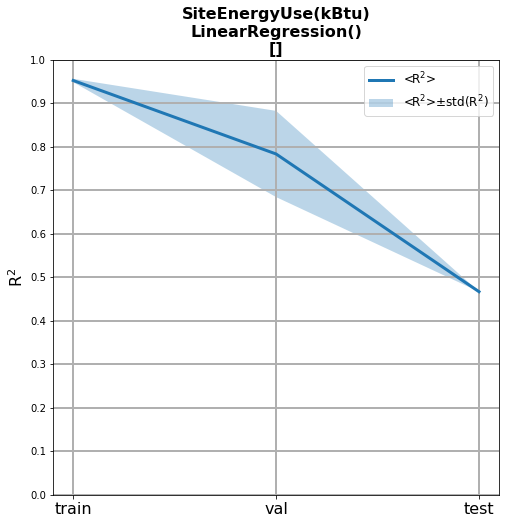

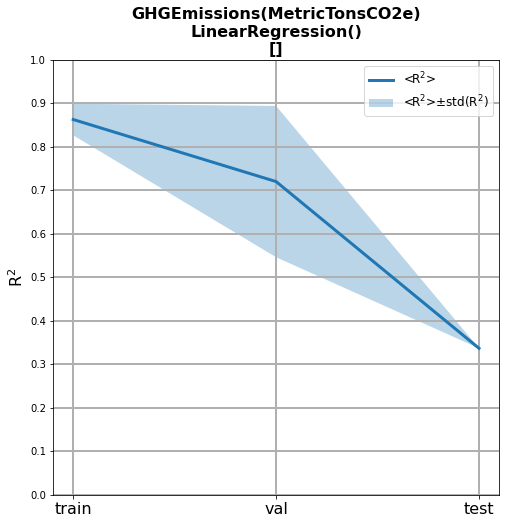

In [51]:
if Regression_lineaire_donnees_non_normalisées :
    ### Préparation à la validation croisée
    # On redéfinit ces jeux en appliquant ces indices au jeu de données normalisées
    X_train, X_test, Y_train, Y_test = X_scaled_op1.loc[indices_train], X_scaled_op1.loc[indices_test], Y_scaled_op1.loc[indices_train], Y_scaled_op1.loc[indices_test]
    # On définit tableau de paramètres de régularisation, au cas où l'on voudrait également avoir recours aux regression ridge et lasso
    tab_alpha = np.logspace(-3,3,37)
    # On définit deux listes de modèles et d'hyper-paparmètres
    tab_models, tab_dict_param = [LinearRegression()], [{}]#[LinearRegression(), Ridge(), Lasso()], [{}, {'alpha':tab_alpha}, {'alpha':tab_alpha}]
    # Par analogie avec le reste du code (où il faudra re-convertir en grandeurs physiques les prévisions basées sur les données normalisées), on prépare la liste suivante
    # composée de FunctionTransformer, où la fonction est à chaque fois la fonction identité
    tab_trans_Y_id = [FunctionTransformer(identity, inverse_func=identity).fit(Y_scaled_op1.loc[indices_train][col]) for col in Y_scaled_op1.columns]
    ### Validation croisée des modèles et optimisation des hyper-paramètres précédents.
    tab_gridcv = gridsearchcv_plusieurs_models(tab_etiquettes, X_train, Y_train, X_test, Y_test, tab_models, tab_dict_param, 5, 5)#tab_scores_train_cv, tab_scores_val_cv, tab_scores_test_cv, tab_param_cv, 
    ### Graphes
    # Comparaison des scores R² sur les jeux d'entraînement, de validation et de test
    plot_gridsearchcv_plusieurs_models_rescaled(tab_etiquettes, tab_trans_Y_id, X_train, Y_train, X_test, Y_test, tab_gridcv, 'Regression_linVSridgeVSlasso_dataQuantNonNorm', 5)
    del tab_alpha

### Analysons ce graphes :
### Pour les deux étiquettes, l'analyse globale est la même ; 0.95>=R²(train)>=0.85 caractérise un très bon apprentissage, mais la chutte dsu score dans l'ordre R²(train) > R²(val) > R²(test) (avec cette dernière valeur inférieure à 0.5) signifie qu'en l'état, ce modèle sur ces données généralise assez mal. 
### En d'autre terme : on est en situation évidente de sur-apprentissage !

### Comparons le jeu de test aux prédictions de l'algorithme (la droite noire sur les graphes ci-dessous étant le repère d'une prédiction parfaite : f(y_test) = y_test, afin de nous aider à lire le graphique) : 

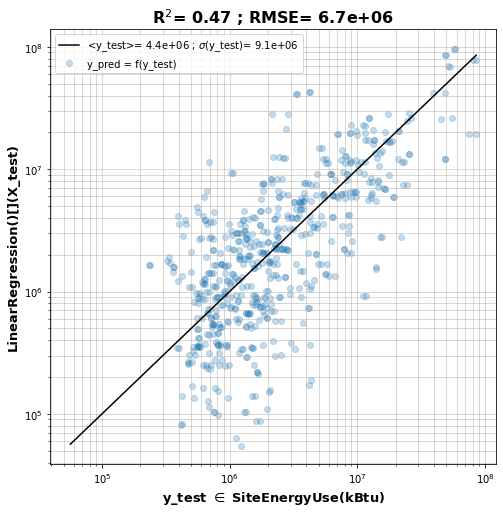

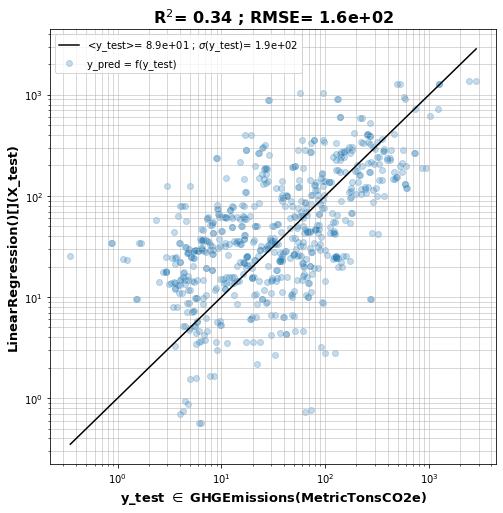

In [52]:
if Regression_lineaire_donnees_non_normalisées :    
    plot_gridsearchcv_pred_f_true_rescaled(tab_etiquettes, tab_trans_Y_id, X_train, Y_train, X_test, Y_test, tab_gridcv, 'Regression_linVSridgeVSlasso_dataQuantNonNorm')

### La raçinde l'erreur quadratique moyenne (RMSE, affichée dans le titre des graphes) est relativement élevée (particulièrement dans le cas de <i>GHEmissions</i>, où elle est presque 2 fois plus élevée que la moyenne de l'étiquette), ce qui explique les scores assez médiocres.
### Il semblerait que les erreurs les plus importantes soient faites essentiellement dans la moitié basse des étiquettes (our les deux étiquettes) et qu'au contraire, les plus fortes valeurs des étiquettes soient celles qui sont prévues avec le moins d'erreur par la régression linéaire.
### Confirmons celà en affichant l'écart-relatif absolu entre le vecteur étiquette et le vecteur prédiction, en fonction de la valeur de l'étiquette : 
### (!!! sur les graphes ci dessous, les points bleus correspondent aux points du jeu d'enytraînement, et non de test, qui eux sont affichés en orange, contrairement aux figures précédentes !!!)

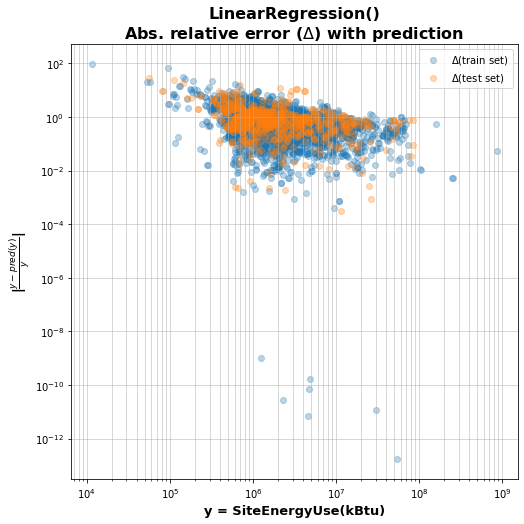

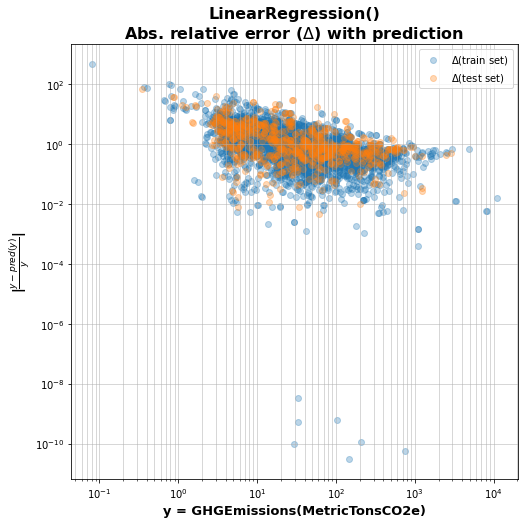

In [53]:
if Regression_lineaire_donnees_non_normalisées :
    tab_delta = plot_abs_err_rel_f_true_rescaled(tab_etiquettes, tab_trans_Y_id, X_train, Y_train, X_test, Y_test, tab_gridcv, 'Regression_linVSridgeVSlasso_dataQuantNonNorm')

### Les tendances entraprçues lors des graphes précédent sont confirmées. L'écart des scores entre train_set et test_set s'explique également du fait d'un nombre de point reproduit avec une erreur relativeabsolue de - de 0.1 ; on a même une dizaine de points par étiquettes pour lesquelles l'erreure relative st quasi nulle (inférieure à 10^-04, voire 10^-08).

### Rangement de ces modèles dans la lise qui dédiée à cette tâche, et qui permettra à la fin de la section A la comparaison entre modèles.

In [54]:
if Regression_lineaire_donnees_non_normalisées :
    tab_rangement_modeles.append([tab_trans_Y_id, X_train, Y_train, X_test, Y_test, tab_gridcv, 'Regression_linVSridgeVSlasso_dataQuantNonNorm'])

## 
## <u>A.1.b) Paramètres quantitatifs.</u>
### Une première piste naturelle, afin d'améliorer ce résultat (et en prévisions d'utilisation future d'autres types d'algorithmes très sensibles aux différences d'échelles entre les features) est de normaliser les <i>features</i> quantitatives, afin de réduire les différences d'échelles entre elles, et les comparer plus facilement les unes aux autres.

In [55]:
X_scaled_op1[feat_quant]

PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
0                88434                   0                   88434   
1                88434                   0                   88434   
2               103566               15064                   88502   
3               103566               15064                   88502   
4               961990                   0                  961990   
...                ...                 ...                     ...   
5950             12294                   0                   12294   
5951             16000                   0                   16000   
5952             13157                   0                   13157   
5953             14101                   0                   14101   
5954             18258                   0                   18258   

      LargestPropertyUseTypeGFA  SecondLargestPropertyUseTypeGFA  \
0                       88434.0                              0.0   
1                       88434.0                              0.0   
2                       83880.0                          15064.0   
3                       83880.0                          15064.0   
4                      757243.0                         100000.0   
...                         ...                              ...   
5950                    12294.0                              0.0   
5951                    16000.0                              0.0   
5952                     7583.0                           5574.0   
5953                     6601.0                           6501.0   
5954                     8271.0                           8000.0   

      ThirdLargestPropertyUseTypeGFA   Latitude   Longitude  
0                                0.0  47.612190 -122.337997  
1                                0.0  47.612200 -122.337990  
2                             4622.0  47.613106 -122.333358  
3                             4622.0  47.613170 -122.333930  
4                                0.0  47.613349 -122.337699  
...                              ...        ...         ...  
5950                             0.0  47.567220 -122.311540  
5951                             0.0  47.596250 -122.322830  
5952                             0.0  47.636440 -122.357840  
5953                           484.0  47.528320 -122.324310  
5954                          1108.0  47.539390 -122.295360  

[3979 rows x 8 columns]

### Toutes ces données exprimment des grandeurs physiques différentes, ce qui empêche une comparaison directe, entre elles comme avec celles ici des <i>features</i> qualitatives. 
### Il nous faut adpater une technique de <i>features scaling</i> à chacun de nos paramètres, en fonction des caractéristiques de leurs distributions, alors commençons par re-afficher celles-ci :

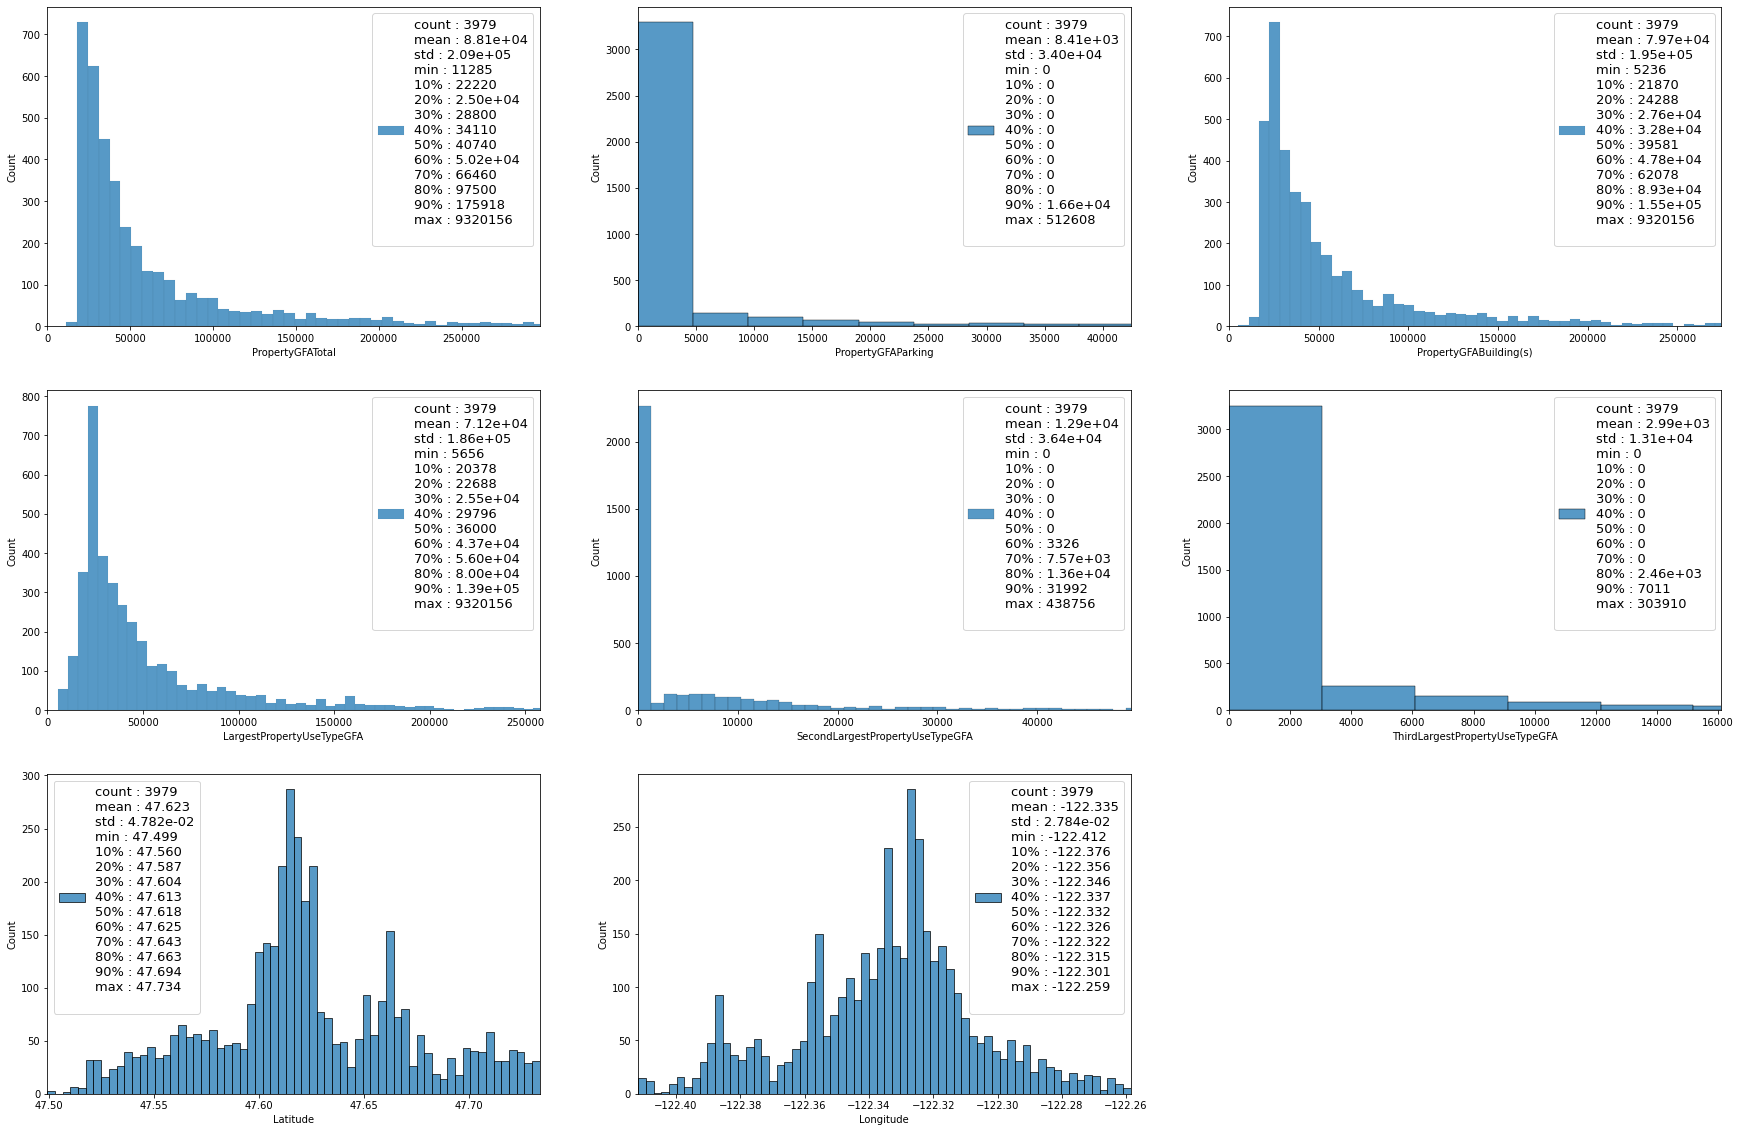

In [56]:
# Création d'une variable df (qui sera effacée à la fin de cette cellule) afin de se faciliter le travail à venir
df = X[feat_quant]
plt.figure('Distribution features quantitatifs', figsize=(30,20)), plt.clf()
for i, colonne in zip(range(1,10), df.columns):
    axe = plt.subplot(3,3,i)
    text, description = f'', dict(df[colonne].describe(percentiles=np.linspace(0.1,0.9,9)))#[0.1, 0.25, 0.5, 0.75, 0.9]))
    # on met en légende de chaque graphes une description statistique du paramètre concerné
    for clef in description:
        text += '%s : %i\n'%(clef, description[clef]) if description[clef]==int(description[clef]) else '%s : %.3e\n'%(clef, description[clef]) if abs(description[clef])<0.1 else '%s : %.2e\n'%(clef, description[clef]) if abs(description[clef])>1000 else '%s : %.3f\n'%(clef, description[clef])
    bins = int(len(df[colonne].unique())/5) if colonne in ['PropertyGFAParking','ThirdLargestPropertyUseTypeGFA'] else 'sqrt' if colonne in ['Latitude', 'Longitude'] else 'auto'#['YearBuilt','PropertyGFAParking','ThirdLargestPropertyUseTypeGFA']
    sns.histplot(df[colonne], ax=axe, kde=False, log_scale=(False, False), legend=True, label=text, bins=bins)
    if colonne in ['Latitude','Longitude'] :#['YearBuilt','Latitude','Longitude']
        axe.set_xlim([df[colonne].min(), df[colonne].max()])
    else :
        axe.set_xlim([0, df[colonne].mean()+1*df[colonne].std()])
    plt.legend(loc='best', fontsize=13)
# Effacement des variables désormais inutiles
del df, i, colonne, axe, text, description, clef

### (1) Pour ce qui est des paramètres concernant une surface (dont l'intitulé comporte le suffixe GFA), on a deux cas opposés :
- <i>PropertyGFATotal</i>, <i>PropertyGFABuilding(s)</i> et <i>LargestPropertyUseTypeGFA</i> ont des distributions avec une croissance assez rapide vers leur premier (et seul) mode, puis une décroissance relativement lente. De plus, elles ont toutes le même maximum, du fait des relations quji existent entre le 1er parmètre et chacun des deux autres. 
- <i>PropertyGFAParking</i>, <i>2ndLargestPropertyUseTypeGFA(</i> et <i>3rdLargestPropertyUseTypeGFA</i> ont des distributions particulièrement inégalement réparties où la valeur 0 est presque toujours majoritaire.

### !!!
### <u>CHOIX FORT :</u>
### Tout d'abord, du fait de leur étalement important et très inégal, avec pour conséquence régulière un écart-type très supérieur à la moyenne, on va passer toutes ces distributions à leur logarithme via la fonction log(x+1) (le +1 peremttant de conserver des grandeurs positives), ce qui devrait écraser les écarts entre les éléments, et réduire l'importance relative des valeurs les plus élevées (tout en conservant l'ordre de ces valeurs par croissance monotone de la fonction log(x+1)).
### De plus, du fait des relations entre ces paramètres (soit explicitement exprimables, soit de hierarchisation), on propose donc de normaliser toutes ces distributions par le maximum de <i>PropertyGFATotal</i>.
### !!!

In [57]:
maxabscal_X_gfa = MaxAbsScaler()
maxabscal_X_gfa.fit(np.log1p(X.loc[indices_train,'PropertyGFATotal']).values.reshape(-1, 1))
for feat in ['PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA'] :
    X_scaled_op1[feat] = maxabscal_X_gfa.transform(np.log1p(X[feat]).values.reshape(-1, 1)) 
    #X_scaled_op1.loc[indices_test,feat] = maxabscal_X_gfa.transform(np.log1p(X.loc[indices_test,feat]).values.reshape(-1, 1)) 

In [58]:
stdscal_X_latlon = StandardScaler()
stdscal_X_latlon.fit(X.loc[indices_train,['Latitude', 'Longitude']])
X_scaled_op1[['Latitude', 'Longitude']] = stdscal_X_latlon.transform(X[['Latitude', 'Longitude']])

### (3) Pour <i>Latitude</i> et <i>Longitude</i>, on voit que les distributions ont un mode principal quasiment sur leurs moyennes, qu'elles sont également à peu près symétriques vis à vis de leur moyenne, un écart-type faible en regard de celle-ci,et que -globalement- la nombre d'apparition des valeurs prises diminue à mesure qu'on s'éloigne de la moyenne.
### !!!
### <u>CHOIX FORT :</u>
### On propose donc de lui appliquer un sklearn.StandardScaler()
### !!!

### Enfin, on affiche quelques propriétés statistiques des distributions des <i>features</i> quantitatives normalisées afin de prendre la mesure des conséquences de ces opérations :

In [59]:
X_scaled_op1[feat_quant].describe(percentiles=[0.1,0.25,0.5,0.75,0.9])

PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
count       3979.000000         3979.000000             3979.000000   
mean           0.676273            0.116789                0.672495   
std            0.052978            0.244647                0.050764   
min            0.581474            0.000000                0.533628   
10%            0.623691            0.000000                0.622701   
25%            0.634632            0.000000                0.633192   
50%            0.661465            0.000000                0.659667   
75%            0.702391            0.000000                0.696655   
90%            0.752618            0.605406                0.744611   
max            1.000000            0.819262                1.000000   

       LargestPropertyUseTypeGFA  SecondLargestPropertyUseTypeGFA  \
count                3979.000000                      3979.000000   
mean                    0.665382                         0.261349   
std                     0.051419                         0.298661   
min                     0.538436                         0.000000   
10%                     0.618298                         0.000000   
25%                     0.628492                         0.000000   
50%                     0.653758                         0.000000   
75%                     0.690601                         0.575234   
90%                     0.738121                         0.646403   
max                     1.000000                         0.809568   

       ThirdLargestPropertyUseTypeGFA     Latitude    Longitude  
count                     3979.000000  3979.000000  3979.000000  
mean                         0.134446    -0.013011     0.003427  
std                          0.235998     0.996977     1.003025  
min                          0.000000    -2.593149    -2.780499  
10%                          0.000000    -1.319012    -1.499106  
25%                          0.000000    -0.511566    -0.588341  
50%                          0.000000    -0.117704     0.087179  
75%                          0.000000     0.669792     0.581339  
90%                          0.551816     1.469442     1.204725  
max                          0.786686     2.300319     2.738673

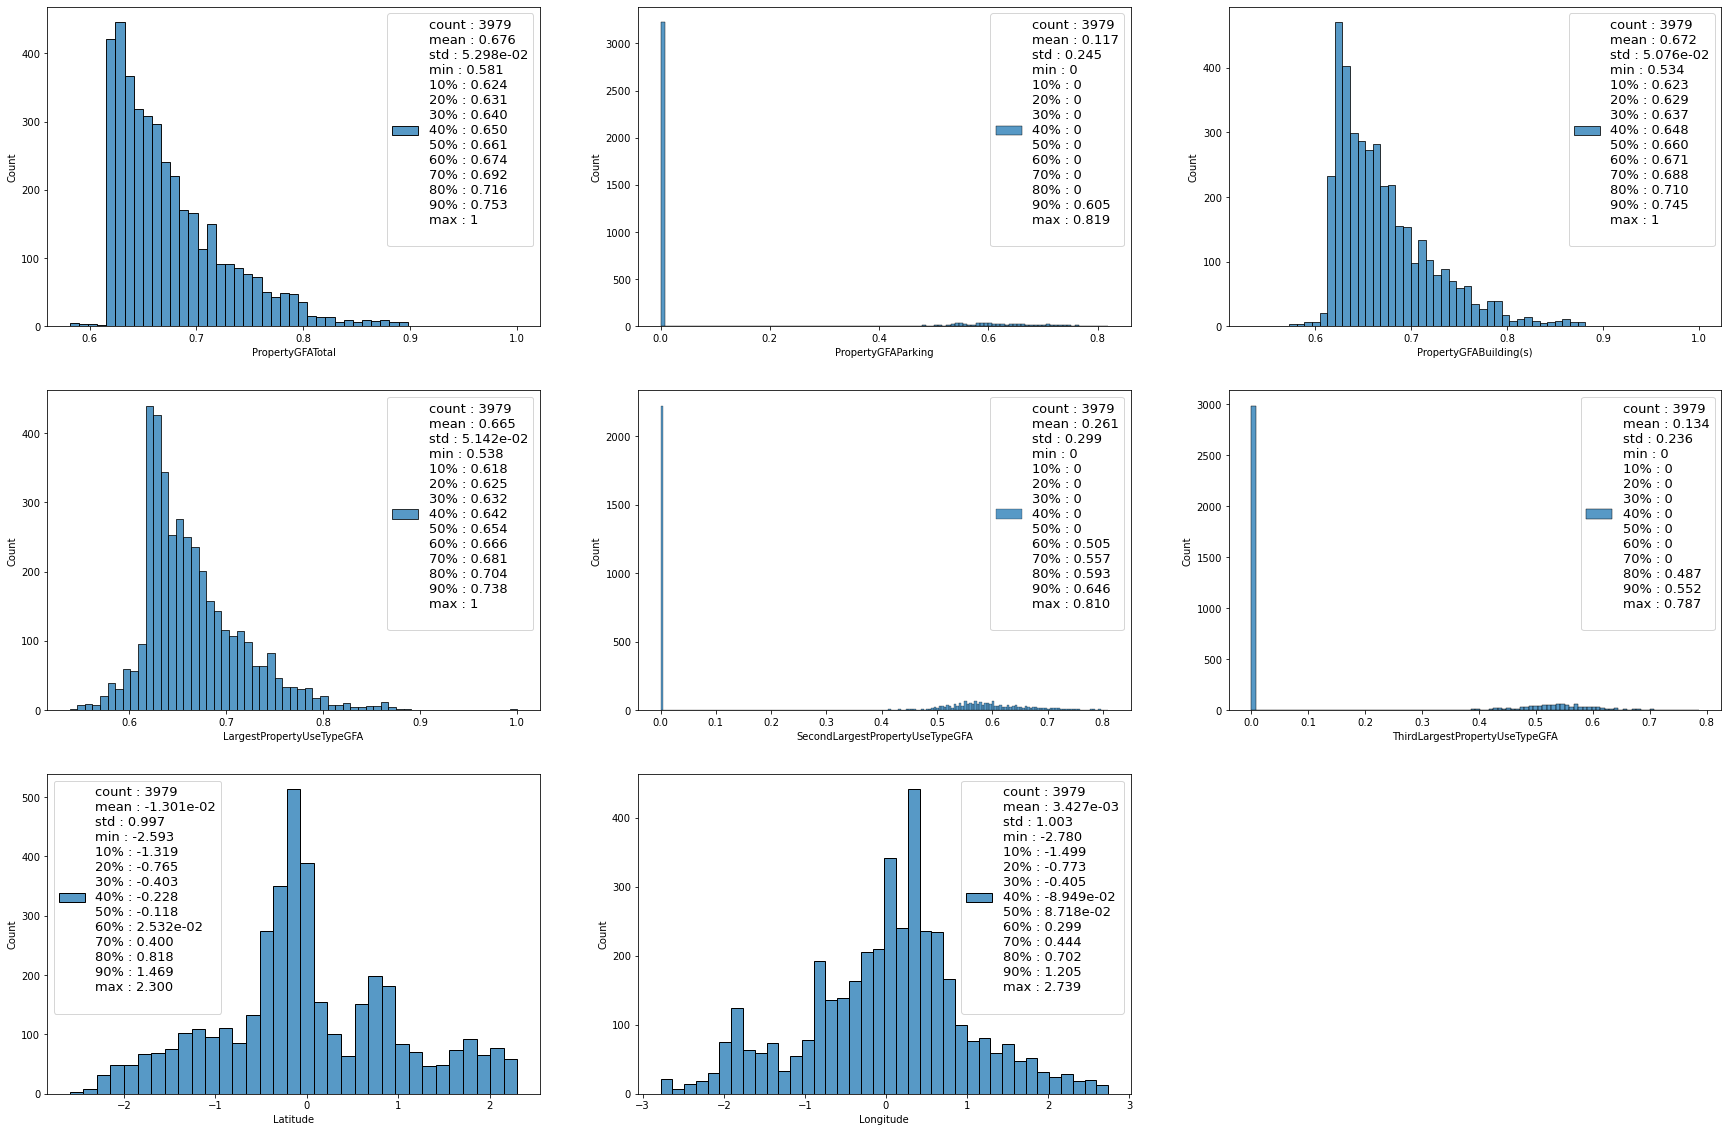

In [60]:
# Création d'une variable df (qui sera effacée à la fin de cette cellule) afin de se faciliter le travail à venir
df = X_scaled_op1[feat_quant].copy(deep=True)
plt.figure('Distribution X_scaled_op1[feat_quant]', figsize=(30,20)), plt.clf()
for i, colonne in zip(range(1,len(feat_quant)+1), df.columns):
    axe = plt.subplot(3,3,i)
    text, description = f'', dict(df[colonne].describe(percentiles=np.linspace(0.1,0.9,9)))#[0.1, 0.25, 0.5, 0.75, 0.9]))
    # on met en légende de chaque graphes une description statistique du paramètre concerné
    for clef in description:
        text += '%s : %i\n'%(clef, description[clef]) if description[clef]==int(description[clef]) else '%s : %.3e\n'%(clef, description[clef]) if abs(description[clef])<0.1 else '%s : %.2e\n'%(clef, description[clef]) if abs(description[clef])>1000 else '%s : %.3f\n'%(clef, description[clef])
    bins = int(len(df[colonne].unique())/5) if colonne in ['PropertyGFAParking','SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA'] else 'auto'
    sns.histplot(df[colonne], ax=axe, kde=False, log_scale=(False, False), legend=True, label=text, bins=bins)
    #axe.set_xlim([0, df[colonne].mean()+2*df[colonne].std()])
    plt.legend(loc='best', fontsize=13)
# Effacement des variables désormais inutiles
del df, i, colonne, axe, text, description, clef

### L'objetcif de comparaison rendue possible entre <i>features</i> (quantitatives-qualitatives et également entre quantitatives) est atteint : quasiment toutes les grandeurs sont ramenées entre 0 et 1, et celles qui ne le sont pas gardent une distribution dont le maximum en valeur absolue reste de l'ordre de grandeur de 1.
### <u>N.B :</u>
### En revanche, on peut dors et déjà critiquer notre choix d'avoir voulu conserver des traces de relations entre <i>features</i> (par exemple la hiérarchie entre surfaces) qui rend les distributions normalisées très inégales, encore mal réparties sur l'intervalle [0 ; 1], ce qui risque de diminuer les capacités des algorithmes à faire efficacement la différence entre deux éléments, les valeurs prises sur ces <i>features</i> étant parfois très peu différentes.
### De plus, notre choix pour les <i>features</i> <i>Latitude</i> et <i>Longitude</i> vont peut être eux aussi poser PB dans la comparaison aux <i>features</i> qualitatives strictement comprises entre 0 et 1 après <i>one hot encoding</i>.

## 
## <u>A.1.c) <i>Targets</i>.</u>
### Procédons de mêmes pour les <i>targets</i> : elles n'ont certes pas le besoin d'être comparées entre elles, mais il nous faut nénamoins agir sur leurs distributions très étalées (avec un écrt-type de nouveau souvent supérieur, voir très supérieur, à la moyenne) et qui possède quelques valeurs tellement hautes que celà pourrait peser négativement sur l'entraînement des algorithmes.

In [61]:
Y_scaled_op1

SiteEUI(kBtu/sf)  SiteEnergyUse(kBtu)  NaturalGas(kBtu)  \
0            78.900000         6.981428e+06      1.272388e+06   
1            81.699997         7.226362e+06      1.276453e+06   
2            94.400000         8.354235e+06      4.448985e+06   
3            94.800003         8.387933e+06      5.145082e+06   
4            96.600000         7.313066e+07      3.709900e+06   
...                ...                  ...               ...   
5950         69.099998         8.497457e+05      3.254750e+05   
5951         59.400002         9.502762e+05      5.537300e+05   
5952        438.200012         5.765898e+06      3.973739e+06   
5953         51.000000         7.194712e+05      3.706010e+05   
5954         63.099998         1.152896e+06      7.203420e+05   

      GHGEmissions(MetricTonsCO2e)  GHGEmissionsIntensity(kgCO2e/ft2)  
0                           249.43                               2.64  
1                           249.98                               2.83  
2                           263.51                               2.38  
3                           295.86                               2.86  
4                          2061.48                               1.92  
...                            ...                                ...  
5950                         20.94                               1.70  
5951                         32.17                               2.01  
5952                        223.54                              16.99  
5953                         22.11                               1.57  
5954                         41.27                               2.26  

[3979 rows x 5 columns]

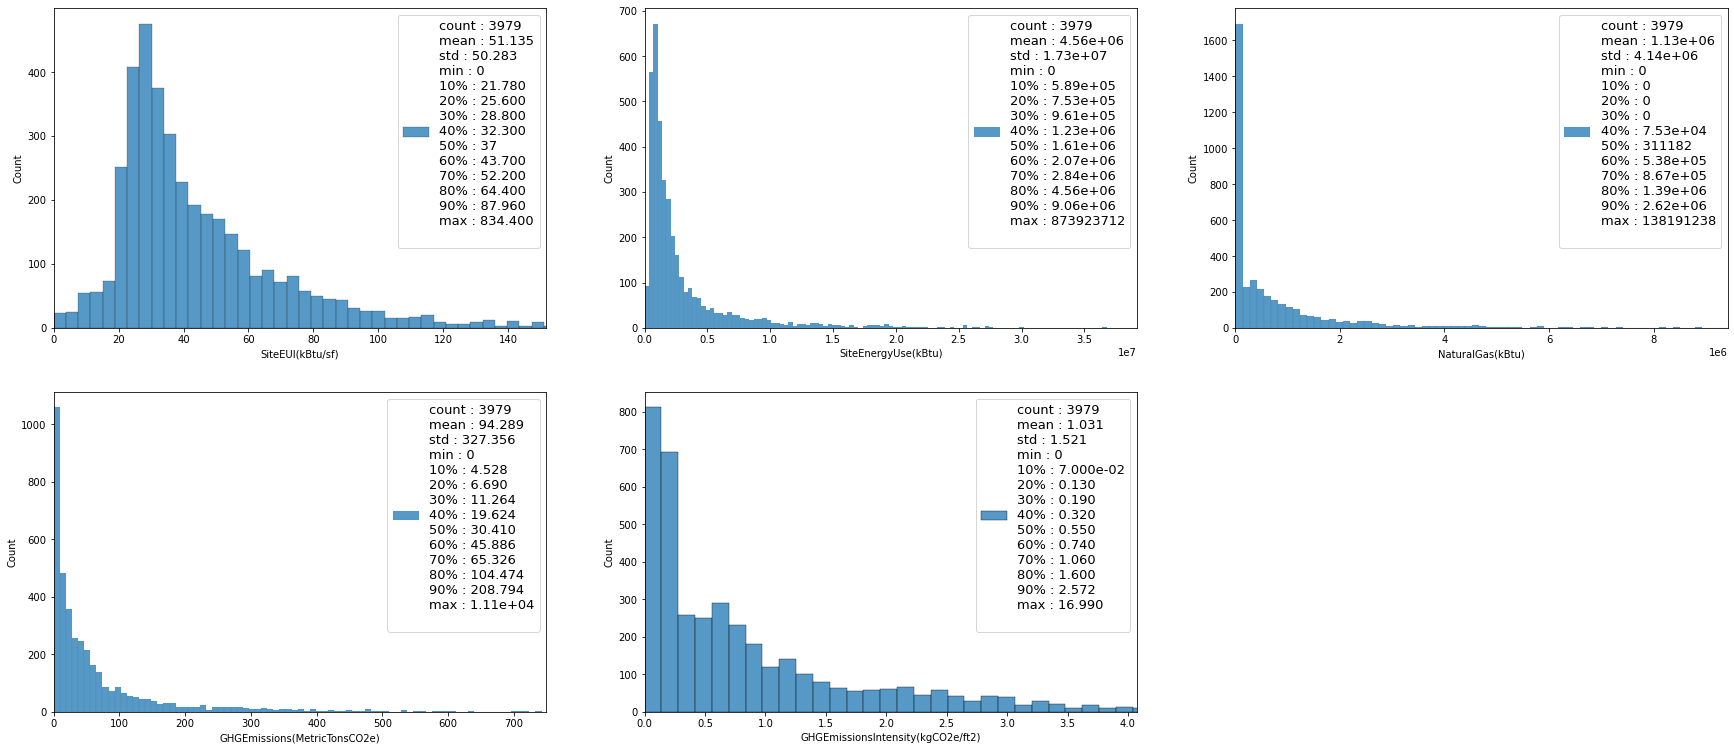

In [62]:
# Création d'une variable df (qui sera effacée à la fin de cette cellule) afin de se faciliter le travail à venir
df = Y.copy(deep=True)
plt.figure('Distribution etiquettes', figsize=(30,20)), plt.clf()
for i, colonne in zip(range(1,len(noms_Y)+1), df.columns):
    axe = plt.subplot(3,3,i)
    text, description = f'', dict(df[colonne].describe(percentiles=np.linspace(0.1,0.9,9)))#[0.1, 0.25, 0.5, 0.75, 0.9]))
    # on met en légende de chaque graphes une description statistique du paramètre concerné
    for clef in description:
        text += '%s : %i\n'%(clef, description[clef]) if description[clef]==int(description[clef]) else '%s : %.3e\n'%(clef, description[clef]) if abs(description[clef])<0.1 else '%s : %.2e\n'%(clef, description[clef]) if abs(description[clef])>1000 else '%s : %.3f\n'%(clef, description[clef])
    bins = int(len(df[colonne].unique())/5) if colonne in ['SteamUse(kBtu)'] else 'auto'
    sns.histplot(df[colonne], ax=axe, kde=False, log_scale=(False, False), legend=True, label=text, bins=bins)
    if colonne in ['SteamUse(kBtu)'] :
        axe.set_xlim([df[colonne].min(), df[colonne].max()])
    else :
        axe.set_xlim([0, df[colonne].mean()+2*df[colonne].std()])
    plt.legend(loc='best', fontsize=13)
# Effacement des variables désormais inutiles
del df, i, colonne, axe, text, description, clef

### On peut ainsi passer toutes ces <i>targets</i> à leur logarithme (via la fonction log(x+1)) afin de réduire cet étalement :

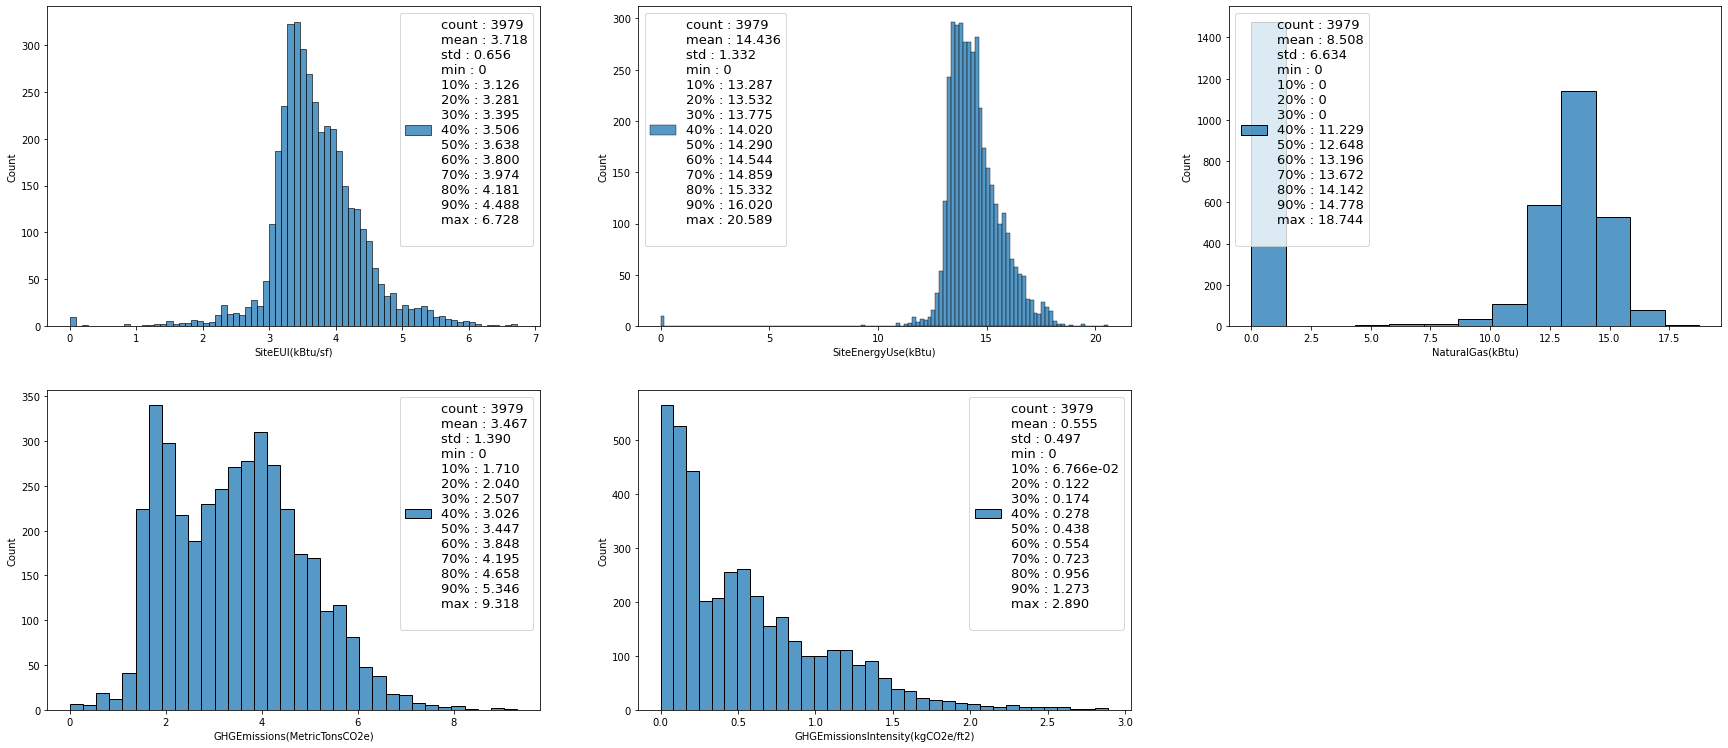

In [63]:
# Création d'une variable df (qui sera effacée à la fin de cette cellule) afin de se faciliter le travail à venir
df = np.log1p(Y).copy(deep=True)
plt.figure('Distribution log(etiquettes+1)', figsize=(30,20)), plt.clf()
for i, colonne in zip(range(1,len(noms_Y)+1), df.columns):
    axe = plt.subplot(3,3,i)
    text, description = f'', dict(df[colonne].describe(percentiles=np.linspace(0.1,0.9,9)))#[0.1, 0.25, 0.5, 0.75, 0.9]))
    # on met en légende de chaque graphes une description statistique du paramètre concerné
    for clef in description:
        text += '%s : %i\n'%(clef, description[clef]) if description[clef]==int(description[clef]) else '%s : %.3e\n'%(clef, description[clef]) if abs(description[clef])<0.1 else '%s : %.2e\n'%(clef, description[clef]) if abs(description[clef])>1000 else '%s : %.3f\n'%(clef, description[clef])
    bins = int(len(df[colonne].unique())/5) if colonne in ['SteamUse(kBtu)'] else 'auto'
    sns.histplot(df[colonne], ax=axe, kde=False, log_scale=(False, False), legend=True, label=text, bins=bins)
    #axe.set_xlim([0, df[colonne].mean()+2*df[colonne].std()])
    plt.legend(loc='best', fontsize=13)
# Effacement des variables désormais inutiles
del df, i, colonne, axe, text, description, clef

### Enfin, créons une liste de ces transformateurs par étiquette (même si ici il s'agit systématiquement du même transformateur) afin de pouvoir systématiser le processus à venir de passage inverse de l'espace des étiquettes standardisées à l'espace initiale des étiquettes exprimées comme des grandeurs physiques. En effet, et on le verra au cours de ce Notebook, on a fait le choix :
### - d'entraîner les algorithmes sur les <i>features</i> et <i>targets</i> adimensionnées ,
### - mais d'évaluer les performances des algorithmes par confrontations entre prédictions et étiquettes originales.
### Ci-dessous, on affiche les propriétés statistiques des distributions des étiquettes désormais adimensionnées :

In [64]:
tab_trans_Y = []
for col in noms_Y :
    # On définiot pour chaque étiquette une fonction de transformation (en l'occurrence, le passage au log1p debvrait pour l'instant suffire)
    func_trans_y = FunctionTransformer(np.log1p, inverse_func=np.expm1)
    # On entraîne cette transformation sur le jeu d'netraînement
    func_trans_y.fit(Y[col].loc[indices_train])
    # On transforme l'intégralité des points de cette étqiuette
    Y_scaled_op1[col] = func_trans_y.transform(Y[col])
    # On stocke lafonction de transformation en respectant l'ordre des étqiuettes
    tab_trans_Y.append(func_trans_y)
# On transforme la liste en tableau
tab_trans_Y = np.array(tab_trans_Y)
# On décrit les étiquettes transformées
Y_scaled_op1.describe(percentiles=np.linspace(0.1,0.9,9))

SiteEUI(kBtu/sf)  SiteEnergyUse(kBtu)  NaturalGas(kBtu)  \
count       3979.000000          3979.000000       3979.000000   
mean           3.718483            14.435978          8.508027   
std            0.656120             1.332478          6.633954   
min            0.000000             0.000000          0.000000   
10%            3.125881            13.287028          0.000000   
20%            3.280911            13.531920          0.000000   
30%            3.394508            13.775489          0.000000   
40%            3.505557            14.019841         11.229450   
50%            3.637586            14.290485         12.648136   
60%            3.799974            14.543678         13.196263   
70%            3.974058            14.859108         13.672465   
80%            4.180522            15.332101         14.141705   
90%            4.488186            16.019838         14.777970   
max            6.727911            20.588504         18.744149   

       GHGEmissions(MetricTonsCO2e)  GHGEmissionsIntensity(kgCO2e/ft2)  
count                   3979.000000                        3979.000000  
mean                       3.467063                           0.555355  
std                        1.389652                           0.496824  
min                        0.000000                           0.000000  
10%                        1.709826                           0.067659  
20%                        2.039921                           0.122218  
30%                        2.506668                           0.173953  
40%                        3.026455                           0.277632  
50%                        3.447126                           0.438255  
60%                        3.847719                           0.553885  
70%                        4.194582                           0.722706  
80%                        4.658464                           0.955511  
90%                        5.346126                           1.273125  
max                        9.318438                           2.889816

### Objetcif atteint : la dispersion de ces distribution est bien moins grande, au point que moyenne et médiane coïncide presque toujours.

# 
# On peut désormais attaquer la mise en place d'algorithmes. 
# 
## <u>A.2) Application de la régression linéaire.</u>
###  Commençons simplement par traiter ce problème de régression sous l'angle de la linéarité, la régression linéaire et ses variantes avec régularisation (ridge et lasso) produisant des résultats assez faciles à interpréter.
### 
### <u>A.2.a) Régression linéaire classique, Ridge, et Lasso.</u>
### Maintenant que l'on a transformé toutes ces données hétérogènes en séries de grandeurs scalaires plus ou moins cromprise entre 0 et 1, la régression linéaire appliquée telle quelle sur ces <i>features</i> normalisées peut donner lieu à une analyse de ses performances comparées à celles des régresisons linéaires à contraites sur les coeeficient (Ridge et Lasso).

### On affiche ci-dessous les scores d'entraînement, de validation, et de test (pour chaque étiquette, et chaque type de modèle issu de la régression linéaire). Ces scores sont optenus après validation croisée (le cas échéant, le paramètre de régularisation optimisé est mentionné dans le titre du graphe).

In [65]:
if Regression_lineaire_donnees_normalisées :
    # On redéfinit ces jeux en appliquant ces indices au jeu de données normalisées
    X_train, X_test, Y_train, Y_test = X_scaled_op1.loc[indices_train], X_scaled_op1.loc[indices_test], Y_scaled_op1.loc[indices_train], Y_scaled_op1.loc[indices_test]
    tab_alpha = np.logspace(-5,1,37)
    tab_models, tab_dict_param = [LinearRegression(), Ridge(), Lasso()], [{}, {'alpha':tab_alpha}, {'alpha':tab_alpha}]
    #tab_scores_train_cv, tab_scores_val_cv, tab_scores_test_cv, tab_param_cv, tab_gridcv = gridsearchcv_plusieurs_models(tab_etiquettes, X_train, Y_train, X_test, Y_test, tab_models, tab_dict_param, 5, 5)
    tab_gridcv = gridsearchcv_plusieurs_models(tab_etiquettes, X_train, Y_train, X_test, Y_test, tab_models, tab_dict_param, 5, 5)

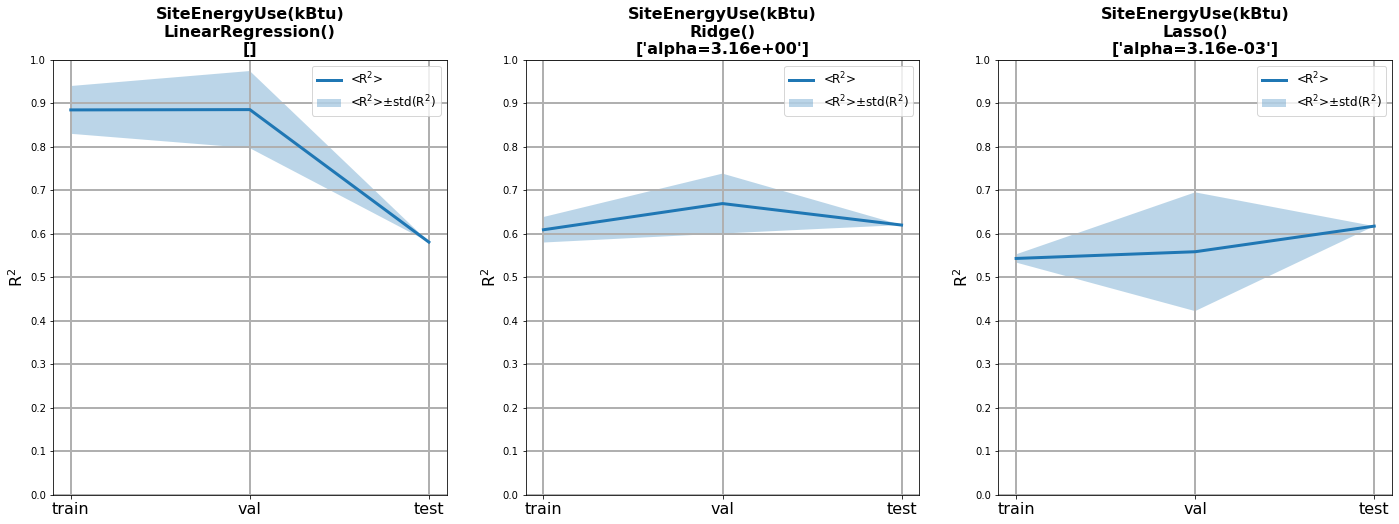

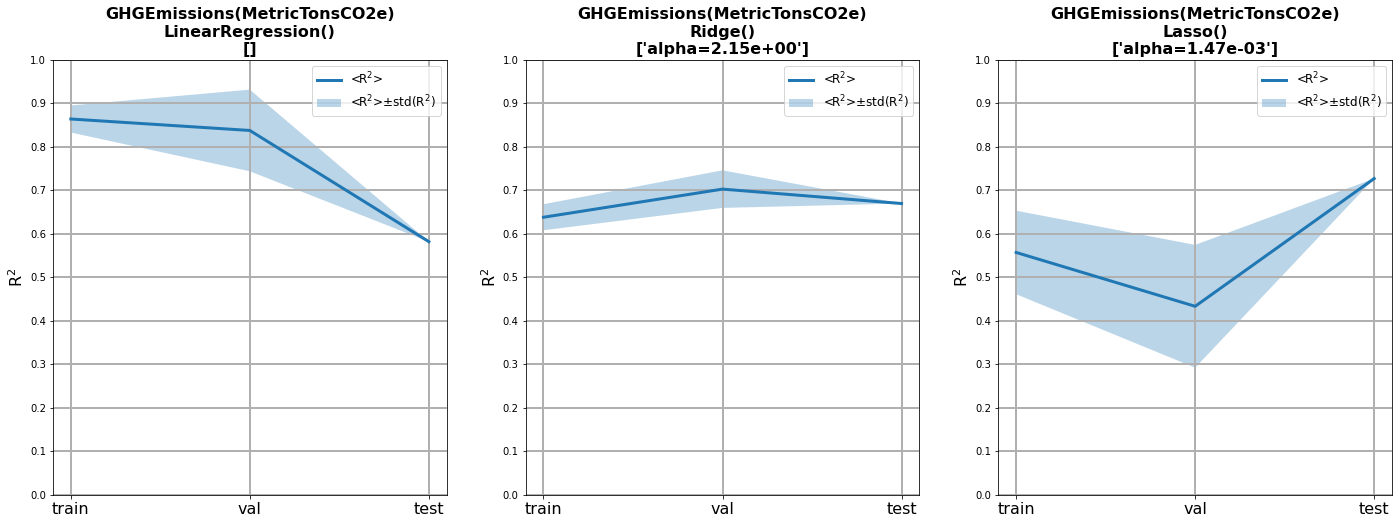

In [66]:
if Regression_lineaire_donnees_normalisées :
    plot_gridsearchcv_plusieurs_models_rescaled(tab_etiquettes, tab_trans_Y, X_train, Y_train, X_test, Y_test, tab_gridcv, 'Regression_linVSridgeVSlasso_dataQuantNorm', 5)

### Pour la régression linéaire classique, la normalisation de l'ensemble des données quantitatives et des étiquettes a semble-t-il permis une amélioration significative du score R² sur le jeu de test (~+0.1 pour <i>SiteEnergyUse</i>, jusqu'à ~+0.2 pour <i>GHEmissions</i> !), mais le sur-apprentissage de l'algorithme n'est vraiment diminué que pour la seconde étiquette.
### A propos de sur-apprentissage, c'est là tous l'intérêt des régularisations offertes par les régression Ridge et Lasso : en plus de fournir un R²(test) meilleur que celui de la régression linéaire classique (particulièrement dans le cas de <i>GHEmissions</i>), les différences de R² avec les jeux d'entraînement et de validation sont bien moins importantes que lorsque les données numériques étaient exprimées en grandeurs physiques. 
### Enfin, on note également que le R²(test) est anormalement plus élevé que R²(train) dans le cas de la régression Lasso pour prédire <i>GHEmissions</i> ! Peut-on l'expliquer facilement ? C'est peut être une conséquence des différences entre <i>train set</i> et <i>test set</i>, particulièrement en terme de catégories présentes dans le premier mais pas dans l'autre...
# 
### Affichons donc les prédictions en fonction de y_test pour chaque algo et chaque étiquette :

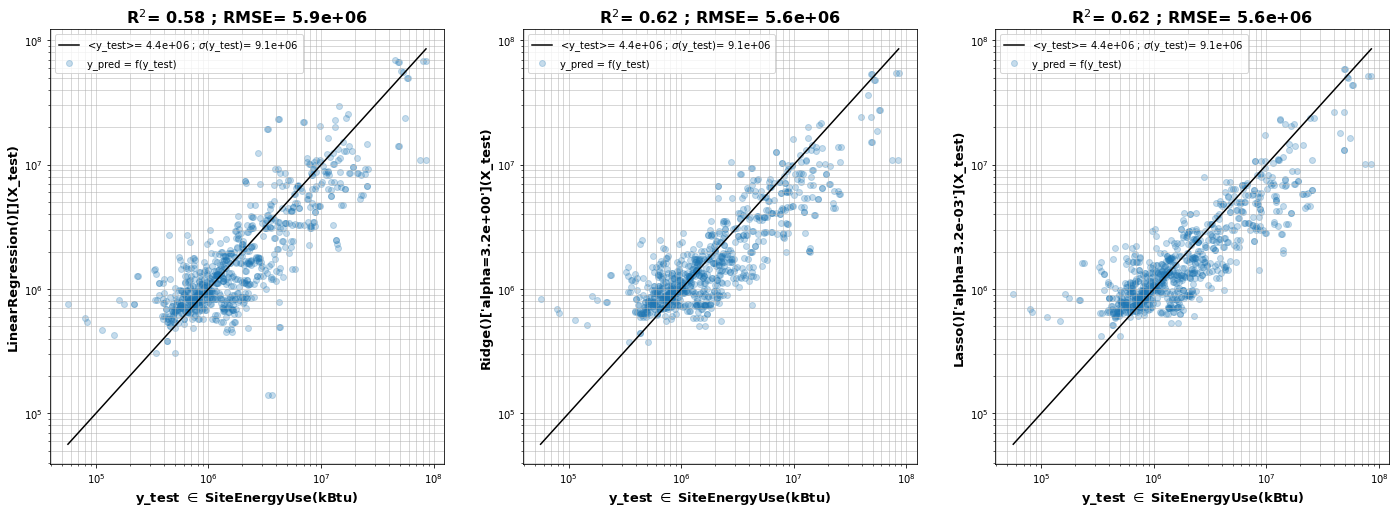

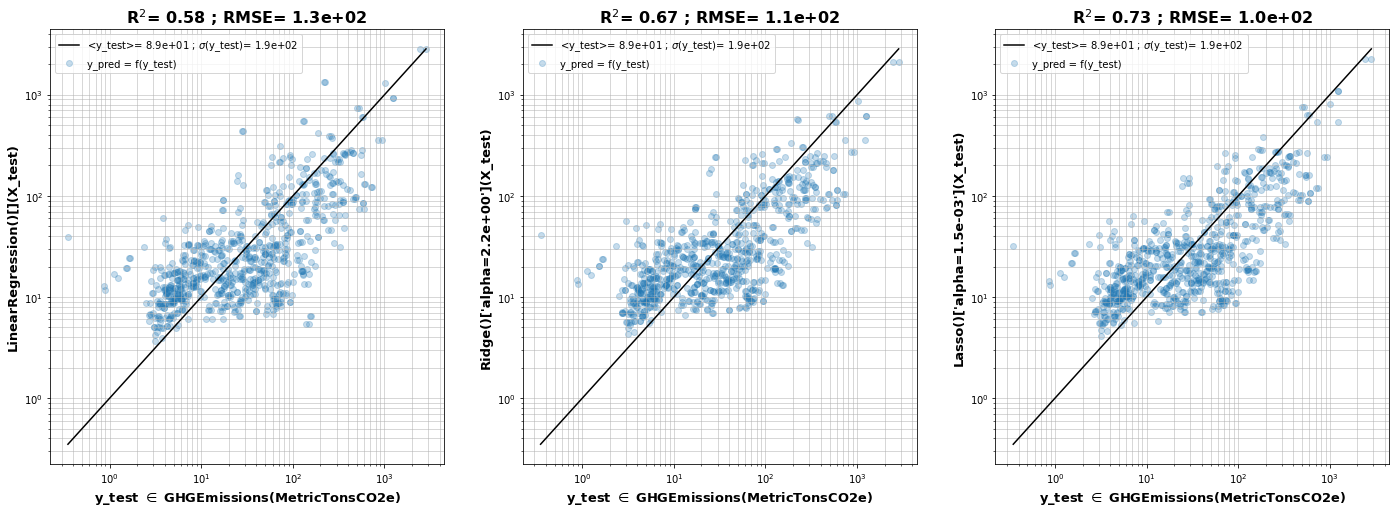

In [67]:
if Regression_lineaire_donnees_normalisées :
    # On redéfinit ces jeux en appliquant ces indices au jeu de données normalisées
    X_train, X_test, Y_train, Y_test = X_scaled_op1.loc[indices_train], X_scaled_op1.loc[indices_test], Y_scaled_op1.loc[indices_train], Y_scaled_op1.loc[indices_test]
    plot_gridsearchcv_pred_f_true_rescaled(tab_etiquettes, tab_trans_Y, X_train, Y_train, X_test, Y_test, tab_gridcv, 'Regression_linVSridgeVSlasso_dataQuantNorm')

### Les nuages de points sont moins étalés et plus proches de la droite identité, ce qui traduit bien une amélioration du R²(test).
### En revanche, comme le confirme le titre des sous-graphes dans le cas de la régression linéaire classique, certains points donnent lieu à des erreurs tellement grandes qu'elles dépassent le maximum calculable par python lors de la reconversion des prédictions en grandeurs physiques.
### Commençons à chercher les indices correspondants à ces éléments du test set :

In [68]:
if Regression_lineaire_donnees_normalisées :
    tab_indx_valeurs_infs = []
    for etiquette in tab_etiquettes :
        ind_eti = tab_etiquettes.index(etiquette)
        predictions = tab_trans_Y[ind_eti].inverse_transform(tab_gridcv[ind_eti,0].best_estimator_.predict(X_test))
        tab_indx_valeurs_infs.append(indices_test[list(np.argwhere(predictions==np.inf).reshape(-1))])
    tab_indx_valeurs_infs    

### Première remaqrue : ce sont donc les mêmes 5 éléments pour les deux étiquettes : affichons les valeurs qu'ils prennent pour chaque features :

In [69]:
if Regression_lineaire_donnees_normalisées :
    X.loc[tab_indx_valeurs_infs[0]]

### Tout d'abord, on se rend en compte - grâce aux indices et à la proximité des valeurs de certaines lignes - qu'il s'agit en réalité de 3 batiment différents, dont deux sont présents en 2015 et 2016 (les deux 1er et les deux derniers).
### Malheureusement pour nous, il ne semble pas y avoir d'information assez singulière ni commune aux trois batiments qui permettrait d'expliquer très simplement pourquoi ils conduisent à des valeurs à ce point élevées. <i>A priori</i>, c'est : 
### - soit que les valeurs des <i>features</i> quantitativess qui sont très anormales vis à vis des distributions de ces <i>features</i> quantitatives ;
### - soit que les catégories prises par ses points pour certains <i>features</i> qualitatives sont très peu fréquentes, et donc correspondent aux limites de l'entraînement de l'algorithme.
### Pour tenter d'y voir plus clair, affichons les coefficients linéaires déterminés par les 3 types de régression et pour chaque <i>feature</i> normalisée. Peut être verra t'on des coeffcients particulièrement élevés/bas correspondre à des propriétés particulières de ces 3 bâtiments.
### <b>(<u>NB :</u>sur le graphes suivants, les points rouges correspondent aux coefficients rigoureusement nuls, ce qui se produit presque exclusivement dans le cas du Lasso) :</b>

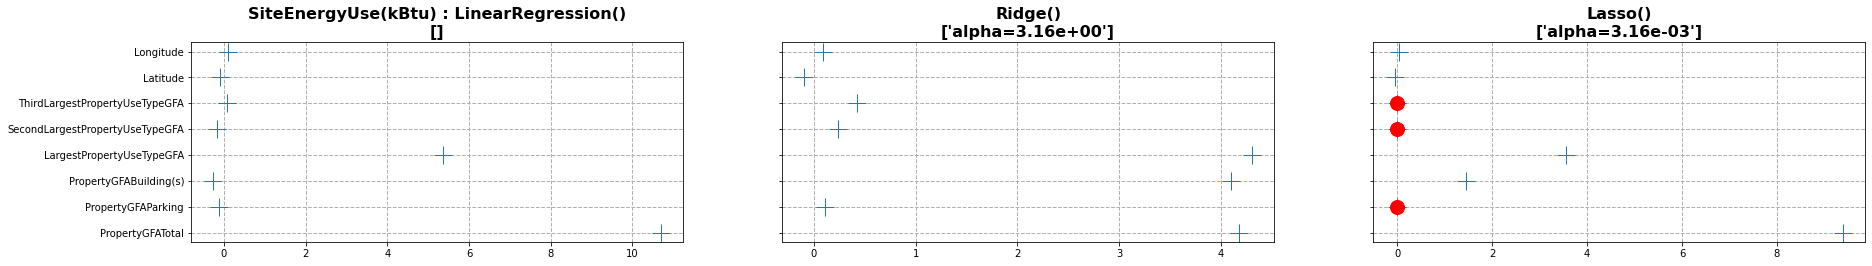

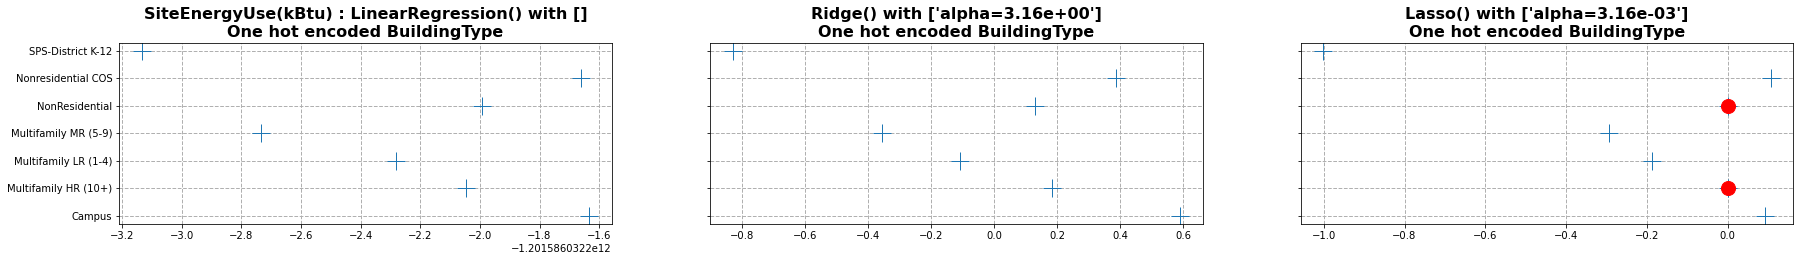

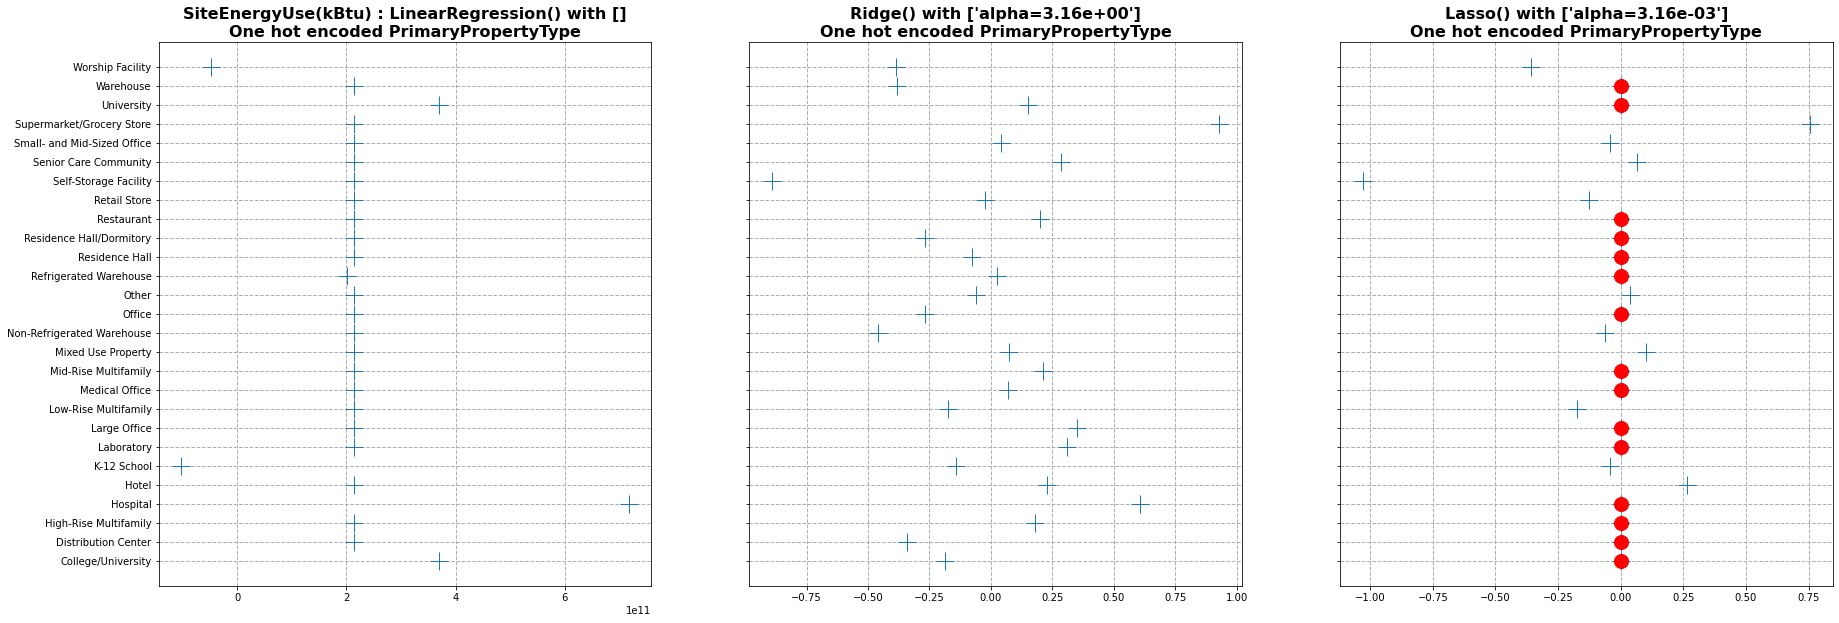

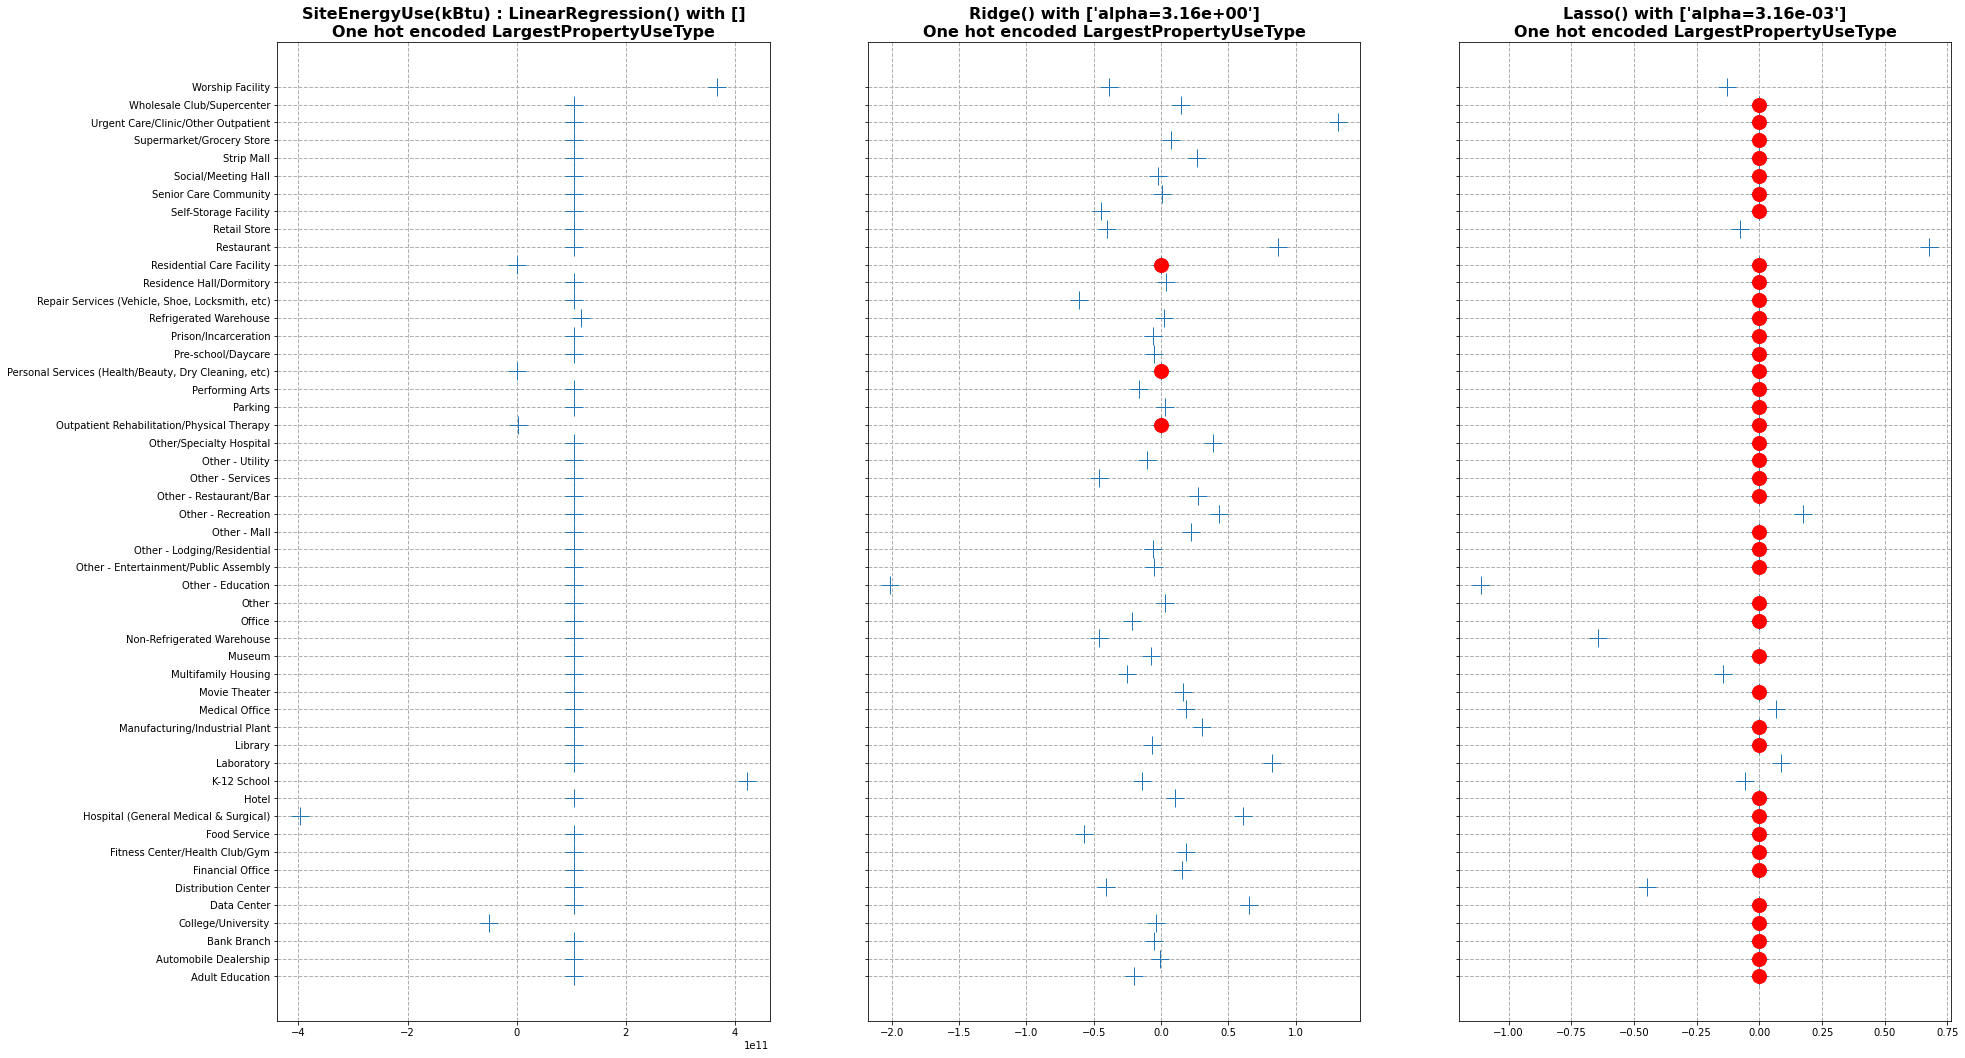

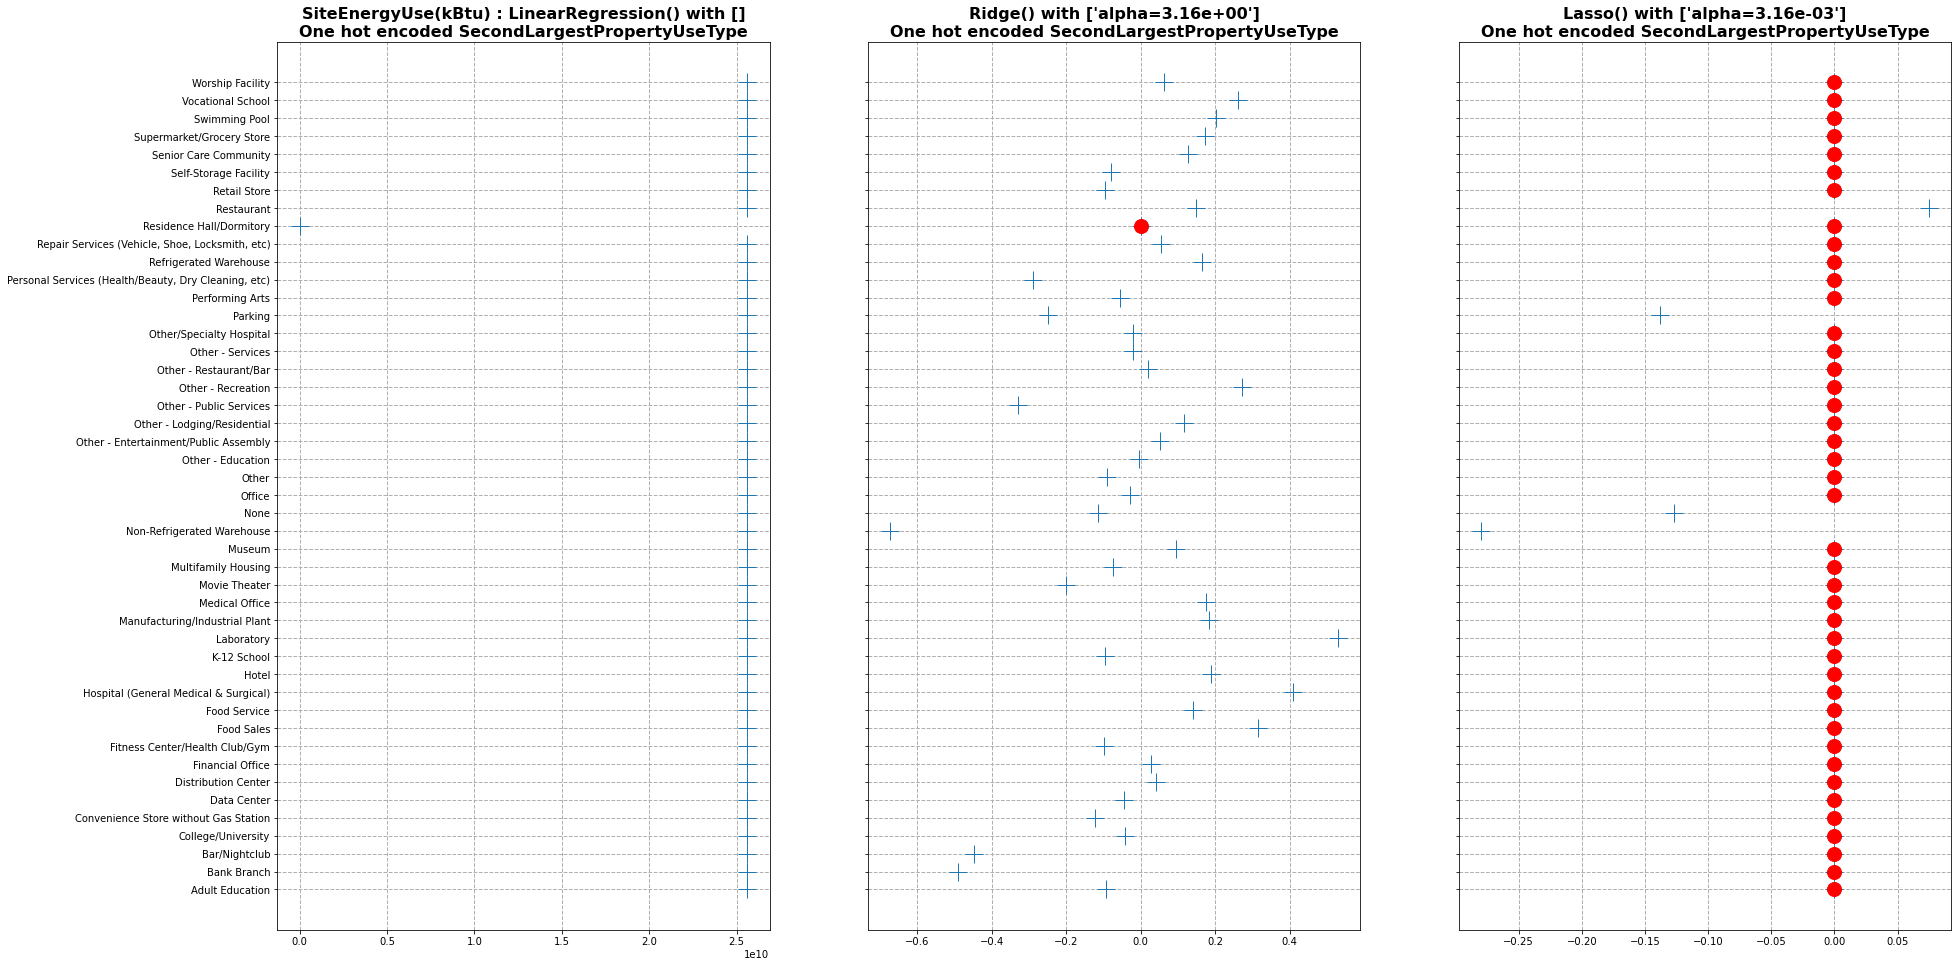

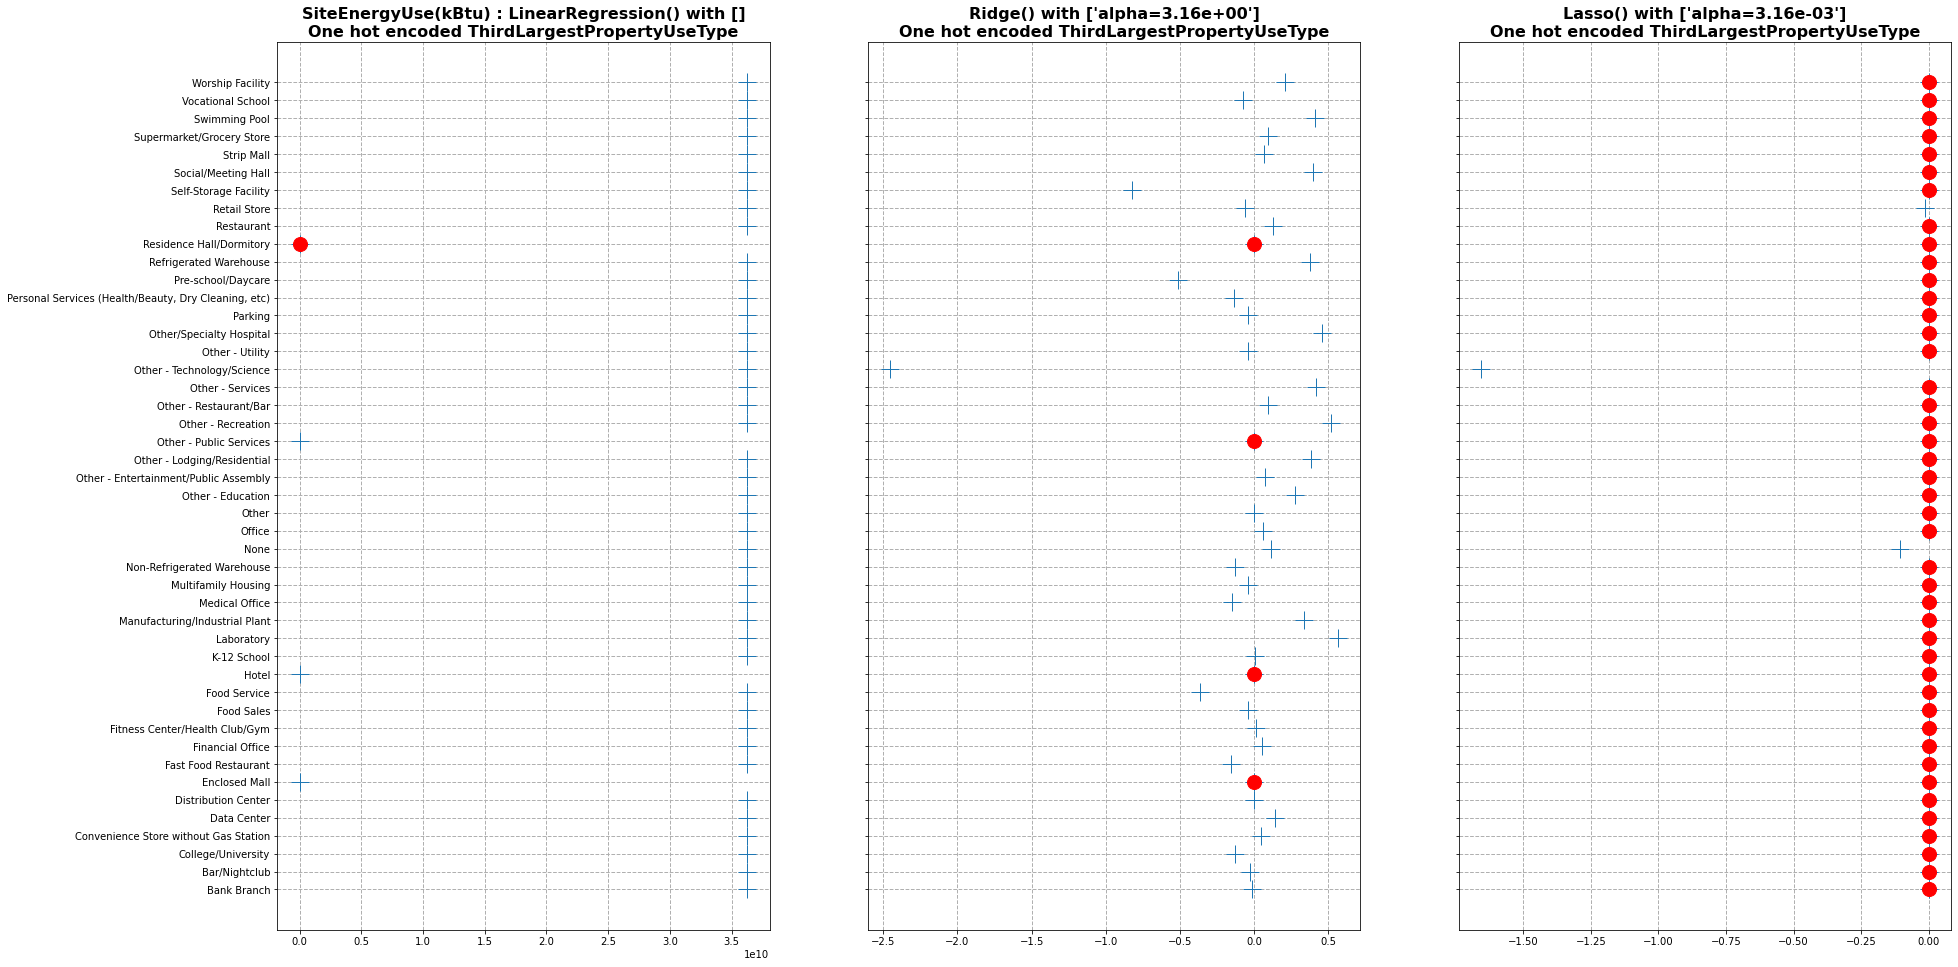

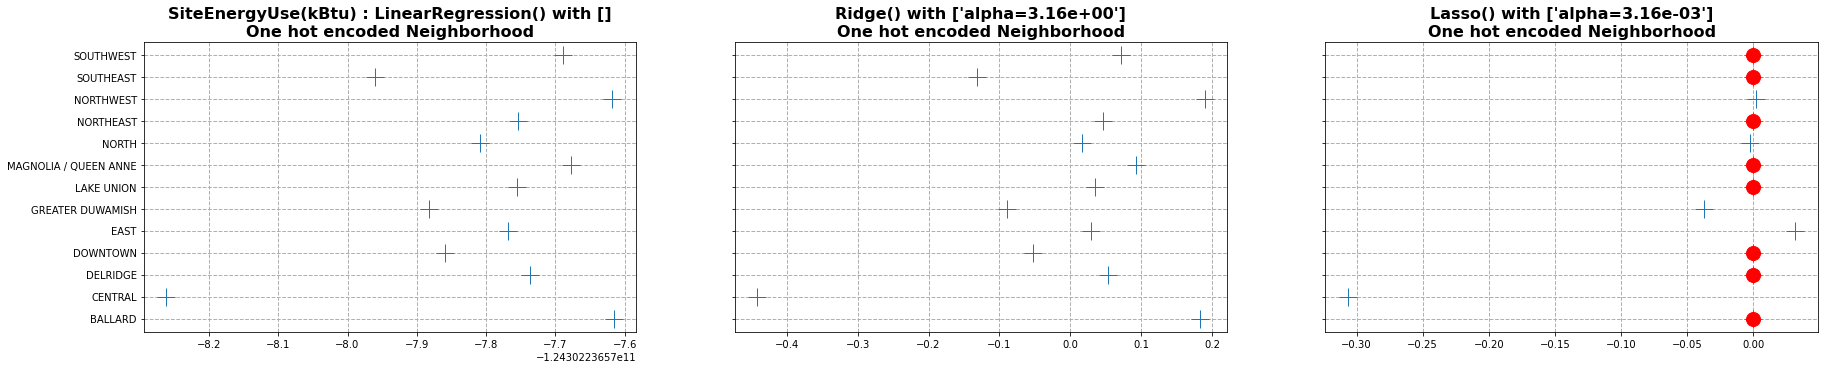

In [70]:
if Regression_lineaire_donnees_normalisées :
    plot_gridsearchcv_coeff_reglin(['SiteEnergyUse(kBtu)'], tab_gridcv, feat_quant, feat_quali, X_scaled_op1, 'Regression_linVSridgeVSlasso_dataQuantNorm')#

### Pour ce qui est des catégories des <i>features</i> qualitatives, aucune de celles prises par les 5 éléments précédents ne correspond à des coefficients linéaires particulièrement forts. 
### Pour ce qui est des <i>features</i> quantitatives, seule <i>PropertyTotalGFA</i> a un coefficent linéaire particulièrement nettement plus élevé que les autres. Regardons à quel point la distribution de <i>PropertyTotalGFA</i> pour ces éléments est différente de la distribution totale. 
### Pour générer cette information, on a recours à la fonction <i>plot_abs_err_rel_f_true_rescaled</i>, qui produit également des graphes affichant l'erreur relative absolue commise lors de la prédiction en fonction de la valeur originale des éléments du <i>train set</i> <b>(points bleus)</b> et du <i>test set</i> <b>(points oranges)</b> :

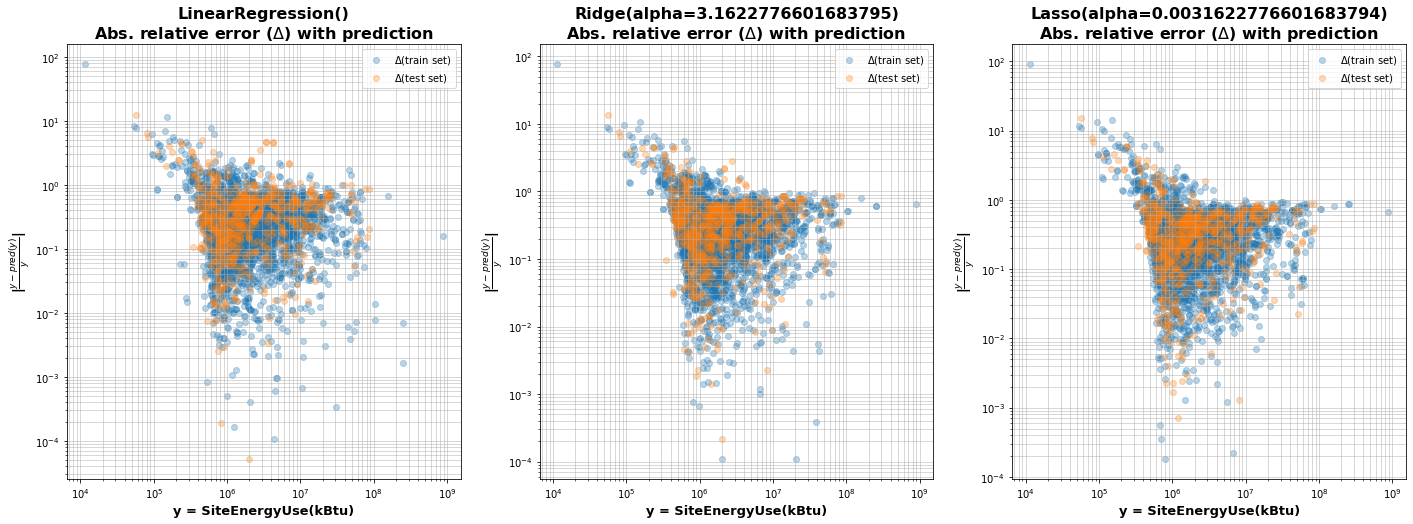

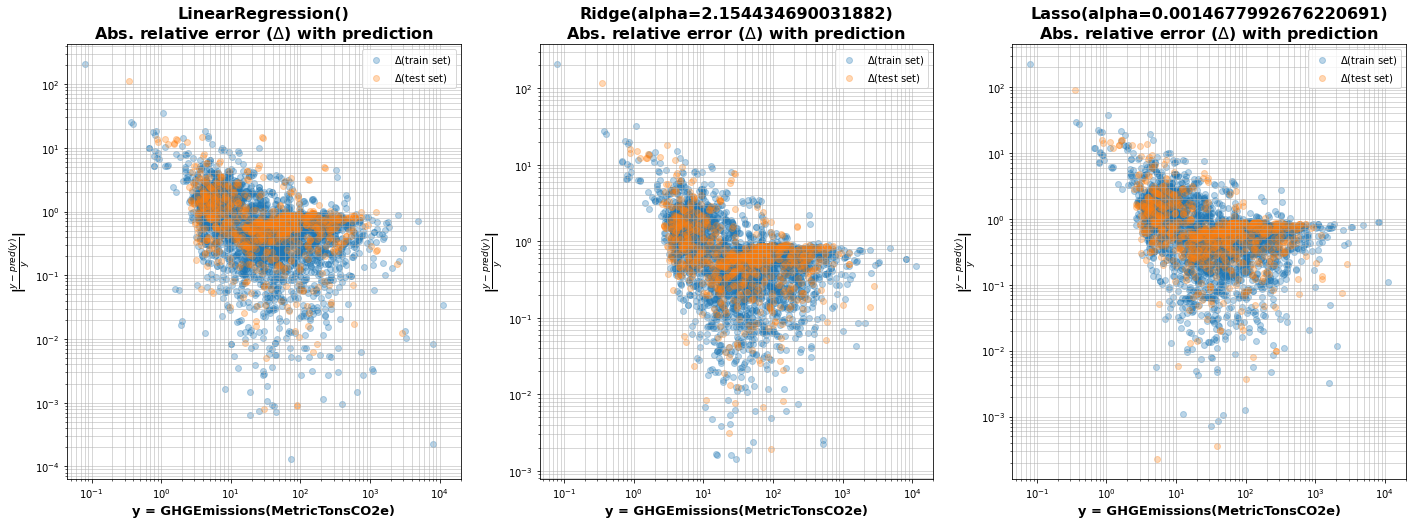

In [71]:
if Regression_lineaire_donnees_normalisées :
    Ouverture_figure = False
    tab_delta = plot_abs_err_rel_f_true_rescaled(tab_etiquettes, tab_trans_Y, X_train, Y_train, X_test, Y_test, tab_gridcv, 'Regression_linVSridgeVSlasso_dataQuantNorm')

### Ces graphes nous apprennent que les pires erreurs sont commises en majorités pour les éléments situés dans l'aile basse de la distribution, quand au contraire, plus on se déplace vers les fortes valeurs, plus l'erreur relative commise tend à être bornée par 1 (ce qui en soit est déjà beaucoup).
### Ci dessous : grâce aux calculs effectués par la fonction précédente, on affiche ci-dessous (via la fonction <i>print_df_extreme_error</i>) les propriétés statistiques des éléments conduisants aux 5 pires erreurs commises (en écarts relatifs) lors des prédictions sur le jeu de test.
### <b>!!! On précise que ces propriétés (moyenne, écart-type, médianne pour les <i>features</i> quantitatives ; nombre de catégories uniques, catégorie la plus fréquente et fréquence de celle-ci pour les <i>features</i> qualitatives) sont exprimées en fonction des propriétés similaires pour l'ensemble des élément du jeu de données. Par exemple : mean/mean(X) signigie rapport de la moyenne des 5 éléments particuliers sur la moyenne de l'ensemble des éléments de X.</b>

In [72]:
if Regression_lineaire_donnees_normalisées:
    print_df_extreme_error([tab_etiquettes[0]], np.array(tab_gridcv[0,0]).reshape((1,1)), tab_delta[0,0].reshape((1,1,2)), X, feat_quant, feat_quali, 'worst', 'test', 5)

Pour l`étiquette  SiteEnergyUse(kBtu)  :

	Pour le modèle  LinearRegression()  :

		Delta pour les features quantitatifs :
              PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
mean/mean(X)          0.286272                 0.0                0.316451   
std/std(X)            0.017625                 0.0                0.018910   
50%/50%(X)            0.579185                 NaN                0.596145   

              LargestPropertyUseTypeGFA  SecondLargestPropertyUseTypeGFA  \
mean/mean(X)                   0.313292                          0.22545   
std/std(X)                     0.012085                          0.16020   
50%/50%(X)                     0.640000                              NaN   

              ThirdLargestPropertyUseTypeGFA  Latitude  Longitude  
mean/mean(X)                             0.0  0.999788   0.999874  
std/std(X)                               0.0  0.060347   0.701907  
50%/50%(X)                               NaN  0.999916 

### Ce n'est pas concluant : au contraire, ces 5 éléments se situent dans la moitié basse de la distribution (cf rapport des moyennes et des médianes) pour PropertyTotalGFA (comme pour tous les features quantitatifs relatifs à une surface), cela ne peut donc pas constituer l'explication de ces valeurs fortes...
### Cependant, une partie de l'explication repose bien sur l'amplitude des coefficients linéaires, car pour la Ridge et le Lasso, dont la régularisation limite fortement l'amplitude, on n'a pas ce PB de valeurs qui explosent.
### De plus puisque l'on constate que la plupart des coefficient sont mis à 0 par le Lasso, cela nous fait nous questionner sur la pertinence de toutes ces features...
### !!!
### <u>CHOIX FORT :</u> Tentons par ailleurs d'appliquer la regression linéaire en laissant de côté tous les features avec un coefficient mis à zéros par la regression lasso.
### !!!!
### (On prend juste le temps de stocker nos résultats dans le tableau tab_rangements_modeles avant de passer à cette nouvelle étapes).

In [73]:
if Regression_lineaire_donnees_normalisées :
    tab_rangement_modeles.append([tab_trans_Y, X_train, Y_train, X_test, Y_test, tab_gridcv, 'Regression_linVSridgeVSlasso_dataQuantNorm'])

# 
### <u>A.2.c) Régression linéaire en délaissant les features mis à 0 par le Lasso.</u>
### Comme annoncé ci dessus, on va réduire la liste des <i>features</i>mis en entrée de la régression linéaire à ceux pour lesquels les coefficients linéaires calculés dans le cas de la régression Lasso sont laissés non nuls.
### On commence donc par en faire la liste :

In [74]:
if Regression_lineaire_donnees_normalisées_feat0lasso :
    tab_feat0lasso = np.array([np.arange(0,X_scaled_op1.shape[1])[tab_gridcv[i,2].best_estimator_.coef_==0] for i in range(len(tab_etiquettes))])

### Puis on re-oprimise et entraîne les 3 types de régressions linéaires sur ces nouveaux jeux de données (mêmes indices pour les jeux de test et d'entraînement, mais moins de <i>features</i>).

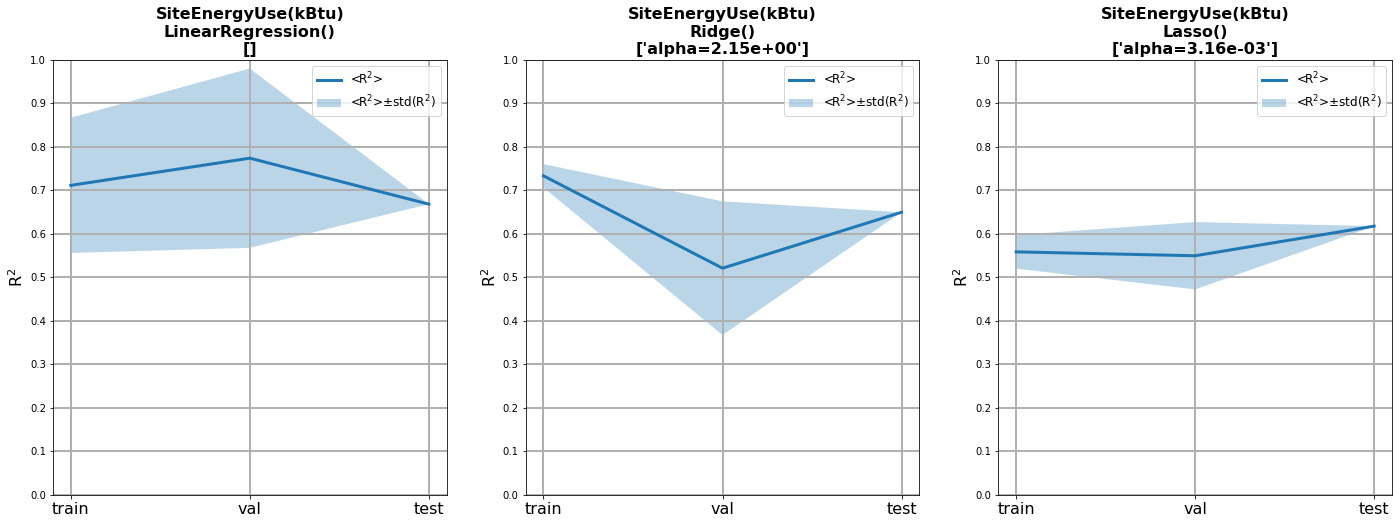

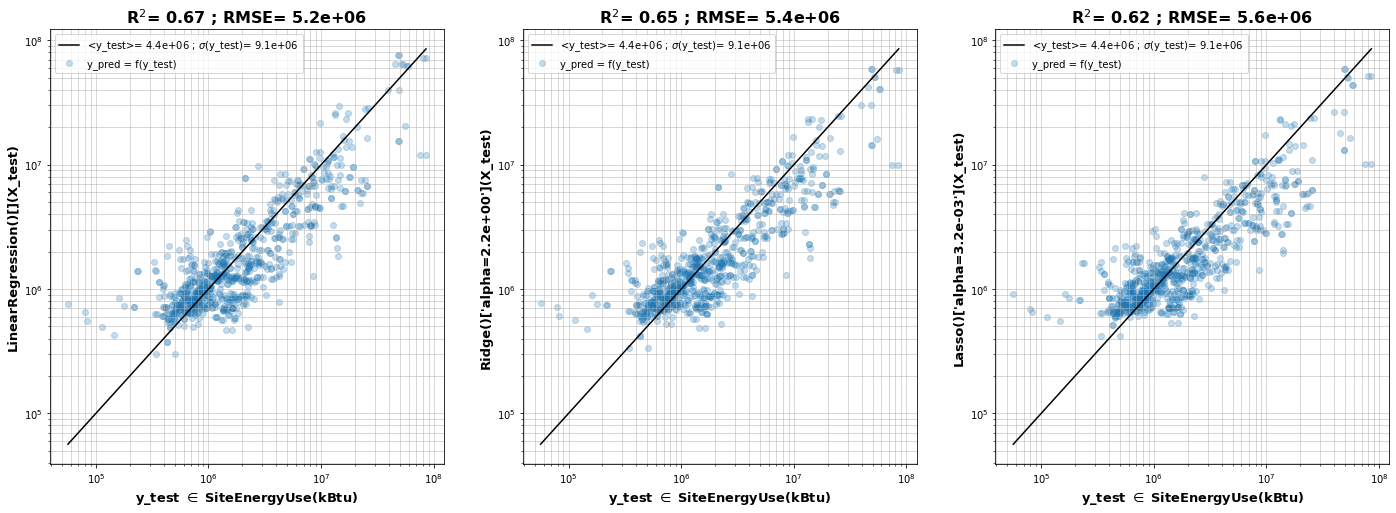

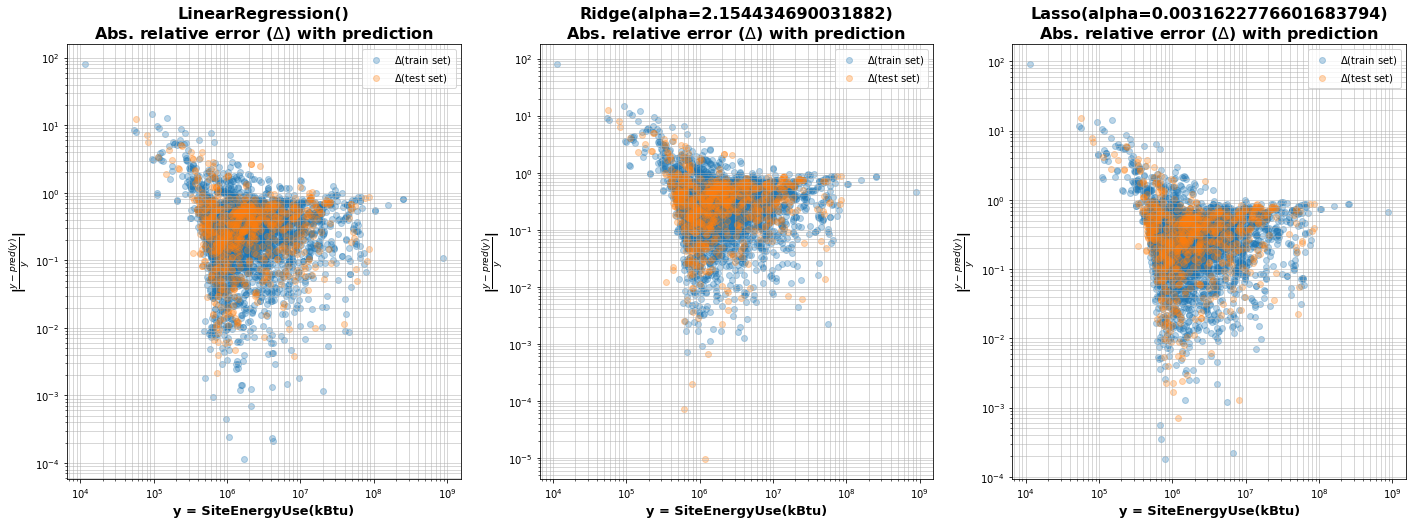

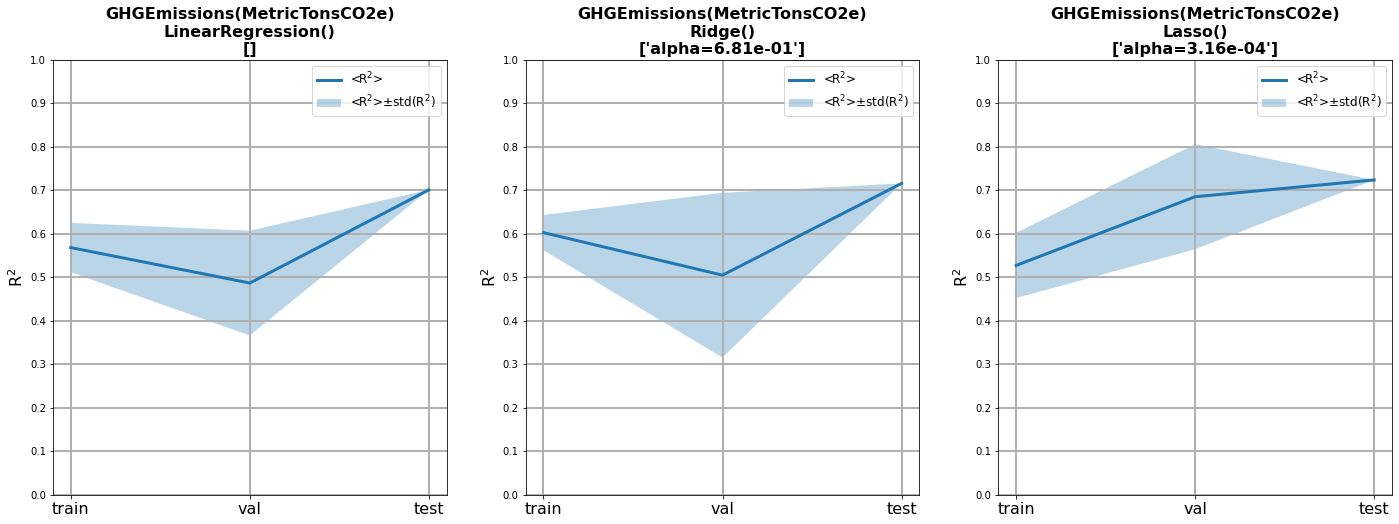

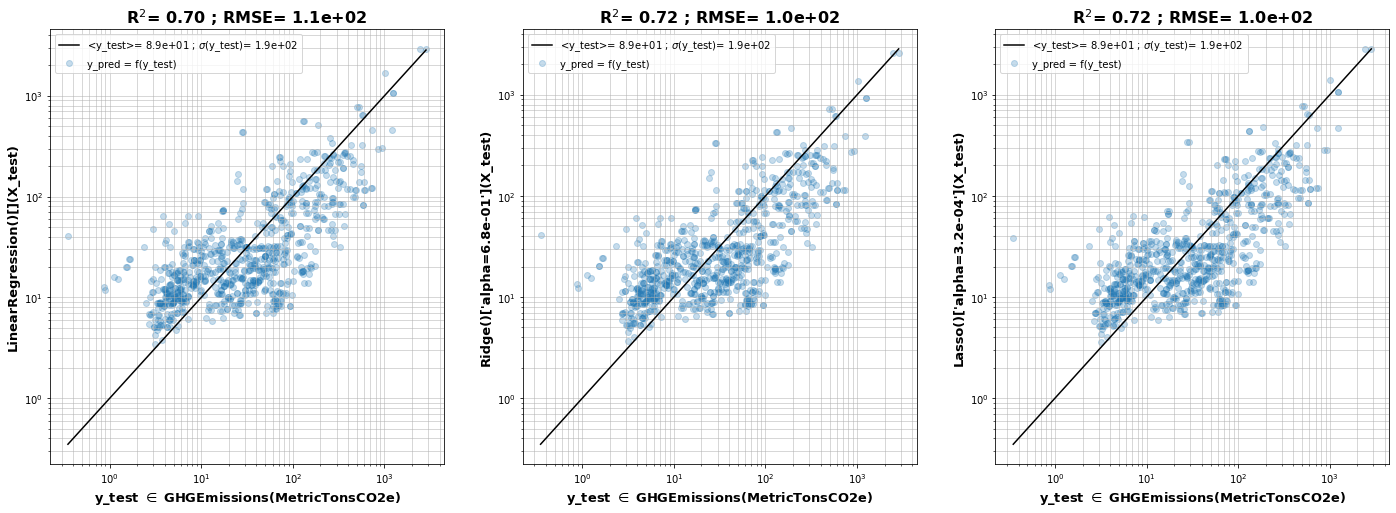

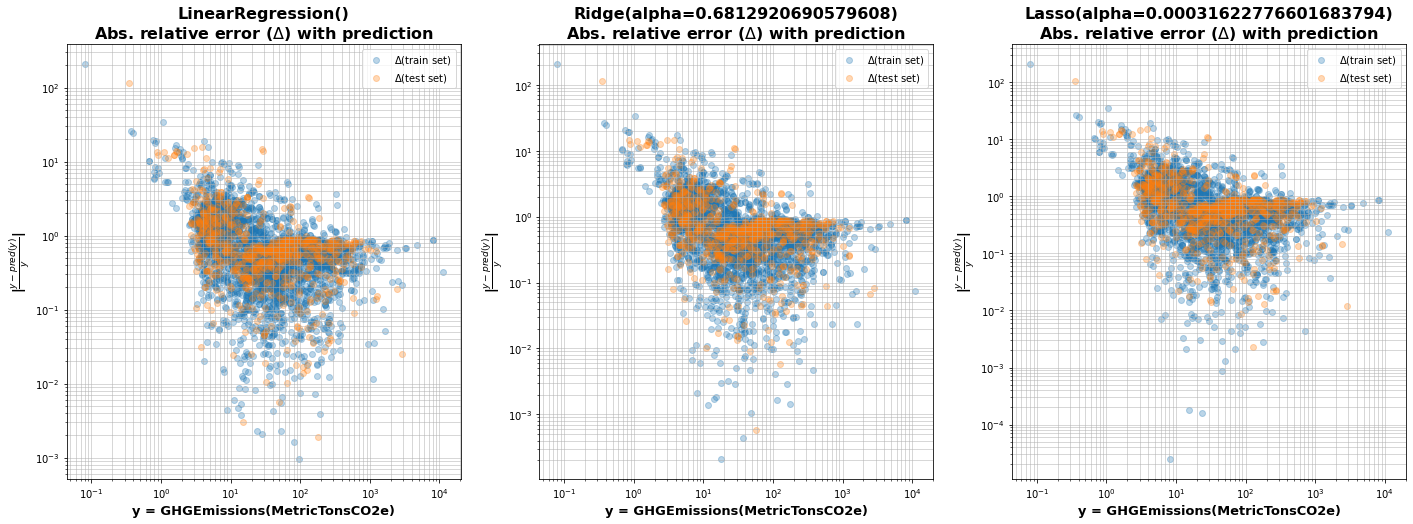

In [75]:
if Regression_lineaire_donnees_normalisées_feat0lasso :
    tab_tab_trans_Y, tab_X_train, tab_Y_train, tab_X_test, tab_Y_test, tab_tab_grid_cv, tab_tab_delta = [], [], [], [], [], [], []
    for indx_etq in [0,1]:
        tab_alpha, tab_models, tab_dict_param, colonnes = np.logspace(-5,1,37), [LinearRegression(), Ridge(), Lasso()], [{}, {'alpha':tab_alpha}, {'alpha':tab_alpha}], X_scaled_op1.columns.drop(X_scaled_op1.columns[tab_feat0lasso[indx_etq]])
        # On redéfinit ces jeux en appliquant ces indices au jeu de données normalisées
        X_train, X_test, Y_train, Y_test = X_scaled_op1.loc[indices_train, colonnes], X_scaled_op1.loc[indices_test, colonnes], Y_scaled_op1.loc[indices_train], Y_scaled_op1.loc[indices_test]
        tab_gridcv = gridsearchcv_plusieurs_models([tab_etiquettes[indx_etq]], X_train, Y_train, X_test, Y_test, tab_models, tab_dict_param, 5, 5)#tab_scores_train_cv, tab_scores_val_cv, tab_scores_test_cv, tab_param_cv, 
        plot_gridsearchcv_plusieurs_models_rescaled([tab_etiquettes[indx_etq]], tab_trans_Y, X_train, Y_train, X_test, Y_test, tab_gridcv, 'Regression_linVSridgeVSlasso_dataQuantNorm_sFeatCoeff0', 5)
        plot_gridsearchcv_pred_f_true_rescaled([tab_etiquettes[indx_etq]], tab_trans_Y, X_train, Y_train, X_test, Y_test, tab_gridcv, 'Regression_linVSridgeVSlasso_dataQuantNorm_sFeatCoeff0')
        tab_delta = plot_abs_err_rel_f_true_rescaled([tab_etiquettes[indx_etq]], tab_trans_Y, X_train, Y_train, X_test, Y_test, tab_gridcv, 'Regression_linVSridgeVSlasso_dataQuantNorm_sFeatCoeff0')
        #plt.savefig(abs_path_fig+f'Regression_linVSridgeVSlasso_dataQuantNorm_sFeatCoeff0_'+tab_etiquettes[indx_etq]+'.png')
        tab_X_train.append(X_train), tab_Y_train.append(Y_train), tab_X_test.append(X_test), tab_Y_test.append(Y_test), tab_tab_grid_cv.append(tab_gridcv), tab_tab_trans_Y.append(tab_trans_Y), tab_tab_delta.append(tab_delta)
    del indx_etq, colonnes#, tab_scores_train_cv, tab_scores_val_cv, tab_scores_test_cv, tab_param_cv 

### C'est bien mieux dans le cas de <i>SiteEnergyUse</i> pour lequel le sur-apprentissage est réduit et le score sur jeu de test amélioré.
### En revanche, <i>GHGEmissions</i> réagit beaucoup moins bien à cette suppression de <i>features</i>, avec un apprentissage qui s'écroule, même en cas de régularisation. Cela veut dire que les catgéories (au travers des <i>features one hot encodées</i>) encore présentes (et pour lesquelles la regression Lasso ne mettait pas les coeff. associés à 0) font parties de celles qui sont les moins pertinentes pour prédire cette étiquette.

In [76]:
if Regression_lineaire_donnees_normalisées_feat0lasso :
    tab_rangement_modeles.append([tab_tab_trans_Y, tab_X_train, tab_Y_train, tab_X_test, tab_Y_test, tab_tab_grid_cv, 'Regression_linVSridgeVSlasso_dataQuantNorm_sFeatCoeff0'])

# 
### <u>A.2.d) Regression linéaire avec un approche moins automatisée : suppression de familles de features.</u>
### On peut aussi tenter une paproche un peu moins dans le détail que permet la programmation informatique, car en effet, cela conduit à supprimer quasiment toutes les catégories de certaines <i>features</i> qualitatives (par le biais de la suppression des <i>features one hot encodées</i> correspondantes) sauf quelques unes. On pourrait se demander si une telle conséquence ne prive pas de sens notre démarche.
### Cherchant une alternative un peu plus simple à interpréter, on décide d'essayer de mettre, de nouveau, un nombre réduit de <i>features</i> en entrée des algorithmes, mais en veillant à ne pas séparer les <i>features one hot encodées</i> issues d'une même <i>feature</i> qualitative.
### De même, on va chercher de voir à quel point on peut réduire le nombre de <i>features</i> quantitatives. Bien que beaucoup moins nombreuses que les <i>features one hot encodées</i>, les mettres toutes en entrée des régressions linéaires n'est pas forcément nécessaire, d'autant qu'il existe des fortes corrélations linéaires entre certaines d'entre elles, comme le rappelle la matrice de coefficients de corrélations linéiare (ci-dessous) :

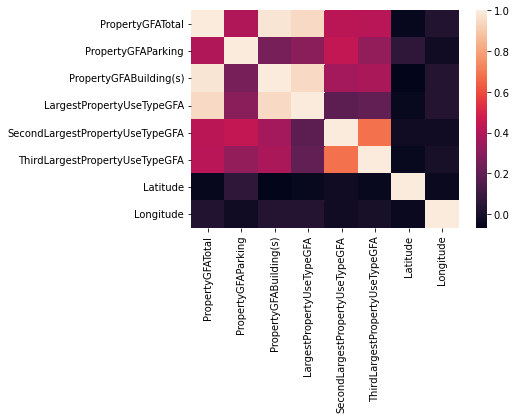

In [77]:
if Regression_lineaire_donnees_normalisées_featreduits :
    sns.heatmap(X_scaled_op1[feat_quant].corr())

### (1) Commençons donc par la réduction la plus simple et la plus forte possible du nombre de <i>features</i>, en ne laisssant en entrée des regressions linéaires qu'une seule <i>features</i> quantitative et aucune <i>features one hot encodées</i>. Notre choix se porte naturellement sur <i>PropertyGFATotal</i>, qui contient toute la surface habitables des bâtiments.

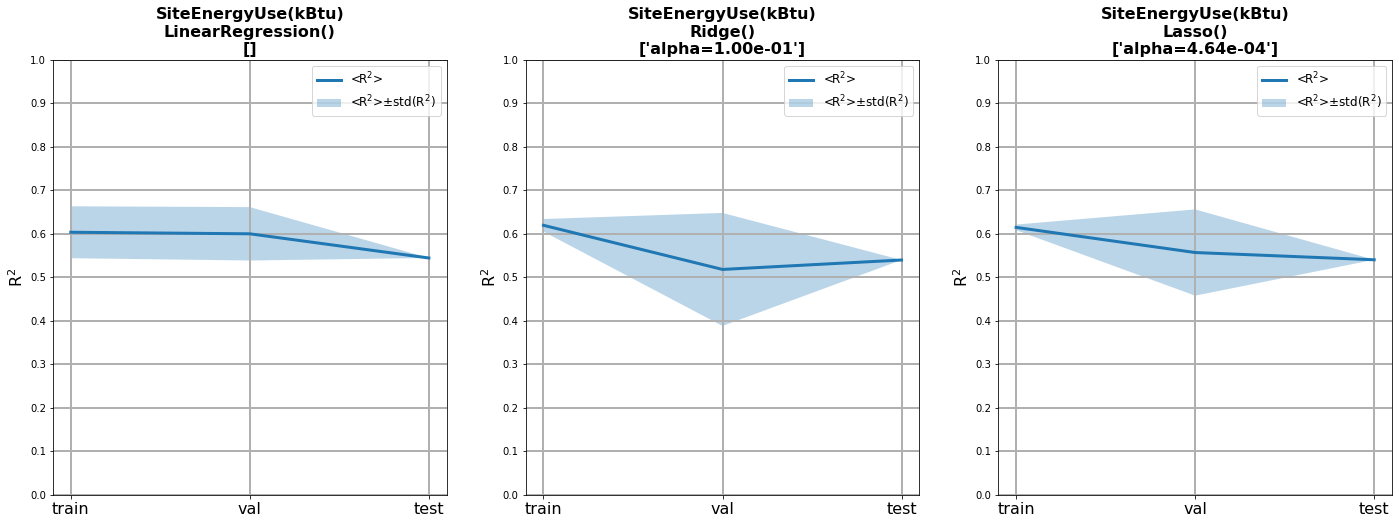

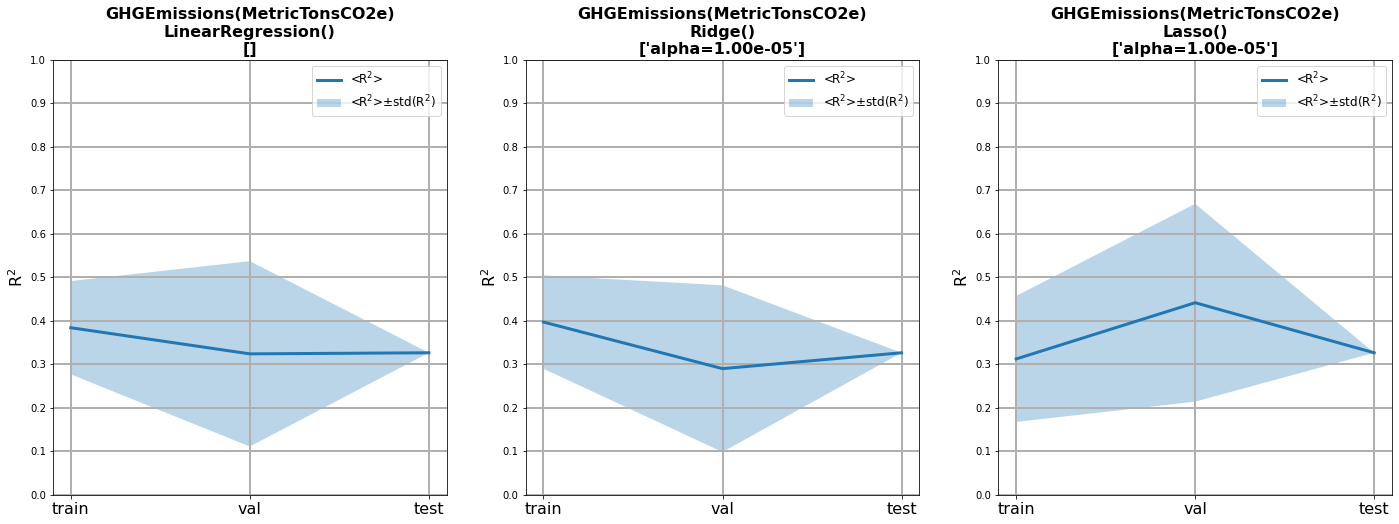

In [78]:
if Regression_lineaire_donnees_normalisées_featreduits :
    feat_conserves = ['PropertyGFATotal']
    X_red = X_scaled_op1[feat_conserves]
    X_train, X_test, Y_train, Y_test, tab_alpha = X_red.loc[indices_train], X_red.loc[indices_test], Y_scaled_op1.loc[indices_train], Y_scaled_op1.loc[indices_test], np.logspace(-5,1,37)
    tab_models, tab_dict_param = [LinearRegression(), Ridge(), Lasso()], [{}, {'alpha':tab_alpha}, {'alpha':tab_alpha}]
    tab_gridcv = gridsearchcv_plusieurs_models(tab_etiquettes, X_train, Y_train, X_test, Y_test, tab_models, tab_dict_param, 5, 5)   
    plot_gridsearchcv_plusieurs_models_rescaled(tab_etiquettes, tab_trans_Y, X_train, Y_train, X_test, Y_test, tab_gridcv, 'Regression_linVSridgeVSlasso_dataQuantNorm_featreduits1', 5)

### Les performances des 3 types de régressions linéaires sont certes moindre que celles obtenues lors des sections précédentes avec les 199 <i>features</i>, mais ça demeurre tout de même honorable pour un modèle aussi simple, surtout dans le cas de <i>SiteEnergyUse</i>, où R²(test) demeure supérieur à 0,5. On notera par ailleurs que le sur-apprentissage à totalement disparu (ce qui n'est pas surprennant puisqu'il n'y a plus aucune information redondante au sein du jeu d'entraînement), et que la régularisation n'apporte presque plus aucun effet correctif sur les performances. Là aussi rien d'étonnant, puisqu'il n'y a qu'un seul coefficient linéaire à traiter.
### (2) Rajoutons une série de <i>features one hot encodées</i> issues de la même <i>features</i> qualitative concernant l'usage de la surface habitable. Afin d'avoir un niveau de description assez fin (et espérer améliorer les performances des algorithmes par rapport au modèle avec un seul paramètre en entrée), on choisit <i>LargestPropertyUseType</i>.

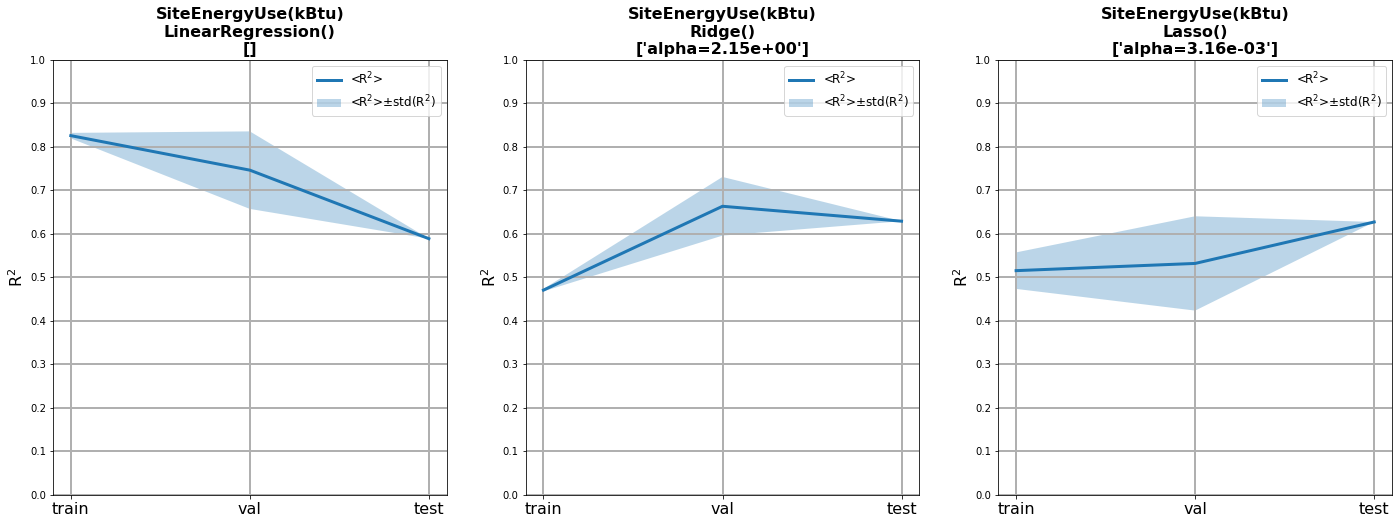

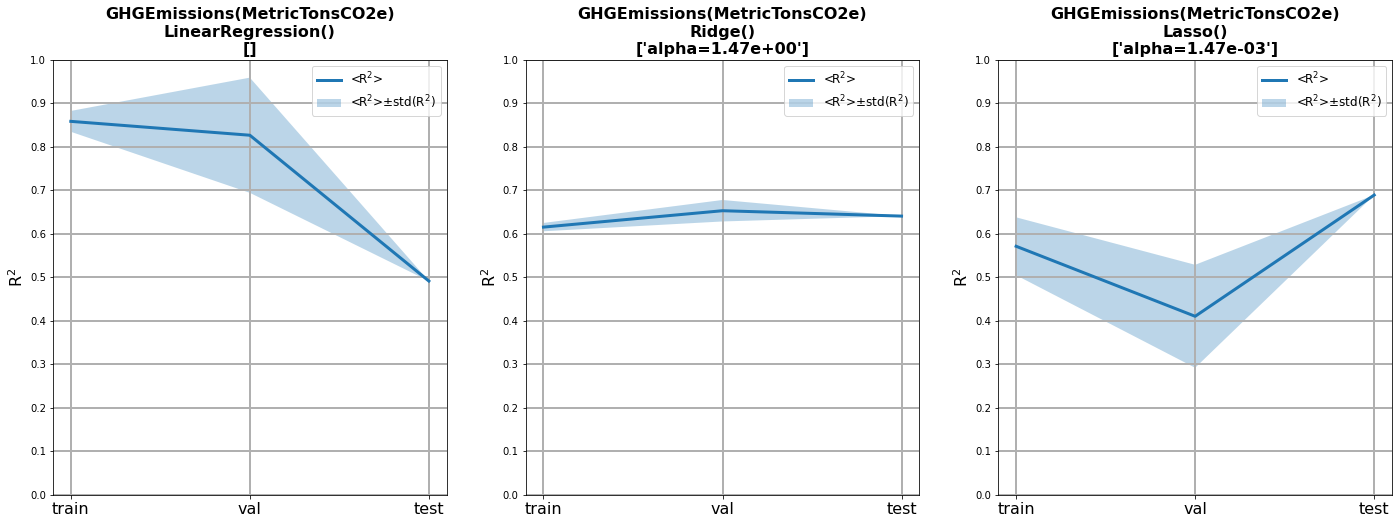

In [79]:
if Regression_lineaire_donnees_normalisées_featreduits :
    feat_conserves = np.concatenate((['PropertyGFATotal'], [col for col in X_scaled_op1.columns if 'LargestPropertyUseType' in col]))
    X_red = X_scaled_op1[feat_conserves]
    X_train, X_test, Y_train, Y_test, tab_alpha = X_red.loc[indices_train], X_red.loc[indices_test], Y_scaled_op1.loc[indices_train], Y_scaled_op1.loc[indices_test], np.logspace(-5,1,37)
    tab_models, tab_dict_param = [LinearRegression(), Ridge(), Lasso()], [{}, {'alpha':tab_alpha}, {'alpha':tab_alpha}]
    tab_gridcv = gridsearchcv_plusieurs_models(tab_etiquettes, X_train, Y_train, X_test, Y_test, tab_models, tab_dict_param, 5, 5)   
    plot_gridsearchcv_plusieurs_models_rescaled(tab_etiquettes, tab_trans_Y, X_train, Y_train, X_test, Y_test, tab_gridcv, 'Regression_linVSridgeVSlasso_dataQuantNorm_featreduits2', 5)

### Les performances sur le jeu de test sont meilleures pour les deux étiquettes, mauis on note le retour d'un fort phénomène de sur-apprentissage, ce qui indique que c'est bien le grand nombre de catégories apportée par <i>LargestPropertyUseType</i>, avec une distribution très hétérogène du nombre d'élément par catégorie, qui induit cette chutte de performance lors de l'évaluation sur le jeu de test : en effet, l'algo doit chercher à coller au plus près de ces quelques catégories peu fréquentes et peu représentatives du jeu de données, au détriment des catégories plus fréquentes.
### L'augmentation importante du nombre de <i>features</i> (du fait des dizaines de <i>features one hot encodées</i> issues de <i>LargestPropertyUseType</i>) permet de redonner du sens à la régularisation, car il y a de nouveau beaucoup de coefficents linéaires à limiter, et donc les performances des régression Ridge et Lasso sont de nouveau bien meilleures que celle de la régression classique.
### (3) Rajoutons une série de features one hot encodées issues de la même features qualitative. On rajoute des informations liées à la position géographique par le biais de Neighboorhood.

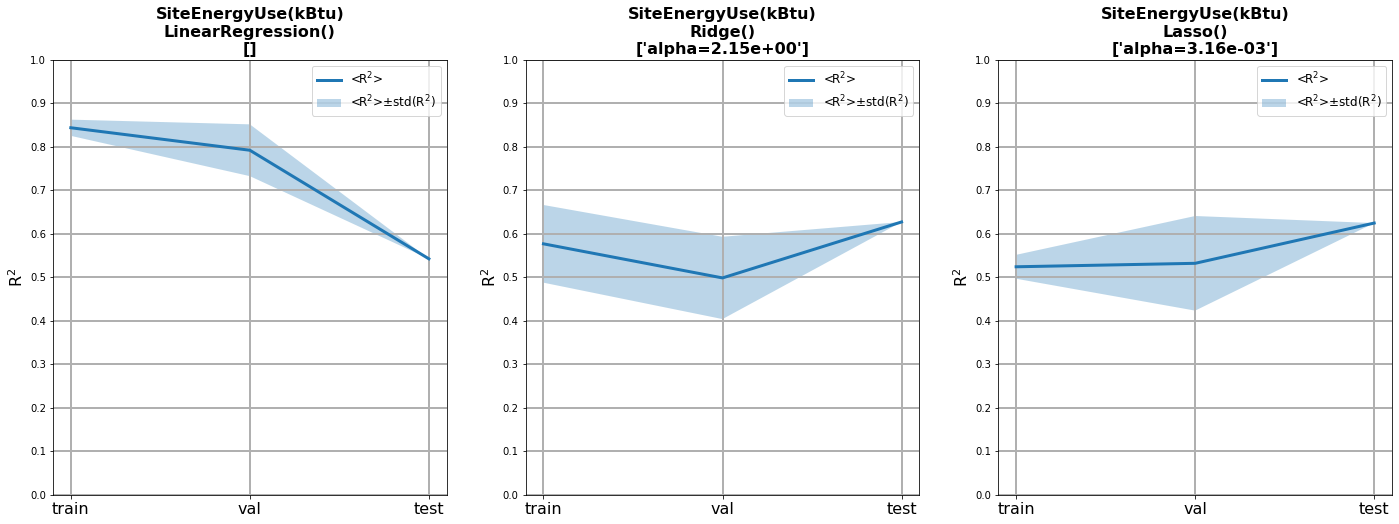

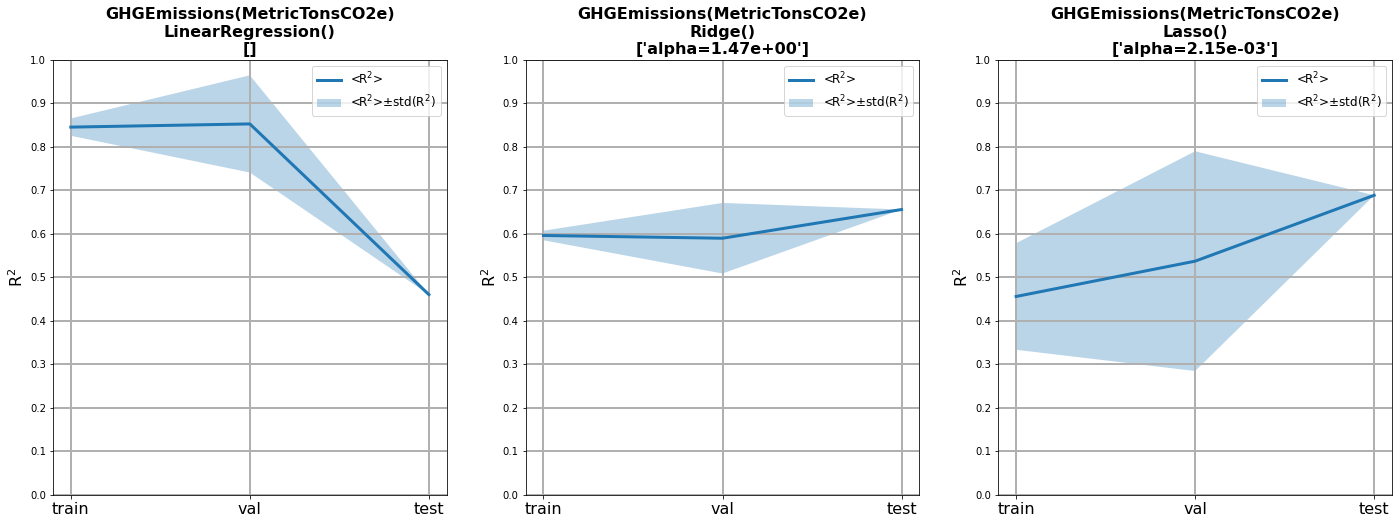

In [80]:
if Regression_lineaire_donnees_normalisées_featreduits :
    feat_conserves = np.concatenate((['PropertyGFATotal'], [col for col in X_scaled_op1.columns if np.logical_or('LargestPropertyUseType' in col, 'Neighborhood' in col)]))
    X_red = X_scaled_op1[feat_conserves]
    X_train, X_test, Y_train, Y_test, tab_alpha = X_red.loc[indices_train], X_red.loc[indices_test], Y_scaled_op1.loc[indices_train], Y_scaled_op1.loc[indices_test], np.logspace(-5,1,37)
    tab_models, tab_dict_param = [LinearRegression(), Ridge(), Lasso()], [{}, {'alpha':tab_alpha}, {'alpha':tab_alpha}]
    tab_gridcv = gridsearchcv_plusieurs_models(tab_etiquettes, X_train, Y_train, X_test, Y_test, tab_models, tab_dict_param, 5, 5)   
    plot_gridsearchcv_plusieurs_models_rescaled(tab_etiquettes, tab_trans_Y, X_train, Y_train, X_test, Y_test, tab_gridcv, 'Regression_linVSridgeVSlasso_dataQuantNorm_featreduits3', 5)

### Les performances ne sont pas améliorées, au contraire, on croit même déceller un début de sur-apprentissage chez <i>SiteEnergyUse</i>, et un score sur le jeu de test moins bon.
### (4) On remplace les <i>features one hot encodées</i> issues de <i>Neighboorhood</i> par les features quantitatives <i>Latitude et Longitude</i>

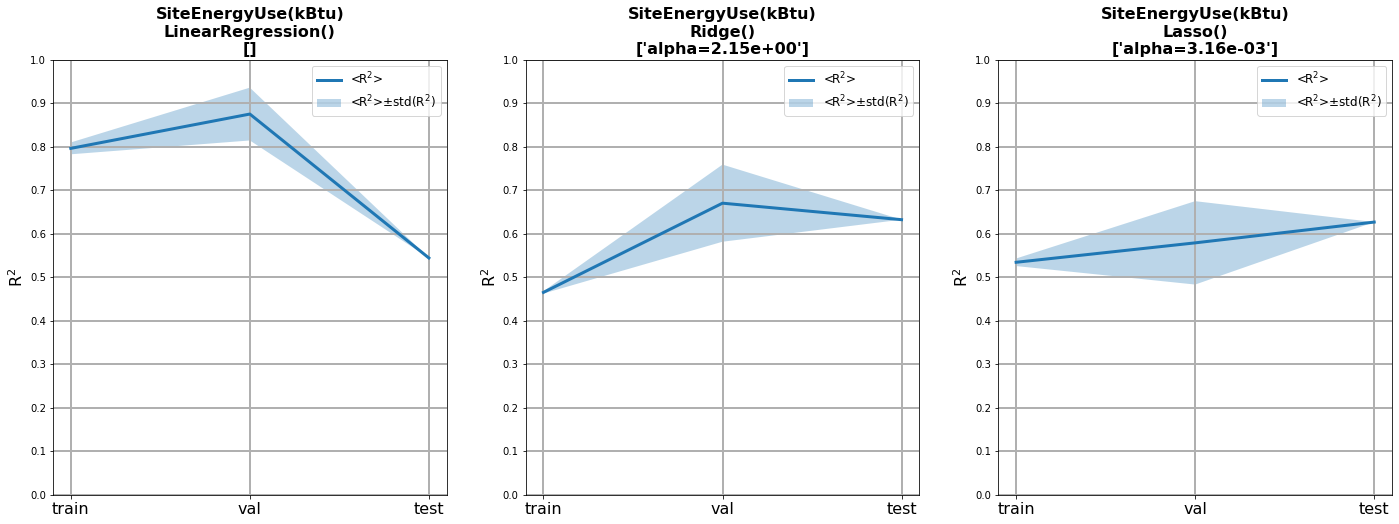

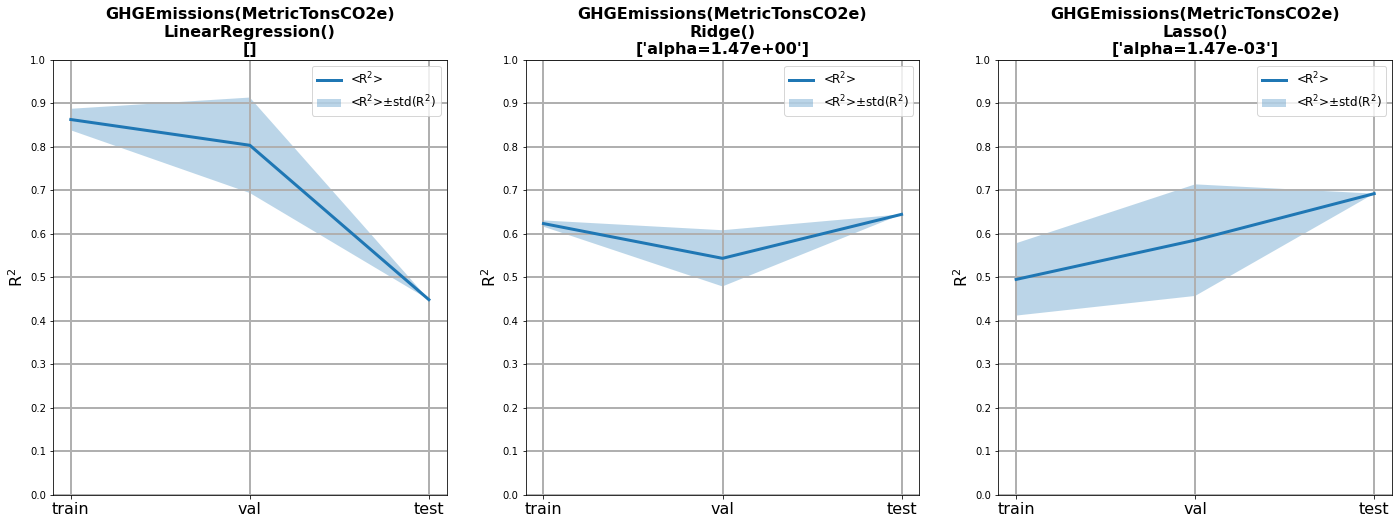

In [81]:
if Regression_lineaire_donnees_normalisées_featreduits :
    feat_conserves = np.concatenate((['PropertyGFATotal','Latitude','Longitude'], [col for col in X_scaled_op1.columns if 'LargestPropertyUseType' in col]))
    X_red = X_scaled_op1[feat_conserves]
    X_train, X_test, Y_train, Y_test, tab_alpha = X_red.loc[indices_train], X_red.loc[indices_test], Y_scaled_op1.loc[indices_train], Y_scaled_op1.loc[indices_test], np.logspace(-5,1,37)
    tab_models, tab_dict_param = [LinearRegression(), Ridge(), Lasso()], [{}, {'alpha':tab_alpha}, {'alpha':tab_alpha}]
    tab_gridcv = gridsearchcv_plusieurs_models(tab_etiquettes, X_train, Y_train, X_test, Y_test, tab_models, tab_dict_param, 5, 5)   
    plot_gridsearchcv_plusieurs_models_rescaled(tab_etiquettes, tab_trans_Y, X_train, Y_train, X_test, Y_test, tab_gridcv, 'Regression_linVSridgeVSlasso_dataQuantNorm_featreduits3', 5)

### Pas mieux que lors de la combinaison précédente. Ce qui ne nous étonne pas vraiment car :
### - les coordonnées GPS sont une manière quantitative et plus détaillée de restituer une information très similaire à celle contenue dans <i>Neighboorhood</i> ;
### - la position des bâtiments de la B2D dans le plan des coordonnées GPS n'a rien de linéaire (comme en témoignaient les graphes dans le <i>Notebook</i> précédent), c'est donc de base compliqué d'espérer pouvoir en tirer de la linéarité pour nos étiquettes.
### Conclusion : Une combinaison simple produit un résultat suffisamment honorable : <i>PropertyTotalGFA et LargestPropertyUseType</i>

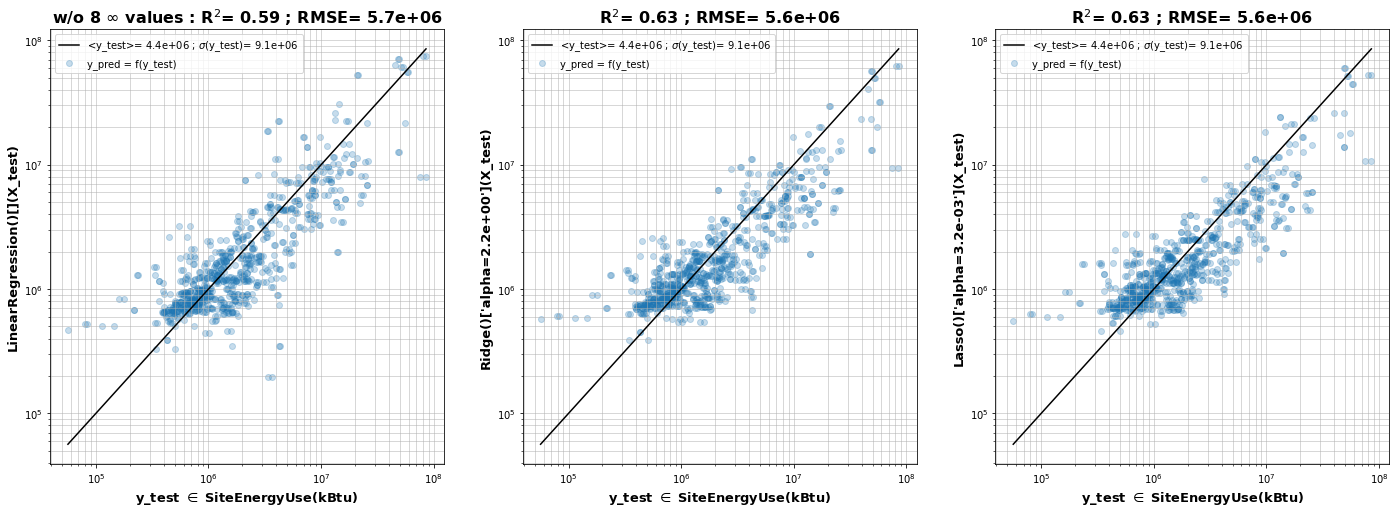

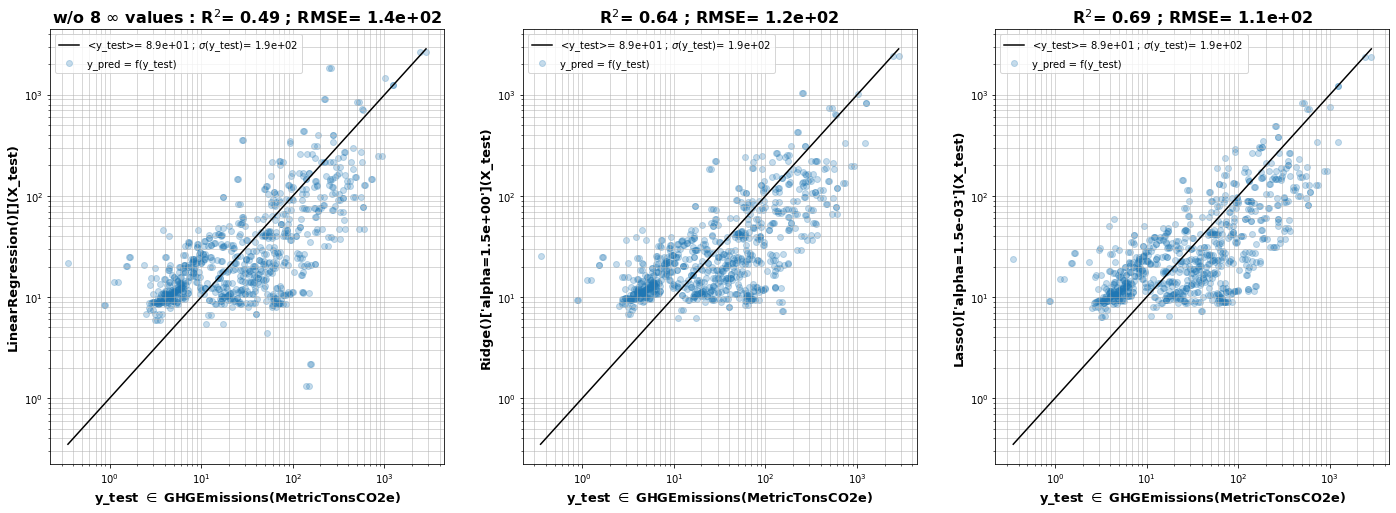

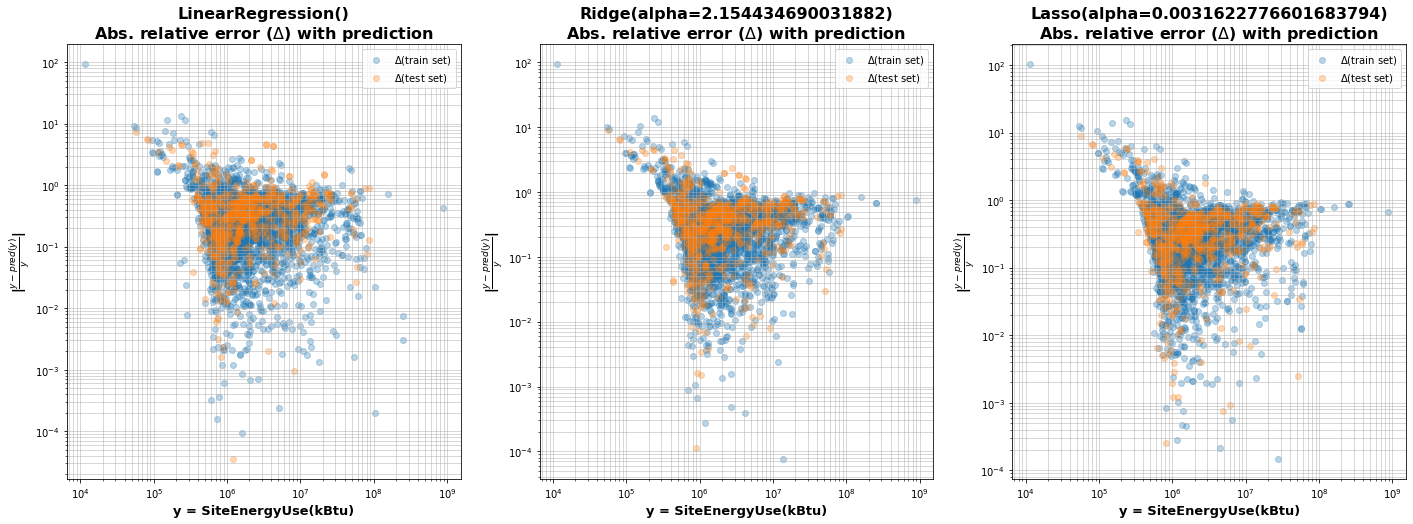

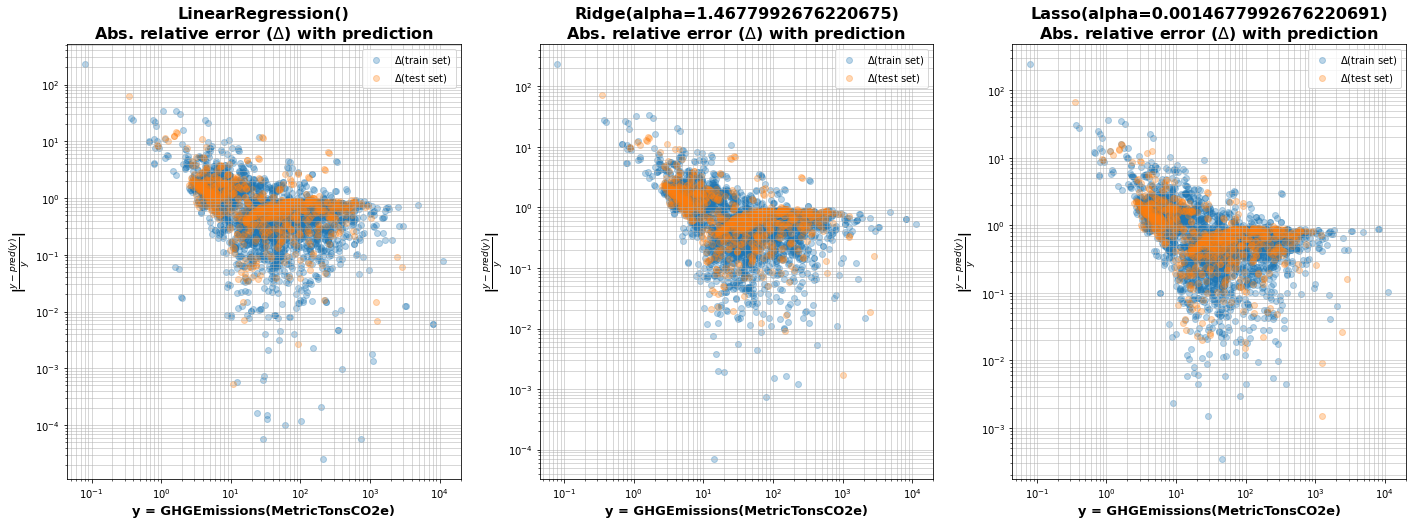

In [82]:
if Regression_lineaire_donnees_normalisées_featreduits :
    feat_conserves = np.concatenate((['PropertyGFATotal'], [col for col in X_scaled_op1.columns if 'LargestPropertyUseType' in col]))
    X_red = X_scaled_op1[feat_conserves]
    X_train, X_test, Y_train, Y_test, tab_alpha = X_red.loc[indices_train], X_red.loc[indices_test], Y_scaled_op1.loc[indices_train], Y_scaled_op1.loc[indices_test], np.logspace(-5,1,37)
    tab_models, tab_dict_param = [LinearRegression(), Ridge(), Lasso()], [{}, {'alpha':tab_alpha}, {'alpha':tab_alpha}]
    tab_gridcv = gridsearchcv_plusieurs_models(tab_etiquettes, X_train, Y_train, X_test, Y_test, tab_models, tab_dict_param, 5, 5)
    plot_gridsearchcv_pred_f_true_rescaled(tab_etiquettes, tab_trans_Y, X_train, Y_train, X_test, Y_test, tab_gridcv, 'Regression_linVSridgeVSlasso_dataQuantNorm_featreduits2')
    tab_delta = plot_abs_err_rel_f_true_rescaled(tab_etiquettes, tab_trans_Y, X_train, Y_train, X_test, Y_test, tab_gridcv, 'Regression_linVSridgeVSlasso_dataQuantNorm_featreduits2')

In [83]:
if Regression_lineaire_donnees_normalisées_featreduits :
    tab_rangement_modeles.append([tab_trans_Y, X_train, Y_train, X_test, Y_test, tab_gridcv, 'Regression_linVSridgeVSlasso_dataQuantNorm_featreduits'])

# 
### Bien, on a fait le tour de ces modèles linéaires. Passons à l'étdue de quelques modèles non linéaires :
# 
## <u>A.3) KNN Regression.</u>
### On commence par un algorithme de type K PLus Proches Voisins (qu'on abrègera KNN pour <i>K Nearest Neighboors</i>). Ce genre de modèle a principalement pour hyper-paramètre le nombre de voisins, mais également la façon une éventuelle pondération des voisins de chaque éléments. On teste ci-dessous les différence de comportement selon que les K plus proches voisins sont pondérés par leurs distances euclidiennes à l'élément courant ('distance') ou si la pondération est uniforme indépendamment de la proximité particulière de chaque voisin avec l'élément courant ('uniforme').

In [84]:
if Regresseur_KPPV_donnees_normalisée :
    X_train, X_test, Y_train, Y_test = X_scaled_op1.loc[indices_train], X_scaled_op1.loc[indices_test], Y_scaled_op1.loc[indices_train], Y_scaled_op1.loc[indices_test]
    # On parcours les étiquettes normalisées, et on applique une régression linéaire basique entre chacune d'entre elles, et les features normalisées
    for etiquette in tab_etiquettes :
        indx = list(Y_train.columns.values).index(etiquette)
        print(f'Pour l`étiquette Y = {etiquette : <35} :')
        for model in [KNeighborsRegressor(weights='uniform'), KNeighborsRegressor(weights='distance')]:#]:#
            regressor = model
            regressor.fit(X_train, Y_train[etiquette])
            y_train_true, y_train_pred = tab_trans_Y[indx].inverse_transform(Y_train[etiquette]), tab_trans_Y[indx].inverse_transform(regressor.predict(X_train))
            y_test_true, y_test_pred = tab_trans_Y[indx].inverse_transform(Y_test[etiquette]), tab_trans_Y[indx].inverse_transform(regressor.predict(X_test))
            score_train, score_test = regressor.score(X_train, Y_train[etiquette]), regressor.score(X_test, Y_test[etiquette])
            print(f'\tEntrainement sur jeu normalisé avec le modèle {str(model) : >40} : R²(train_set) = {score_train : >6.4f} ; R²(test_set) = {score_test : >6.4f}\n')
    del score_train, score_test, regressor, etiquette, model

Pour l`étiquette Y = SiteEnergyUse(kBtu)                 :
	Entrainement sur jeu normalisé avec le modèle                    KNeighborsRegressor() : R²(train_set) = 0.5610 ; R²(test_set) = 0.2314

	Entrainement sur jeu normalisé avec le modèle  KNeighborsRegressor(weights='distance') : R²(train_set) = 1.0000 ; R²(test_set) = 0.2243

Pour l`étiquette Y = GHGEmissions(MetricTonsCO2e)        :
	Entrainement sur jeu normalisé avec le modèle                    KNeighborsRegressor() : R²(train_set) = 0.6483 ; R²(test_set) = 0.2618

	Entrainement sur jeu normalisé avec le modèle  KNeighborsRegressor(weights='distance') : R²(train_set) = 1.0000 ; R²(test_set) = 0.2377



### Comme on pouvait le craindre, la pondération par la proximité entraîne un sur-apprentissage bien plus grand pour chaque étiquette. En effet, surtout compte tenu du fait que les distributions de nos <i>features</i> quantitatifs demeurent parfois encore mal réparties sur l'intervalle [0 ; 1], l'algorithme doit trouver parmis les K voisins l'un d'entre eux quasiment au même point de l'espace des <i>features</i> que l'élément courant, ce qui doit considérablement alourdir son poids de pondération. 
### A fortiori, on sait que certains éléments sont présents en 2015 et en 2016, ils peuvent donc avoir exactement les mêmes valeurs prises par les <i>features</i> (et donc avoir l'exclusivité du poids de pondération) mais potentiellement des étiquettes différentes (ce qui fait augmenter l'erreur avec la prédiction qui est calquée parfaitement sur la valeur prise par le bâtiment lors de l'autre année).
### On décide donc de fixer définitivement l'hyper-paramètre de pondération <i>weights</i> sur 'uniforme', et on n'optimisera au travers de la validation croisée unqiuement le nombre de voisins.

In [85]:
if Regresseur_KPPV_donnees_normalisée :
    # On redéfinit ces jeux en appliquant ces indices au jeu de données normalisées
    X_train, X_test, Y_train, Y_test = X_scaled_op1.loc[indices_train], X_scaled_op1.loc[indices_test], Y_scaled_op1.loc[indices_train], Y_scaled_op1.loc[indices_test]
    tab_models, tab_dict_param = [KNeighborsRegressor(weights='uniform')], [{'n_neighbors':range(10,40,2)}]
    tab_gridcv = gridsearchcv_plusieurs_models(tab_etiquettes, X_train, Y_train, X_test, Y_test, tab_models, tab_dict_param, 5, 5)#[-1]#tab_scores_train_cv, tab_scores_val_cv, tab_scores_test_cv, tab_param_cv, 

### On affiche ensuite les performances des ces modèles :

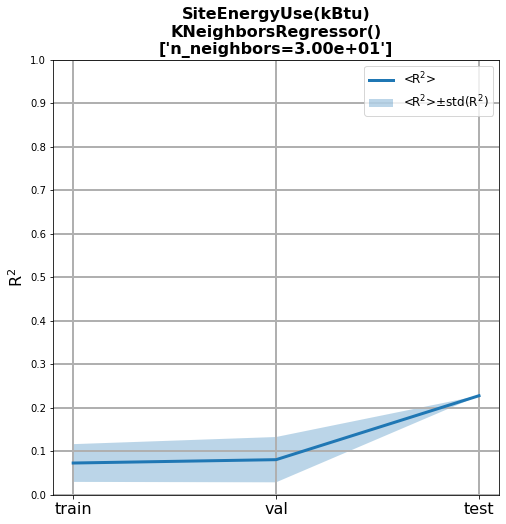

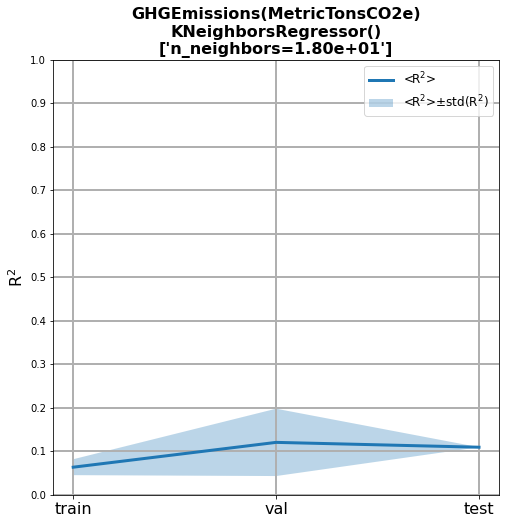

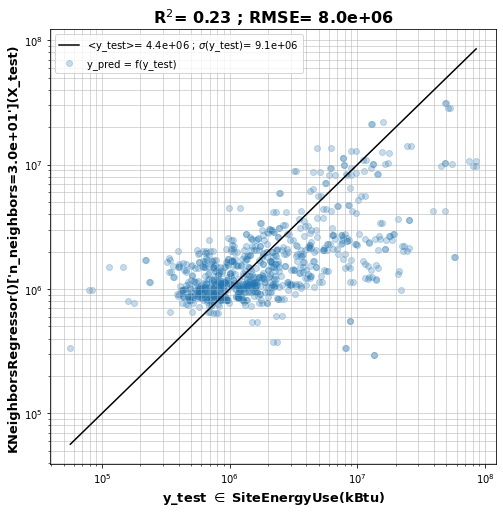

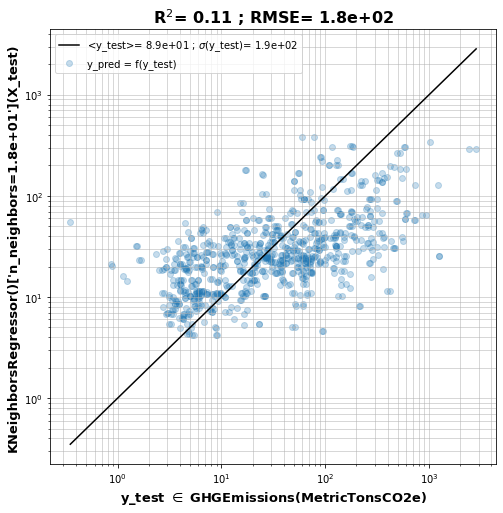

In [86]:
if Regresseur_KPPV_donnees_normalisée :
    plot_gridsearchcv_plusieurs_models_rescaled(tab_etiquettes, tab_trans_Y, X_train, Y_train, X_test, Y_test, tab_gridcv, 'Regression_KNNReg_dataQuantNorm', 5)
    plot_gridsearchcv_pred_f_true_rescaled(tab_etiquettes, tab_trans_Y, X_train, Y_train, X_test, Y_test, tab_gridcv, 'Regression_KNNReg_dataQuantNorm')
    #tab_delta = plot_abs_err_rel_f_true_rescaled(tab_etiquettes, tab_trans_Y, X_train, Y_train, X_test, Y_test, tab_gridcv, 'Regression_KNNReg_dataQuantNorm')

### Les performances sont très mauvaises, particulièrement pour <i>GHGEmissions</i>. Les graphes des prédictions en fonction des étiquettes réelles montrent d'ailleurs un nuage de points beaucoup moins serré de l'axe de prédiction parfaite f(y) = y, y compris pour les valeurs hautes des étiquettes qui conduisaient - avec les modèles de régression linéaires - à des prédictions régulièrement plus justes que les valeurs basses.
### On range ce modèle dans la liste dédiée à cet effet :

In [87]:
if Regresseur_KPPV_donnees_normalisée :
    tab_rangement_modeles.append([tab_trans_Y, X_train, Y_train, X_test, Y_test, tab_gridcv, 'Regression_KNNReg_dataQuantNorm'])

### Par ailleurs, si on fait un essai rapide de réduction du nombre de features en entrée de cet algorithme, on obtient les performances suivantes :

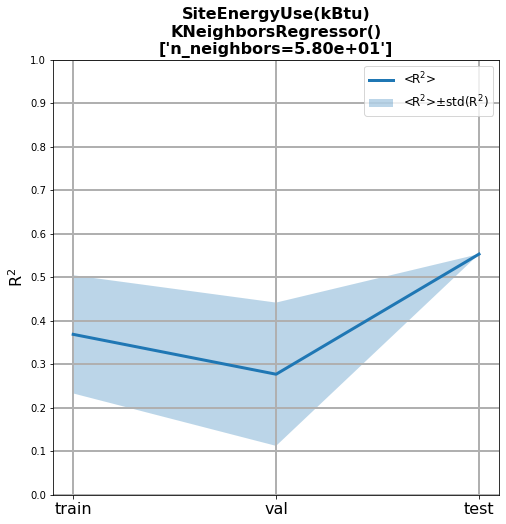

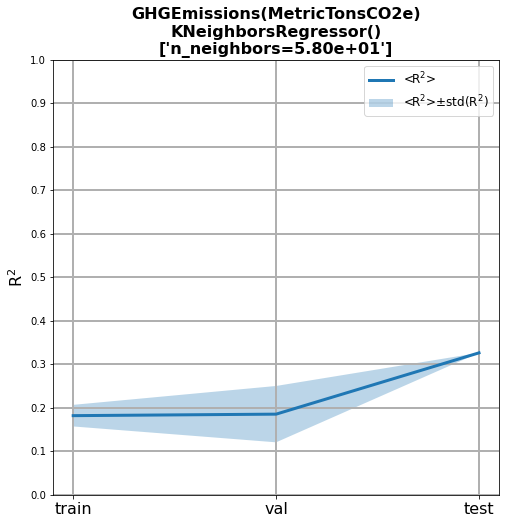

In [88]:
if Regression_lineaire_donnees_normalisées_featreduits :
    feat_conserves = ['PropertyGFATotal','PropertyGFAParking','Latitude', 'Longitude']#feat_quant#, 'YearBuilt'
    X_red = pd.concat([X[feat_quant], X_scaled_op1[X_scaled_op1.columns[len(feat_quant):]]], axis=1)#X[feat_conserves]#
    X_train, X_test, Y_train, Y_test, = X_red.loc[indices_train], X_red.loc[indices_test], Y_scaled_op1.loc[indices_train], Y_scaled_op1.loc[indices_test]
    tab_models, tab_dict_param = [KNeighborsRegressor(weights='uniform')], [{'n_neighbors':range(30,60,2)}]
    tab_gridcv = gridsearchcv_plusieurs_models(tab_etiquettes, X_train, Y_train, X_test, Y_test, tab_models, tab_dict_param, 5, 3)   
    plot_gridsearchcv_plusieurs_models_rescaled(tab_etiquettes, tab_trans_Y, X_train, Y_train, X_test, Y_test, tab_gridcv, 'Regression_KNNReg_dataQuantNorm_featreduits', 5)

### C'est bien mieux qu'avec les 199 <i>features</i> (tout en restant bien moindre que les performances des modèles linéaires).
### Cela pourrait donc bien venir des <i>features one hot encodées</i> qu'on n'a pas mis en entrée de l'algorithme ! En effet, ne prenant comme valeurs que 0 ou 1, ils peuvent conduire à une sorte de "sur-représentation" d'un élément appartenant à la même catégorie que l'élément courant, par rapport aux élément d'une catégorie différentes qu sont tous renvoyés à la même distance sans nuance possible. 

# 
### Passons à d'autres types de modèles non linéaires, mais permettant de retomber sur de la linéarité via l'astuce des noyaux :
# 
## <u>A.4) Utilisation d'un noyau.</u>
### Essayons quelques noyaux : laplacien, gaussien et polynomial. Par ailleurs, et pour comparer avec la régression linéaire classique, mais aussi la Ridge, on fait également de l'optimisation d'hyper-paramètre sur un parmaètre de régularisation, via la fonction <i>KernelRidge</i> de sklearn.

In [89]:
if Noyaux_gauss_poly_donnees_normalisée :
    # On redéfinit ces jeux en appliquant ces indices au jeu de données normalisées
    X_train, X_test, Y_train, Y_test = X_scaled_op1.loc[indices_train], X_scaled_op1.loc[indices_test], Y_scaled_op1.loc[indices_train], Y_scaled_op1.loc[indices_test]
    tab_alpha, tab_gamma, tab_degree = np.logspace(-2,0,11), np.logspace(-3,0,10), np.linspace(2,10,9)
    tab_models, tab_dict_param = [KernelRidge(kernel='laplacian'), KernelRidge(kernel='rbf'), KernelRidge(kernel='poly')], [{'alpha':tab_alpha, 'gamma':tab_gamma}, {'alpha':tab_alpha, 'gamma':tab_gamma}, {'alpha':tab_alpha, 'degree':tab_degree}]
    tab_gridcv = gridsearchcv_plusieurs_models(tab_etiquettes, X_train, Y_train, X_test, Y_test, tab_models, tab_dict_param, 5, 3)#tab_scores_train_cv, tab_scores_val_cv, tab_scores_test_cv, tab_param_cv, 

### On affiche les performances obtenues :

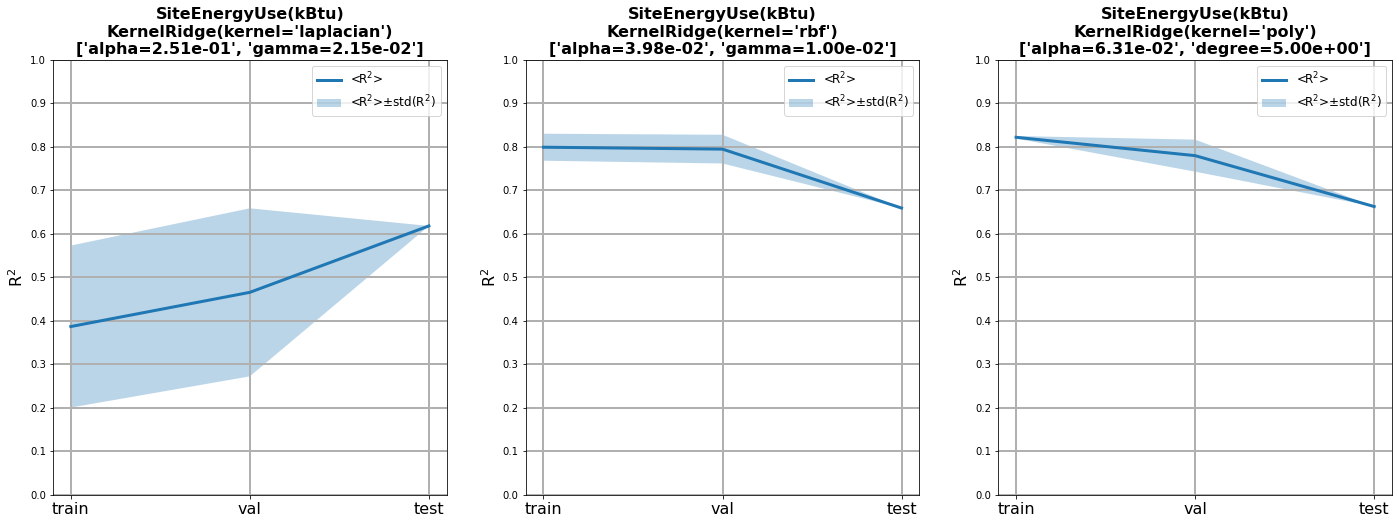

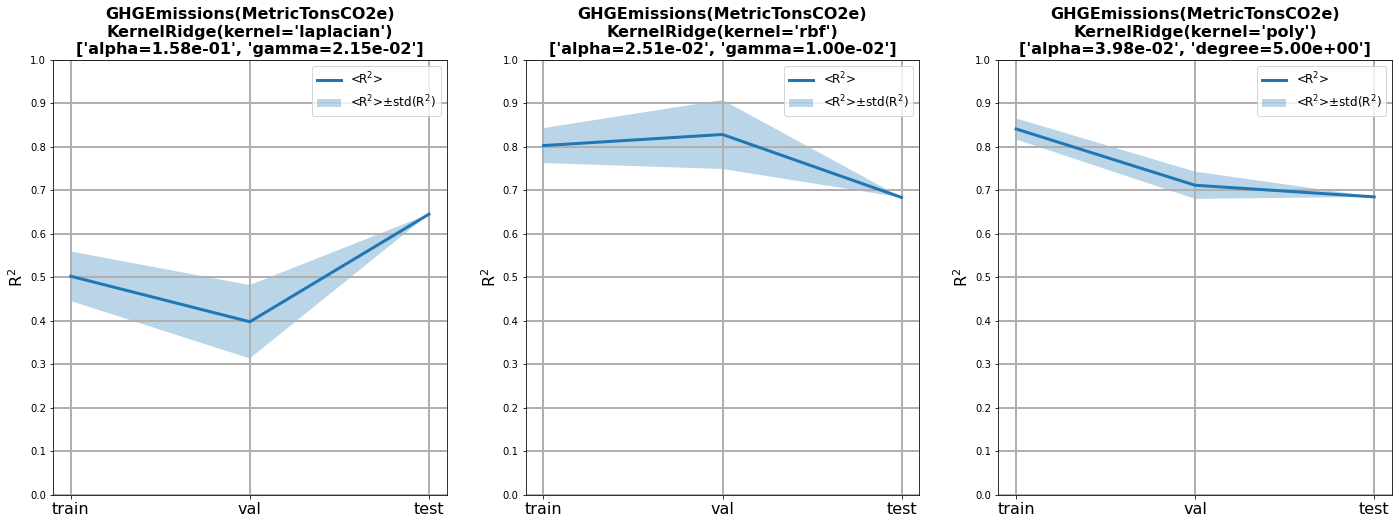

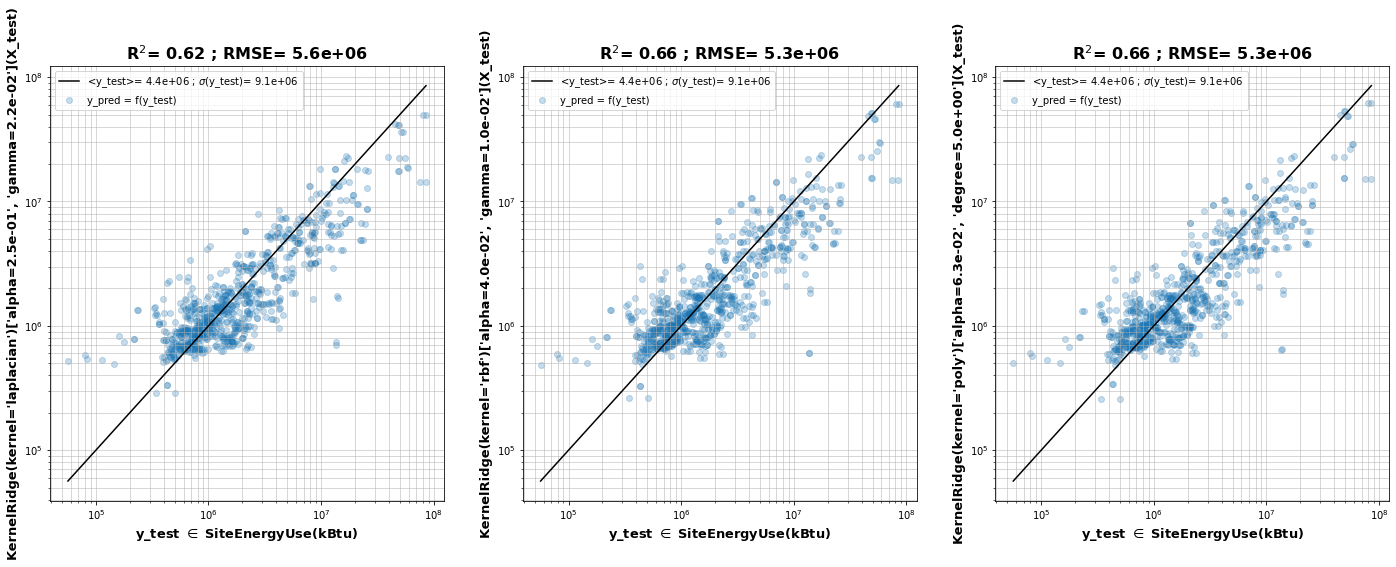

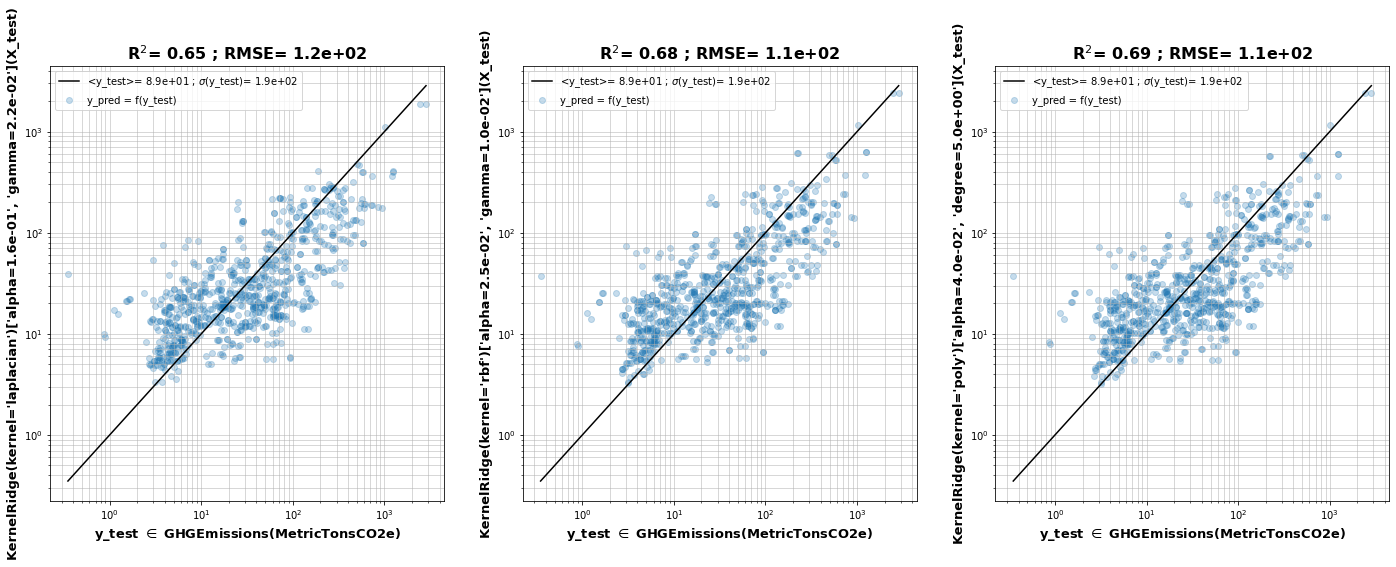

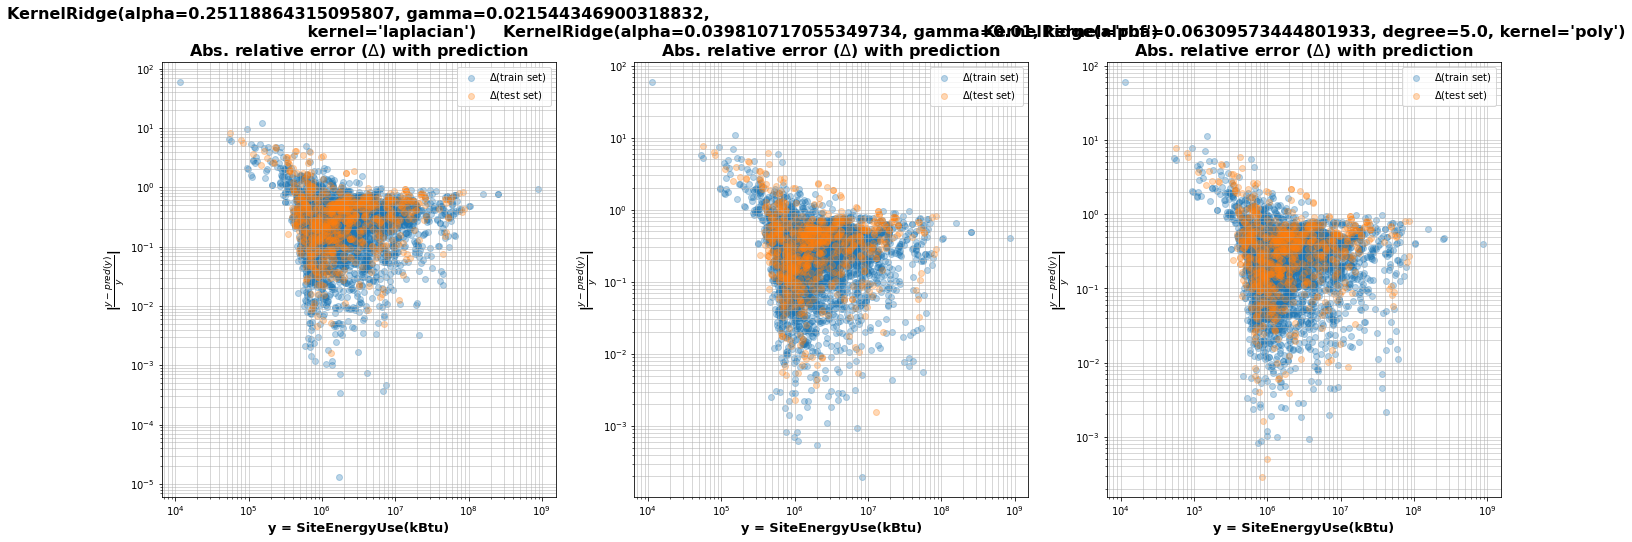

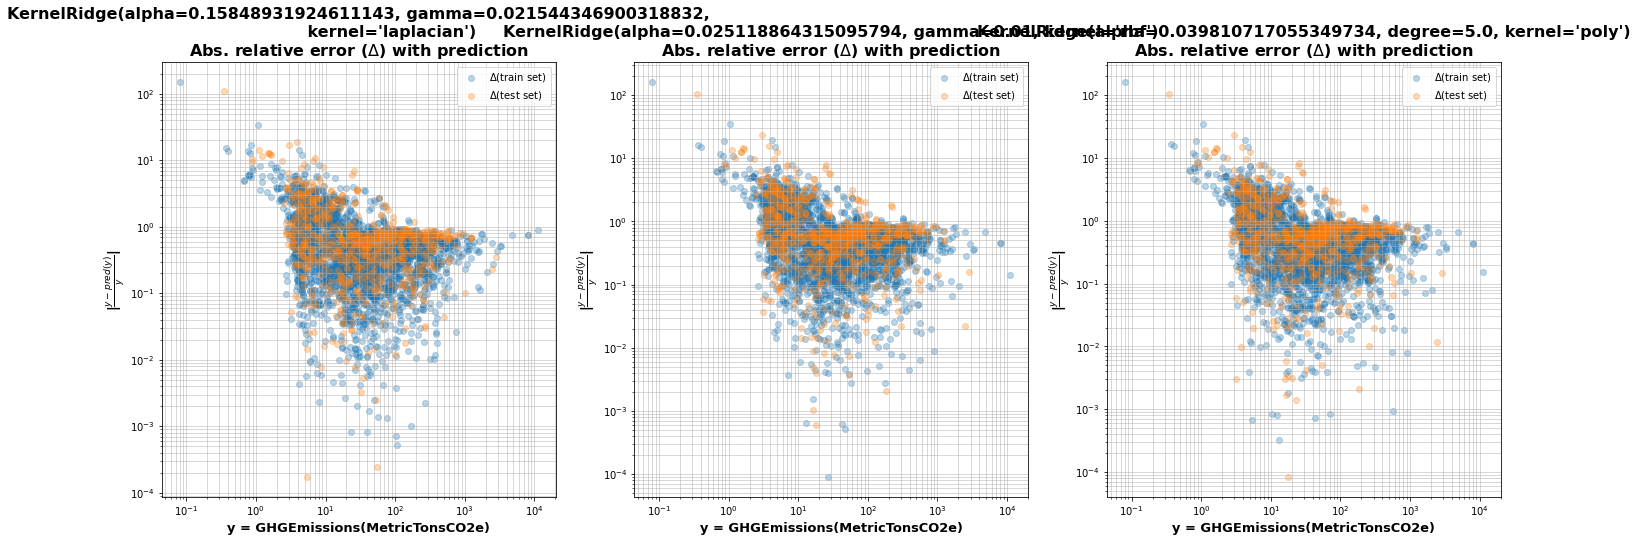

In [90]:
if Noyaux_gauss_poly_donnees_normalisée :
    #plot_gridsearchcv_plusieurs_models(False, True,  tab_etiquettes, tab_scores_train_cv, tab_scores_val_cv, tab_scores_test_cv, tab_param_cv, tab_gridcv, 'Regression_noyLaplVSgaussVSpoly_dataQuantNorm')
    plot_gridsearchcv_plusieurs_models_rescaled(tab_etiquettes, tab_trans_Y, X_train, Y_train, X_test, Y_test, tab_gridcv, 'Regression_noyLaplVSgaussVSpoly_dataQuantNorm', 3)
    plot_gridsearchcv_pred_f_true_rescaled(tab_etiquettes, tab_trans_Y, X_train, Y_train, X_test, Y_test, tab_gridcv, 'Regression_noyLaplVSgaussVSpoly_dataQuantNorm')
    tab_delta = plot_abs_err_rel_f_true_rescaled(tab_etiquettes, tab_trans_Y, X_train, Y_train, X_test, Y_test, tab_gridcv, 'Regression_noyLaplVSgaussVSpoly_dataQuantNorm')

### Le noyaux laplacien fournit des performances sur le jeu de test en trompe l'oeil, alors que les noyaux gaussiens et polynomiaux conduisent à des R²(test) supérieurs à ceux obtenus avec la régression linéaire (en particulier pour <i>GHGEmissions</i>), et très peu de sur-apprentissage.

### On range ces modèles dans la liste habituelle :

In [91]:
if Noyaux_gauss_poly_donnees_normalisée :
    tab_rangement_modeles.append([tab_trans_Y, X_train, Y_train, X_test, Y_test, tab_gridcv, 'Regression_noyLaplVSgaussVSpoly_dataQuantNorm'])

# 
### Passons à un dernier type de modèle (toujours non linéaire) mais reposant sur une méthode ensembliste :
## <u>4.5) Random Forrest Regressor.</u>
### On essaie rapidement d'évaluer les performances sur quelques valeurs de nombre d'estimateurs :

In [92]:
if RandomF_Regresseur_donnees_normalisée :
    X_train, X_test, Y_train, Y_test = X_scaled_op1.loc[indices_train], X_scaled_op1.loc[indices_test], Y_scaled_op1.loc[indices_train], Y_scaled_op1.loc[indices_test]
    # On parcours les étiquettes normalisées, et on applique une régression linéaire basique entre chacune d'entre elles, et les features normalisées
    for etiquette in tab_etiquettes :
        print(f'Pour l`étiquette Y = {etiquette : <35} :')
        for model in [RandomForestRegressor(n_estimators=10), RandomForestRegressor(n_estimators=50), RandomForestRegressor(n_estimators=100)]:#]:#
            regressor = model
            regressor.fit(X_train, Y_train[etiquette])
            score_train, score_test = regressor.score(X_train, Y_train[etiquette]), regressor.score(X_test, Y_test[etiquette])
            print(f'\tEntrainement sur jeu complet avec le modèle {str(model) : >40} : R²(train_set) = {score_train : >6.4f} ; R²(test_set) = {score_test : >6.4f}\n')
    del score_train, score_test, regressor, etiquette, model

Pour l`étiquette Y = SiteEnergyUse(kBtu)                 :
	Entrainement sur jeu complet avec le modèle   RandomForestRegressor(n_estimators=10) : R²(train_set) = 0.8798 ; R²(test_set) = 0.5887

	Entrainement sur jeu complet avec le modèle   RandomForestRegressor(n_estimators=50) : R²(train_set) = 0.9355 ; R²(test_set) = 0.5745

	Entrainement sur jeu complet avec le modèle                  RandomForestRegressor() : R²(train_set) = 0.9250 ; R²(test_set) = 0.5917

Pour l`étiquette Y = GHGEmissions(MetricTonsCO2e)        :
	Entrainement sur jeu complet avec le modèle   RandomForestRegressor(n_estimators=10) : R²(train_set) = 0.9614 ; R²(test_set) = 0.4345

	Entrainement sur jeu complet avec le modèle   RandomForestRegressor(n_estimators=50) : R²(train_set) = 0.9758 ; R²(test_set) = 0.4714

	Entrainement sur jeu complet avec le modèle                  RandomForestRegressor() : R²(train_set) = 0.9763 ; R²(test_set) = 0.4740



### Il y a visiblement une limite au nombre d'estimateurs utiles, puisque les perfomances sont très peu différentes entre 50 et 100 arbres aléatoires. Par ailleurs, le sur-apprentissage est gigantesque.
### Cela est sans doute dû à l'absence de limite de profondeur de branche, qui pousse l'algorithme à créer une feuille par élément. Testons rapidement quelques valeurs de profondeur maximale :

In [93]:
if RandomF_Regresseur_donnees_normalisée :
    X_train, X_test, Y_train, Y_test = X_scaled_op1.loc[indices_train], X_scaled_op1.loc[indices_test], Y_scaled_op1.loc[indices_train], Y_scaled_op1.loc[indices_test]
    # On parcours les étiquettes normalisées, et on applique une régression linéaire basique entre chacune d'entre elles, et les features normalisées
    for etiquette in tab_etiquettes :
        print(f'Pour l`étiquette Y = {etiquette : <35} :')
        for model in [RandomForestRegressor(n_estimators=50, max_depth=1), RandomForestRegressor(n_estimators=50, max_depth=10), RandomForestRegressor(n_estimators=50, max_depth=50), RandomForestRegressor(n_estimators=50, max_depth=100)]:#]:#
            regressor = model
            regressor.fit(X_train, Y_train[etiquette])
            score_train, score_test = regressor.score(X_train, Y_train[etiquette]), regressor.score(X_test, Y_test[etiquette])
            print(f'\tAvec le modèle {str(model) : >40} : R²(train_set) = {score_train : >6.4f} ; R²(test_set) = {score_test : >6.4f}\n')
    del score_train, score_test, regressor, etiquette, model

Pour l`étiquette Y = SiteEnergyUse(kBtu)                 :
	Avec le modèle RandomForestRegressor(max_depth=1, n_estimators=50) : R²(train_set) = 0.3348 ; R²(test_set) = 0.4045

	Avec le modèle RandomForestRegressor(max_depth=10, n_estimators=50) : R²(train_set) = 0.8561 ; R²(test_set) = 0.5874

	Avec le modèle RandomForestRegressor(max_depth=50, n_estimators=50) : R²(train_set) = 0.9242 ; R²(test_set) = 0.5650

	Avec le modèle RandomForestRegressor(max_depth=100, n_estimators=50) : R²(train_set) = 0.9234 ; R²(test_set) = 0.5823

Pour l`étiquette Y = GHGEmissions(MetricTonsCO2e)        :
	Avec le modèle RandomForestRegressor(max_depth=1, n_estimators=50) : R²(train_set) = 0.3320 ; R²(test_set) = 0.2935

	Avec le modèle RandomForestRegressor(max_depth=10, n_estimators=50) : R²(train_set) = 0.8056 ; R²(test_set) = 0.4859

	Avec le modèle RandomForestRegressor(max_depth=50, n_estimators=50) : R²(train_set) = 0.9755 ; R²(test_set) = 0.4715

	Avec le modèle RandomForestRegressor(max_depth=10

### Le sur-apprentissage semble demeurer pour les meilleurs scores, mais il est possible de le limiter avec une profondeur relativement faible.
### Optimisons donc ces deux hyper-paramètres (<i>n_estimators</i> et <i>max_depth</i>) via une validation croisée :

In [94]:
if RandomF_Regresseur_donnees_normalisée :
    X_train, X_test, Y_train, Y_test = X_scaled_op1.loc[indices_train], X_scaled_op1.loc[indices_test], Y_scaled_op1.loc[indices_train], Y_scaled_op1.loc[indices_test]
    tab_models, tab_dict_param = [RandomForestRegressor()], [{'n_estimators':range(70,95,2), 'max_depth':np.concatenate((range(40,50), range(2,20,2)))}]
    tab_gridcv = gridsearchcv_plusieurs_models(tab_etiquettes, X_train, Y_train, X_test, Y_test, tab_models, tab_dict_param, 5, 5)

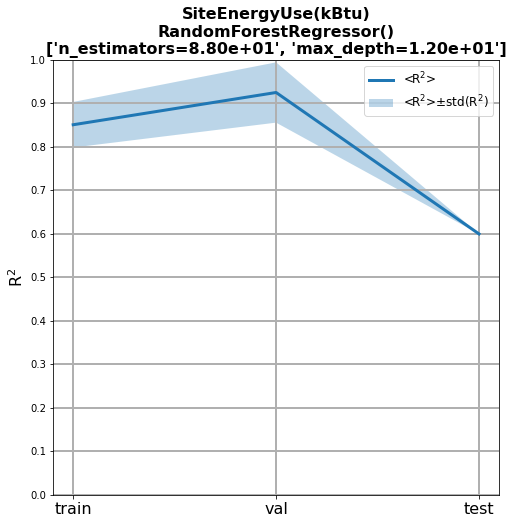

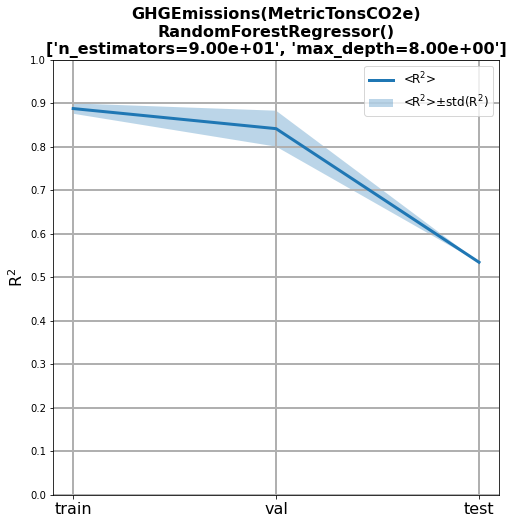

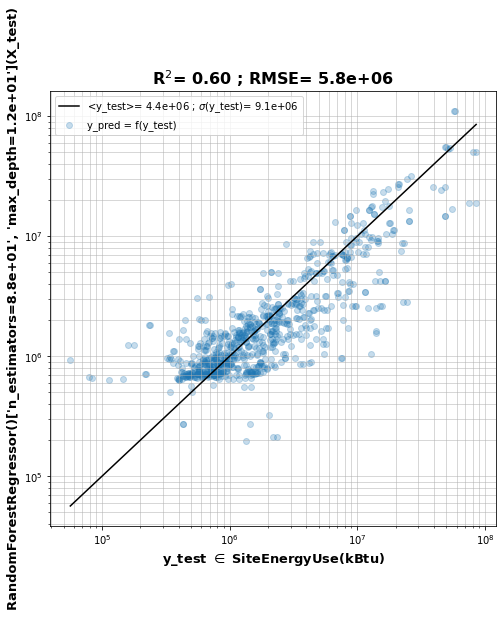

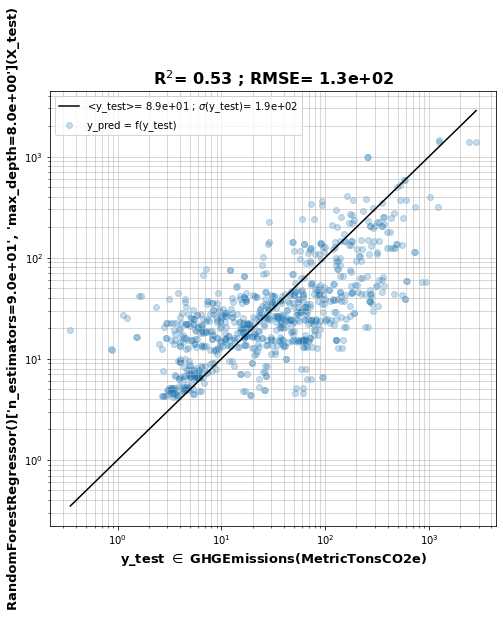

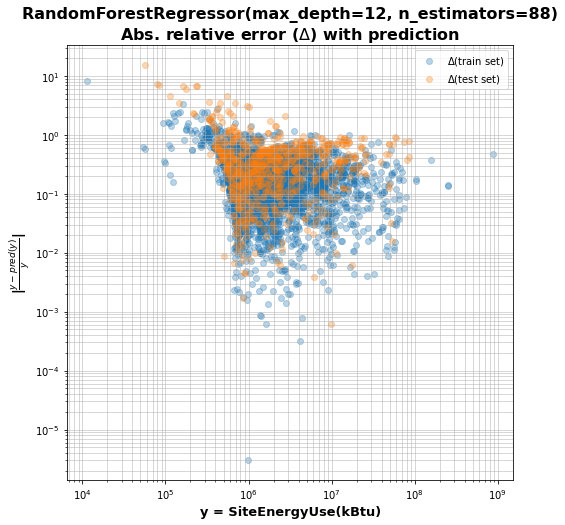

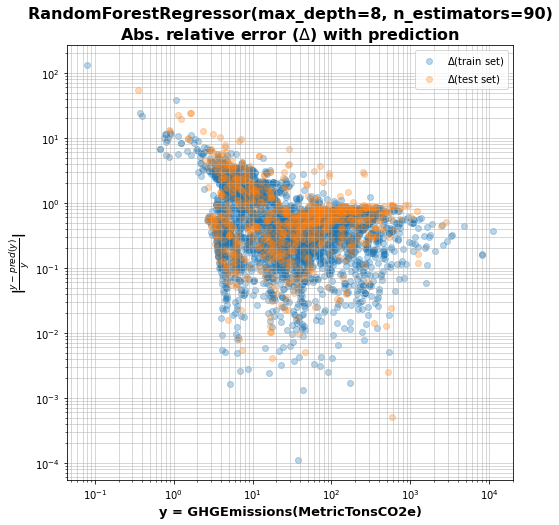

In [95]:
if RandomF_Regresseur_donnees_normalisée :
    #X_train, X_test, Y_train, Y_test = X_scaled_op1.loc[indices_train], X_scaled_op1.loc[indices_test], Y_scaled_op1.loc[indices_train], Y_scaled_op1.loc[indices_test]
    plot_gridsearchcv_plusieurs_models_rescaled(tab_etiquettes, tab_trans_Y, X_train, Y_train, X_test, Y_test, tab_gridcv, 'Regression_randForrest_dataQuantNorm', 5)
    plot_gridsearchcv_pred_f_true_rescaled(tab_etiquettes, tab_trans_Y, X_train, Y_train, X_test, Y_test, tab_gridcv, 'Regression_randForrest_dataQuantNorm')
    plot_abs_err_rel_f_true_rescaled(tab_etiquettes, tab_trans_Y, X_train, Y_train, X_test, Y_test, tab_gridcv, 'Regression_randForrest_dataQuantNorm')

### Malgré l'optimisation, les performances restent moins bonnes que pour certains noyaux, ou pour la régression linéaire avec régularisation sur peu de <i>features</i>, et encore avec un sur-apprentissage très fort.
### Rangeons d'abords ces modèles dans la liste dédiée :

In [96]:
if RandomF_Regresseur_donnees_normalisée :
    tab_rangement_modeles.append([tab_trans_Y, X_train, Y_train, X_test, Y_test, tab_gridcv, 'Regression_randForrest_dataQuantNorm'])

### Puis utilisons le paramètre <i>_feature_importances</i> de l'lagorithme pour voir l'importance de chaque <i>features</i> dans le chemin de décision accomplit par l'algorithme.

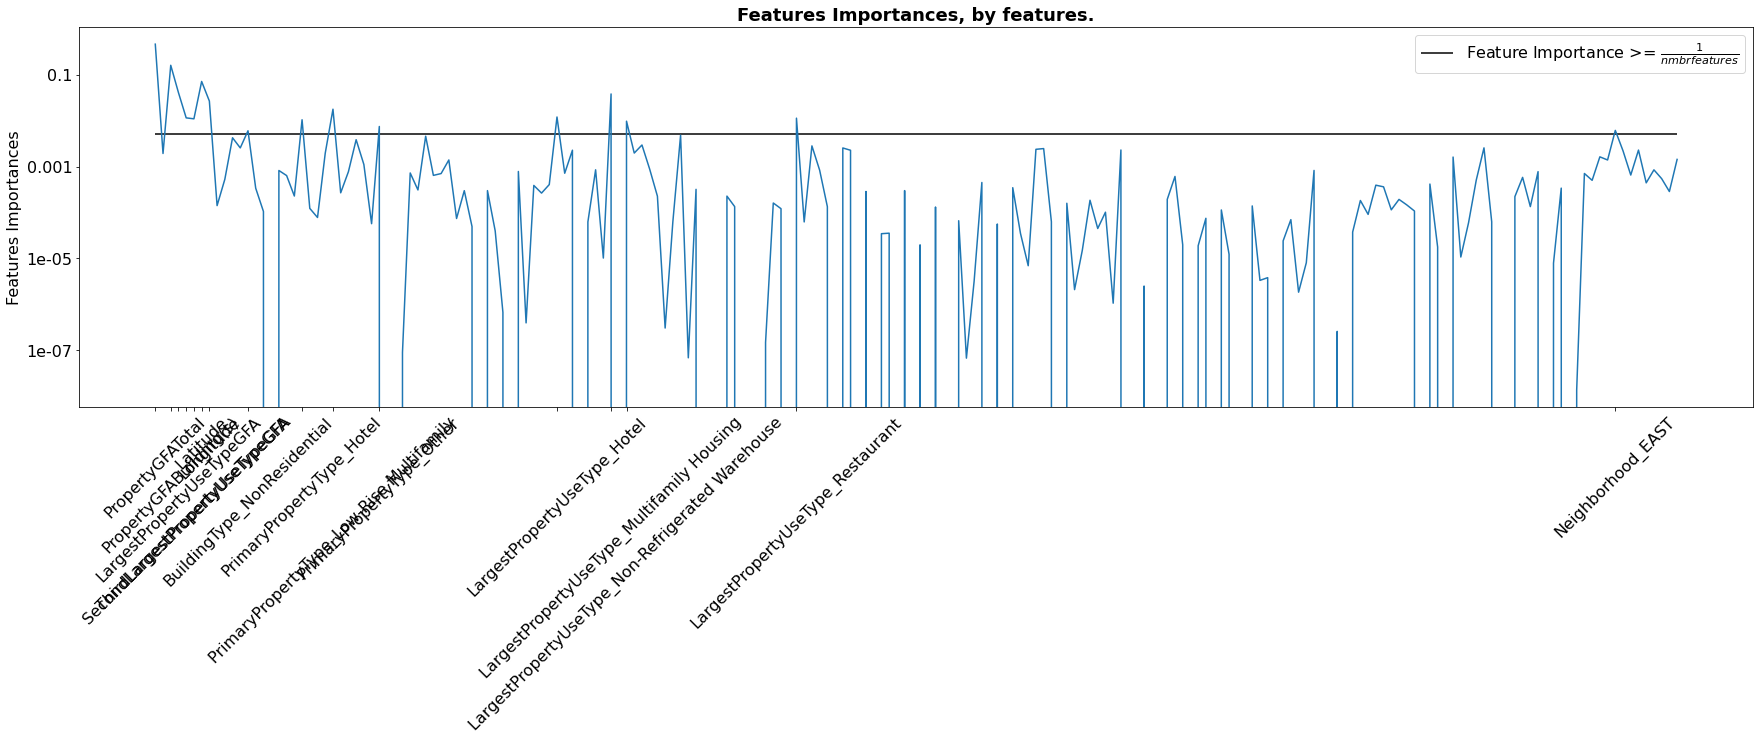

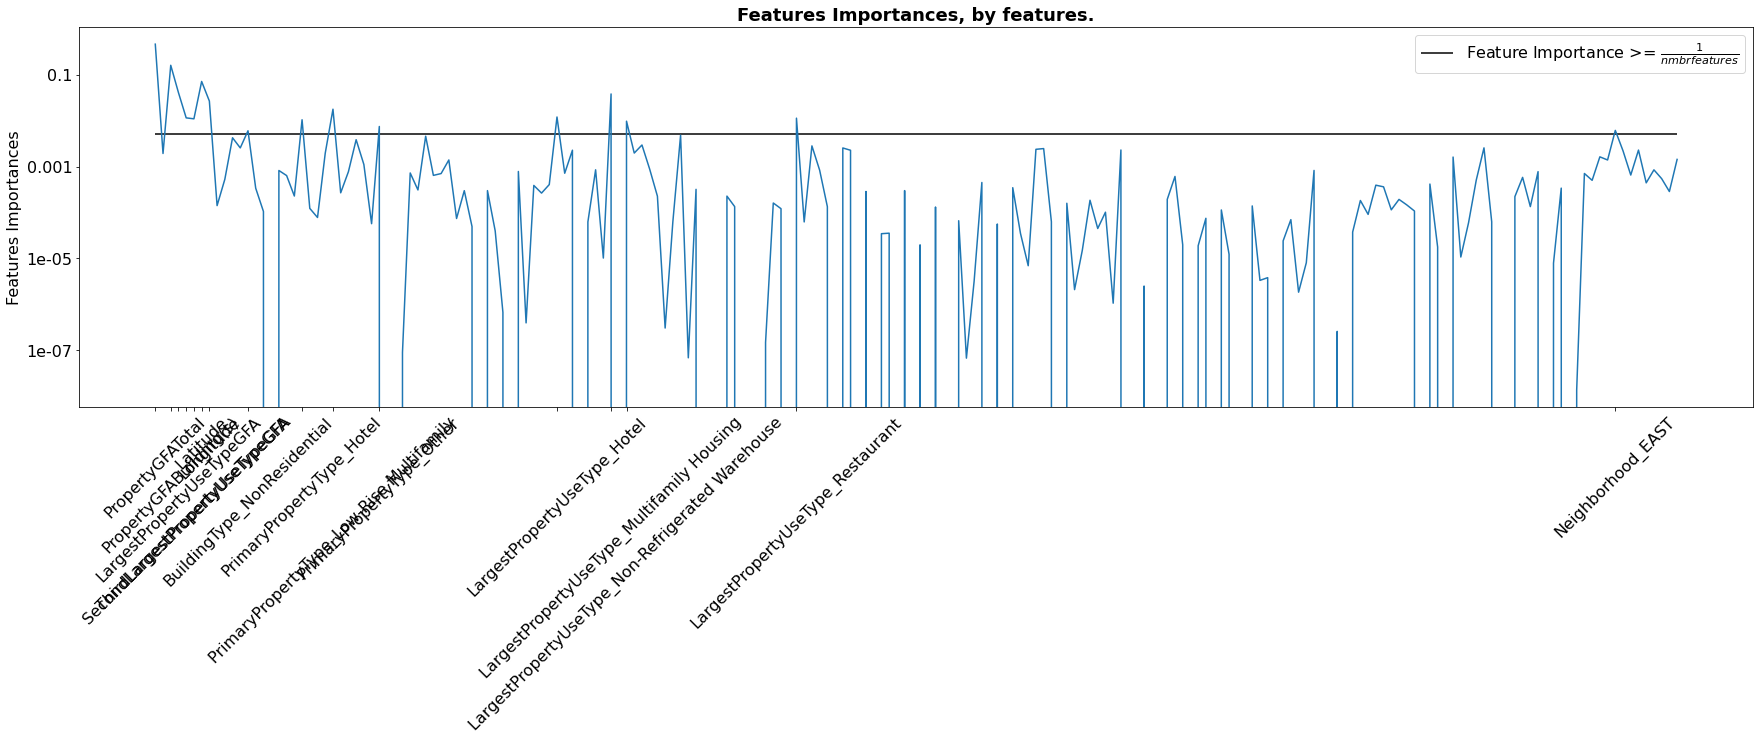

In [97]:
if RandomF_Regresseur_donnees_normalisée:
    for etiquette in tab_etiquettes :
        indx_eti = tab_etiquettes.index(etiquette)
        plt.figure('Random Forrest Features Importances data Quant Norm'+etiquette, figsize=(30,7)), plt.clf()
        axe = plt.subplot(1,1,1)
        axe.set_title('Features Importances, by features.', fontdict={'fontsize':18, 'fontweight':'bold'})
        axe.set_ylabel('Features Importances', fontdict={'fontsize':16})
        axe.plot(X_scaled_op1.columns,tab_gridcv[ind_eti,0].best_estimator_.feature_importances_), axe.set_yscale('log'), axe.set_yticklabels(axe.get_yticks(), fontdict={'fontsize':16})
        axe.set_xticks(X_scaled_op1.columns[tab_gridcv[ind_eti,0].best_estimator_.feature_importances_>=1/len(X_scaled_op1.columns)])
        axe.set_xticklabels(X_scaled_op1.columns[tab_gridcv[ind_eti,0].best_estimator_.feature_importances_>=1/len(X_scaled_op1.columns)], fontdict={'fontsize':16, 'rotation':45})
        axe.hlines(y=1/len(X_scaled_op1.columns), xmin=X_scaled_op1.columns[0], xmax=X_scaled_op1.columns[-1], label=r'Feature Importance >= $\frac{1}{nmbr features}$'), axe.legend(loc='best', fontsize=16)

### Outre que les importances des <i>features</i> sont les mêmes pour les deux étiquettes, on remarque, grâce à la droite horizontale placée en y=1/199 (soit le nombre de <i>features</i>, soit l'importance moyenne) que seuls une petite dizaine de <i>features</i> possèdent une importance supérieure à l'importance moyenne, avec la <i>feature PropertyGFATotal</i> qui écrase toutes les autres. Cela confirme d'une autre façon qu'il y a des redondances entre <i>features</i>, et qu'une grande majorité d'entre elle ne sert concrêtement à rien. Si ce n'est à faire du sur-apprentissage.
### On teste alors les performances d'une forêt alléatoire avec les mêmes hyper patamètres que précédemment, mais sur des <i>features</i> réduites à celles ayant une importance supérieure à 1/199 lors du chemin de décision de l'algorithme optimisé précédent :

In [98]:
if RandomF_Regresseur_donnees_normalisée:
    for etiquette in tab_etiquettes :
        indx_eti = tab_etiquettes.index(etiquette)
        estim = tab_gridcv[indx_eti,0].best_estimator_
        colonnes = X_scaled_op1.columns[estim.feature_importances_>=1/X_scaled_op1.shape[1]]
        X_train, X_test, Y_train, Y_test = X_scaled_op1.loc[indices_train, colonnes], X_scaled_op1.loc[indices_test, colonnes], Y_scaled_op1.loc[indices_train, etiquette], Y_scaled_op1.loc[indices_test, etiquette]
        estim2 = RandomForestRegressor(max_depth=estim.get_params()['max_depth'], n_estimators=estim.get_params()['n_estimators'])
        estim2.fit(X_train, Y_train)
        print(etiquette, r2_score(tab_trans_Y[indx_eti].inverse_transform(Y_test), tab_trans_Y[indx_eti].inverse_transform(estim2.predict(X_test))))

SiteEnergyUse(kBtu) 0.687499511840447
GHGEmissions(MetricTonsCO2e) 0.5044348504677022


### Cela conduit à une amélioration nette du socre R²(test) pour <i>SiteEnergyUse</i> mais pas pour <i>GHGEmissions</i>. Essayons d'optimiser les hyper-paramètres de l'algorithme sur ce nombre réduit de <i>features</i> pour voir si celà améliore ses performances en terme de prédiction de <i>GHGEmissions</i> :

In [99]:
if RandomF_Regresseur_donnees_normalisée :
    print('Avec les jeux de données réduits aux features les plus importants :\n')
    tab_n_est, tab_max_depth = range(10,110,10), range(10,110,10)#[range(85,95), range(70,80)], [range(40,50), range(2,20,2)]
    for etiquette in tab_etiquettes :
        indx = tab_etiquettes.index(etiquette)
        estim = tab_gridcv[indx,0].best_estimator_
        colonnes = X_scaled_op1.columns[estim.feature_importances_>=1/len(X_scaled_op1.columns)]
        X_train, X_test, y_train, y_test = X_scaled_op1.loc[indices_train, colonnes], X_scaled_op1.loc[indices_test, colonnes], Y_scaled_op1.loc[indices_train, etiquette], Y_scaled_op1.loc[indices_test, etiquette]
        gridcv_rfreg = GridSearchCV(estimator=RandomForestRegressor(), return_train_score=True, param_grid={'n_estimators':tab_n_est, 'max_depth':tab_max_depth}, n_jobs=5)
        gridcv_rfreg.fit(X_train, y_train)
        print(f'Pour l`étiquette : {etiquette : >25}')
        print('\ttrain score = %.2f; val score = %.2f; test score = %.2f'%(gridcv_rfreg.cv_results_['mean_train_score'][gridcv_rfreg.best_index_], gridcv_rfreg.cv_results_['mean_test_score'][gridcv_rfreg.best_index_], gridcv_rfreg.score(X_test, y_test)))
        #print('\t',gridcv_knn.cv_results_['mean_train_score'][gridcv_knn.best_index_], gridcv_knn.cv_results_['mean_test_score'][gridcv_knn.best_index_], gridcv_knn.score(X_test, y_test))
        print('\tparamètres optimisés =')
        print('\t',[gridcv_rfreg.cv_results_['param_'+nom_param][gridcv_rfreg.best_index_] for nom_param in gridcv_rfreg.get_params()['param_grid'].keys()],'\n')
    del indx, tab_n_est, tab_max_depth

Avec les jeux de données réduits aux features les plus importants :

Pour l`étiquette :       SiteEnergyUse(kBtu)
	train score = 0.87; val score = 0.46; test score = 0.44
	paramètres optimisés =
	 [40, 10] 

Pour l`étiquette : GHGEmissions(MetricTonsCO2e)
	train score = 0.84; val score = 0.42; test score = 0.47
	paramètres optimisés =
	 [90, 10] 



### C'est encourageant pour la seconde étiquette, faisons une validation croisée sur des domaines plus précis d'hyper-partamètres :

In [100]:
if RandomF_Regresseur_donnees_normalisée :
    tab_estim = [tab_gridcv[0,0].best_estimator_, tab_gridcv[1,0].best_estimator_]

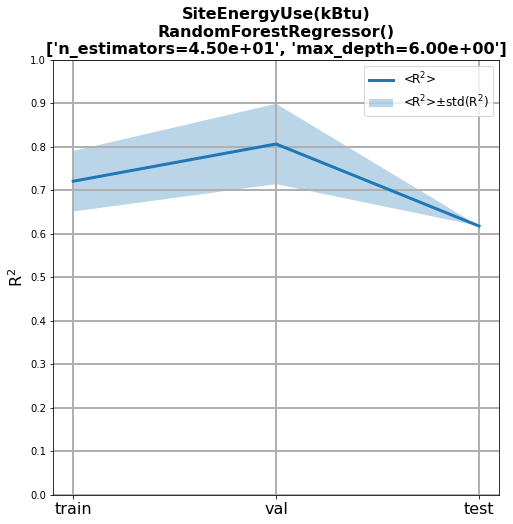

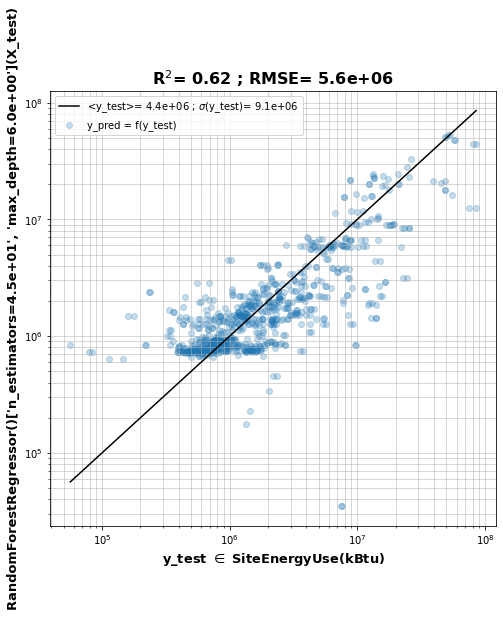

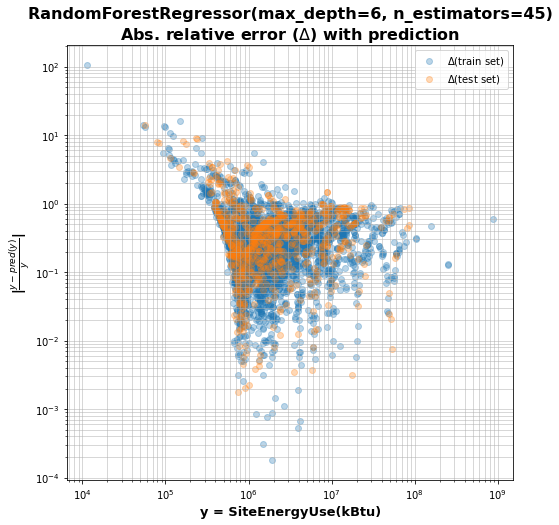

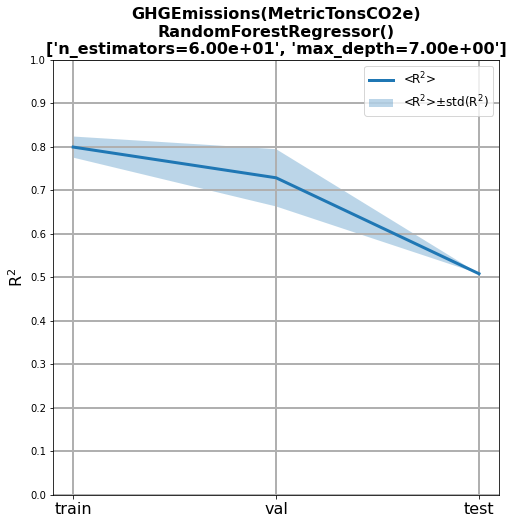

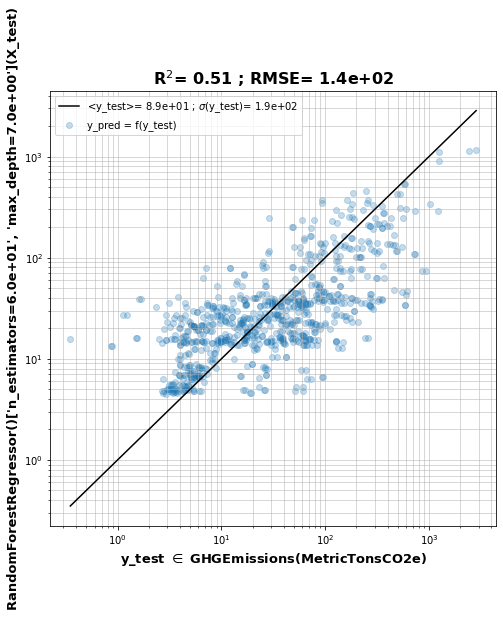

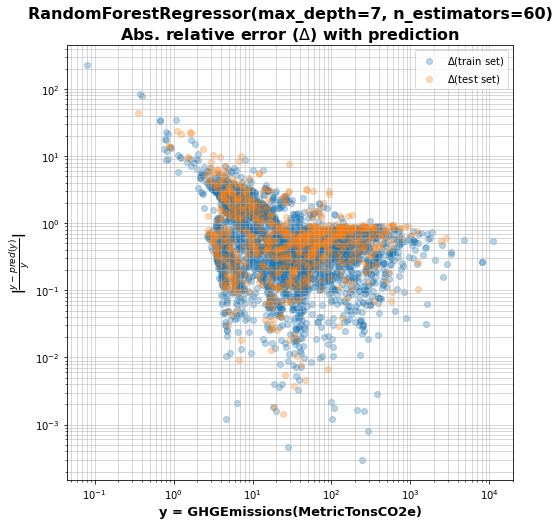

In [101]:
if RandomF_Regresseur_donnees_normalisée :
    tab_tab_trans_Y, tab_X_train, tab_Y_train, tab_X_test, tab_Y_test, tab_tab_grid_cv, tab_tab_delta = [], [], [], [], [], [], []
    tab_n_est, tab_max_depth = [range(35,46), range(55,66)], [range(2,16), range(2,16)]
    for indx_etq in [0,1]:
        estim = tab_estim[indx_etq]
        colonnes = X_scaled_op1.columns[estim.feature_importances_>=1/len(X_scaled_op1.columns)]
        tab_models, tab_dict_param = [RandomForestRegressor()], [{'n_estimators':tab_n_est[indx_etq], 'max_depth':tab_max_depth[indx_etq]}]
        # On redéfinit ces jeux en appliquant ces indices au jeu de données normalisées
        X_train, X_test, Y_train, Y_test = X_scaled_op1.loc[indices_train, colonnes], X_scaled_op1.loc[indices_test, colonnes], Y_scaled_op1.loc[indices_train], Y_scaled_op1.loc[indices_test]
        tab_gridcv = gridsearchcv_plusieurs_models([tab_etiquettes[indx_etq]], X_train, Y_train, X_test, Y_test, tab_models, tab_dict_param, 5, 5)#tab_scores_train_cv, tab_scores_val_cv, tab_scores_test_cv, tab_param_cv, 
        plot_gridsearchcv_plusieurs_models_rescaled([tab_etiquettes[indx_etq]], tab_trans_Y, X_train, Y_train, X_test, Y_test, tab_gridcv, 'Regression_randForrest_dataQuantNorm_FeatImport', 5)
        plot_gridsearchcv_pred_f_true_rescaled([tab_etiquettes[indx_etq]], tab_trans_Y, X_train, Y_train, X_test, Y_test, tab_gridcv, 'Regression_randForrest_dataQuantNorm_FeatImport')
        tab_delta = plot_abs_err_rel_f_true_rescaled([tab_etiquettes[indx_etq]], tab_trans_Y, X_train, Y_train, X_test, Y_test, tab_gridcv, 'Regression_randForrest_dataQuantNorm_FeatImport')
        #plt.savefig(abs_path_fig+f'Regression_linVSridgeVSlasso_dataQuantNorm_sFeatCoeff0_'+tab_etiquettes[indx_etq]+'.png')
        tab_X_train.append(X_train), tab_Y_train.append(Y_train), tab_X_test.append(X_test), tab_Y_test.append(Y_test), tab_tab_grid_cv.append(tab_gridcv), tab_tab_trans_Y.append(tab_trans_Y), tab_tab_delta.append(tab_delta)
    del indx_etq, colonnes, estim, tab_gridcv, tab_models, tab_dict_param

In [102]:
if Regression_lineaire_donnees_normalisées_feat0lasso :
    tab_rangement_modeles.append([tab_tab_trans_Y, tab_X_train, tab_Y_train, tab_X_test, tab_Y_test, tab_tab_grid_cv, 'Regression_randForrest_dataQuantNorm_FeatImport'])

# 
## <u>4.6) Résumé : comparaison des modèles, par étiquette.</u>

In [103]:
if Comparaison_modeles :
    tab_rangement_modeles = np.array(tab_rangement_modeles)#list(tab_rangement_modeles)#

In [104]:
tab_rangement_modeles[-1][-1]

'Regression_randForrest_dataQuantNorm_FeatImport'

### Ce sont ces différents modèles qu'on va comparer, en les résumant (score d'entraînement, de validation, de test, RMSE, etc) sous forme d'un pandas.Dataframe par étiquette. Ainsi, on pourra choisir pour chacune un algorithme "optimal".

In [105]:
if Comparaison_modeles :
    tab = tab_etiquettes#[tab_etiquettes[0]]
    # Liste qui acceuillera les listes contenant elles mêmes, pour chaque étiquette, les éléments nécessaires à la construction des Dataframes
    tab_df_resume = []
    for infos in tab_rangement_modeles :
        ligne_resume = []
        ### Quasi totalité des modèles
        if np.logical_and('sFeatCoeff0' not in infos[-1], 'FeatImport' not in infos[-1]):
            tab_trans_Y, X_train, Y_train, X_test, Y_test, tab_gridcv, categ_model = infos
            ### On parcours l'ensemble des étiquettes
            for etiquette in tab :
                indx_eti = tab.index(etiquette)
                gridcv, trans_Y, y_train, y_test = tab_gridcv[indx_eti], tab_trans_Y[indx_eti], Y_train[etiquette], Y_test[etiquette]
                for model in gridcv :
                    # On cherche l'estimateur optimisé
                    best_estm, tab_train_r2, tab_val_r2 = model.best_estimator_, [], []
                    for plis in range(5):
                        X_tra, X_val, y_tra, y_val = train_test_split(X_train, y_train)
                        # On convertit en grandeurs physiques les y_train, y_test, et les prédictions correpsondantes faites par cet estimateur
                        y_tra_true, y_tra_pred, y_val_true, y_val_pred = trans_Y.inverse_transform(y_tra), trans_Y.inverse_transform(best_estm.predict(X_tra)), trans_Y.inverse_transform(y_val), trans_Y.inverse_transform(best_estm.predict(X_val))
                        # On compte le nombre de valeurs définies à l'issue de cette conversion
                        n_inf_tra_tr, n_inf_tra_pr, n_inf_val_tr, n_inf_val_pr = y_tra_true!=np.inf, y_tra_pred!=np.inf, y_val_true!=np.inf, y_val_pred!=np.inf
                        # On en déduit le nombre de valeurs infines
                        inf_tra_tr, inf_tra_pr, inf_val_tr, inf_val_pr = y_tra_true.shape[0]-np.sum(n_inf_tra_tr), y_tra_pred.shape[0]-np.sum(n_inf_tra_pr), y_val_true.shape[0]-np.sum(n_inf_val_tr), y_val_pred.shape[0]-np.sum(n_inf_val_pr)
                        # On actualise ces vecteurs y en éliminant d'éventuels outliers infinis
                        y_tra_true, y_tra_pred, y_val_true, y_val_pred = y_tra_true[n_inf_tra_pr], y_tra_pred[n_inf_tra_pr], y_val_true[n_inf_val_pr], y_val_pred[n_inf_val_pr] 
                        # On calcule différentes métriques
                        tab_train_r2.append(r2_score(y_tra_true, y_tra_pred)), tab_val_r2.append(r2_score(y_val_true, y_val_pred)) 
                    train_r2, val_r2 = np.mean(tab_train_r2), np.mean(tab_val_r2)
                    y_test_true, y_test_pred = trans_Y.inverse_transform(y_test), trans_Y.inverse_transform(best_estm.predict(X_test))
                    n_inf_te_tr, n_inf_te_pr = y_test_true!=np.inf, y_test_pred!=np.inf
                    inf_te_tr, inf_te_pr = y_test_true.shape[0]-np.sum(n_inf_te_tr), y_test_pred.shape[0]-np.sum(n_inf_te_pr)
                    y_test_true, y_test_pred = y_test_true[n_inf_te_pr], y_test_pred[n_inf_te_pr]
                    test_r2, rmse, mae = r2_score(y_test_true, y_test_pred), mean_squared_error(y_test_true, y_test_pred, squared=False), mean_absolute_error(y_test_true, y_test_pred)
                    ### On actualise le tableau correspondant à l'étiquette courante
                    tab_df_resume.append([etiquette, categ_model[categ_model.index('data'):], model.estimator, model.best_params_, train_r2, val_r2, test_r2, rmse, mae, (inf_te_tr, inf_te_pr)])
        ### Cas particulier du modèles restreint aux coefficients demeurés non nuls après optimisation du Lasso        
        else :
            tab_tab_trans_Y, tab_X_train, tab_Y_train, tab_X_test, tab_Y_test, tab_tab_gridcv, categ_model = infos
            ### On parcours l'ensemble des étiquettes
            for etiquette in tab :
                indx_eti = tab.index(etiquette)
                tab_trans_Y, X_train, Y_train, X_test, Y_test, tab_gridcv = tab_tab_trans_Y[indx_eti], tab_X_train[indx_eti], tab_Y_train[indx_eti], tab_X_test[indx_eti], tab_Y_test[indx_eti], tab_tab_gridcv[indx_eti]
                gridcv, trans_Y, y_train, y_test = tab_gridcv.reshape(-1), tab_trans_Y[indx_eti], Y_train[etiquette], Y_test[etiquette]
                for model in gridcv :
                    # On cherche l'estimateur optimisé
                    best_estm, tab_train_r2, tab_val_r2 = model.best_estimator_, [], []
                    for plis in range(5):
                        X_tra, X_val, y_tra, y_val = train_test_split(X_train, y_train)
                        # On convertit en grandeurs physiques les y_train, y_test, et les prédictions correpsondantes faites par cet estimateur
                        y_tra_true, y_tra_pred, y_val_true, y_val_pred = trans_Y.inverse_transform(y_tra), trans_Y.inverse_transform(best_estm.predict(X_tra)), trans_Y.inverse_transform(y_val), trans_Y.inverse_transform(best_estm.predict(X_val))
                        # On compte le nombre de valeurs définies à l'issue de cette conversion
                        n_inf_tra_tr, n_inf_tra_pr, n_inf_val_tr, n_inf_val_pr = y_tra_true!=np.inf, y_tra_pred!=np.inf, y_val_true!=np.inf, y_val_pred!=np.inf
                        # On en déduit le nombre de valeurs infines
                        inf_tra_tr, inf_tra_pr, inf_val_tr, inf_val_pr = y_tra_true.shape[0]-np.sum(n_inf_tra_tr), y_tra_pred.shape[0]-np.sum(n_inf_tra_pr), y_val_true.shape[0]-np.sum(n_inf_val_tr), y_val_pred.shape[0]-np.sum(n_inf_val_pr)
                        # On actualise ces vecteurs y en éliminant d'éventuels outliers infinis
                        y_tra_true, y_tra_pred, y_val_true, y_val_pred = y_tra_true[n_inf_tra_pr], y_tra_pred[n_inf_tra_pr], y_val_true[n_inf_val_pr], y_val_pred[n_inf_val_pr] 
                        # On calcule différentes métriques
                        tab_train_r2.append(r2_score(y_tra_true, y_tra_pred)), tab_val_r2.append(r2_score(y_val_true, y_val_pred)) 
                    train_r2, val_r2 = np.mean(tab_train_r2), np.mean(tab_val_r2)
                    y_test_true, y_test_pred = trans_Y.inverse_transform(y_test), trans_Y.inverse_transform(best_estm.predict(X_test))
                    n_inf_te_tr, n_inf_te_pr = y_test_true!=np.inf, y_test_pred!=np.inf
                    inf_te_tr, inf_te_pr = y_test_true.shape[0]-np.sum(n_inf_te_tr), y_test_pred.shape[0]-np.sum(n_inf_te_pr)
                    y_test_true, y_test_pred = y_test_true[n_inf_te_pr], y_test_pred[n_inf_te_pr]
                    test_r2, rmse, mae = r2_score(y_test_true, y_test_pred), mean_squared_error(y_test_true, y_test_pred, squared=False), mean_absolute_error(y_test_true, y_test_pred)
                    ### On actualise le tableau correspondant à l'étiquette courante
                    tab_df_resume.append([etiquette, categ_model[categ_model.index('data'):], model.estimator, model.best_params_, train_r2, val_r2, test_r2, rmse, mae, (inf_te_tr, inf_te_pr)])
    ### Enfin, on résume tout ça sous forme de Dataframe
    df_resume = pd.DataFrame(tab_df_resume, columns=['Y', 'Format data', 'Modèle', 'Hyper-paramètres', 'R²(train)', 'R²(val)', 'R²(test)', 'RMSE(test)', 'MAE(test)', 'Valeurs inf (y_test, y_test_pred)'])
    tab_df_etiquette = [] 
    for etiquette in tab :
        tab_df_etiquette.append(df_resume.where(df_resume['Y']==etiquette).dropna(axis=0))
        tab_df_etiquette[-1].to_csv(abs_path_fig + 'Algo_resume_'+str(etiquette)+'.csv', sep='\t')

### Commençons par l'étiquette SiteEnergyUse(kBtu) :

In [122]:
tab_df_etiquette[0]

Y                Format data  \
0   SiteEnergyUse(kBtu)           dataQuantNonNorm   
2   SiteEnergyUse(kBtu)              dataQuantNorm   
3   SiteEnergyUse(kBtu)              dataQuantNorm   
4   SiteEnergyUse(kBtu)              dataQuantNorm   
8   SiteEnergyUse(kBtu)  dataQuantNorm_sFeatCoeff0   
9   SiteEnergyUse(kBtu)  dataQuantNorm_sFeatCoeff0   
10  SiteEnergyUse(kBtu)  dataQuantNorm_sFeatCoeff0   
14  SiteEnergyUse(kBtu)  dataQuantNorm_featreduits   
15  SiteEnergyUse(kBtu)  dataQuantNorm_featreduits   
16  SiteEnergyUse(kBtu)  dataQuantNorm_featreduits   
20  SiteEnergyUse(kBtu)              dataQuantNorm   
22  SiteEnergyUse(kBtu)              dataQuantNorm   
23  SiteEnergyUse(kBtu)              dataQuantNorm   
24  SiteEnergyUse(kBtu)              dataQuantNorm   
28  SiteEnergyUse(kBtu)              dataQuantNorm   
30  SiteEnergyUse(kBtu)   dataQuantNorm_FeatImport   

                             Modèle  \
0                LinearRegression()   
2                LinearRegression()   
3                           Ridge()   
4                           Lasso()   
8                LinearRegression()   
9                           Ridge()   
10                          Lasso()   
14               LinearRegression()   
15                          Ridge()   
16                          Lasso()   
20            KNeighborsRegressor()   
22  KernelRidge(kernel='laplacian')   
23        KernelRidge(kernel='rbf')   
24       KernelRidge(kernel='poly')   
28          RandomForestRegressor()   
30          RandomForestRegressor()   

                                     Hyper-paramètres  R²(train)   R²(val)  \
0                                                  {}   0.879228  0.928624   
2                                                  {}   0.893539  0.854923   
3                       {'alpha': 3.1622776601683795}   0.614981  0.681426   
4                    {'alpha': 0.0031622776601683794}   0.526376  0.600682   
8                                                  {}   0.810114  0.684617   
9                        {'alpha': 2.154434690031882}   0.657873  0.556095   
10                   {'alpha': 0.0031622776601683794}   0.568058  0.586267   
14                                                 {}   0.822272  0.770657   
15                       {'alpha': 2.154434690031882}   0.560334  0.543083   
16                   {'alpha': 0.0031622776601683794}   0.531924  0.559419   
20                                {'n_neighbors': 30}   0.075967  0.169289   
22  {'alpha': 0.25118864315095807, 'gamma': 0.0215...   0.259150  0.651234   
23     {'alpha': 0.039810717055349734, 'gamma': 0.01}   0.807875  0.787290   
24      {'alpha': 0.06309573444801933, 'degree': 5.0}   0.821139  0.795203   
28              {'max_depth': 12, 'n_estimators': 88}   0.823744  0.954452   
30               {'max_depth': 6, 'n_estimators': 45}   0.727887  0.738920   

    R²(test)    RMSE(test)     MAE(test) Valeurs inf (y_test, y_test_pred)  
0   0.467028  6.653695e+06  3.022494e+06                            (0, 0)  
2   0.581050  5.899187e+06  2.087727e+06                            (0, 0)  
3   0.620282  5.616188e+06  1.957797e+06                            (0, 0)  
4   0.617783  5.634634e+06  1.940819e+06                            (0, 0)  
8   0.668291  5.249154e+06  1.791863e+06                            (0, 0)  
9   0.649680  5.394401e+06  1.833472e+06                            (0, 0)  
10  0.617784  5.634631e+06  1.940817e+06                            (0, 0)  
14  0.588932  5.725511e+06  2.016611e+06                            (0, 8)  
15  0.629176  5.550022e+06  1.976497e+06                            (0, 0)  
16  0.627311  5.563958e+06  1.945804e+06                            (0, 0)  
20  0.227870  8.008588e+06  2.855168e+06                            (0, 0)  
22  0.618266  5.631076e+06  1.938708e+06                            (0, 0)  
23  0.659372  5.319254e+06  1.916497e+06                            (0, 0)  
24  0.662830  5.292189e+06  1.9066

### Quel est le modèle avec le meilleur R² pour le jeu de test ?

In [123]:
tab_df_etiquette[0].iloc[tab_df_etiquette[0]['R²(test)'].argmax()]

Y                                          SiteEnergyUse(kBtu)
Format data                          dataQuantNorm_sFeatCoeff0
Modèle                                      LinearRegression()
Hyper-paramètres                                            {}
R²(train)                                             0.810114
R²(val)                                               0.684617
R²(test)                                              0.668291
RMSE(test)                                         5.24915e+06
MAE(test)                                          1.79186e+06
Valeurs inf (y_test, y_test_pred)                       (0, 0)
Name: 8, dtype: object

### On notera également que le modèle avec le noyau polynomial produit des performances très proches (avec un apprentissage légèrement meilleur) :

In [124]:
tab_df_etiquette[0].iloc[np.argsort(tab_df_etiquette[0]['R²(test)'])].iloc[-2]

Y                                                              SiteEnergyUse(kBtu)
Format data                                                          dataQuantNorm
Modèle                                                  KernelRidge(kernel='poly')
Hyper-paramètres                     {'alpha': 0.06309573444801933, 'degree': 5.0}
R²(train)                                                                 0.821139
R²(val)                                                                   0.795203
R²(test)                                                                   0.66283
RMSE(test)                                                             5.29219e+06
MAE(test)                                                              1.90666e+06
Valeurs inf (y_test, y_test_pred)                                           (0, 0)
Name: 24, dtype: object

### Passons désormais à l'étiquette GHGEmissions(MetricTonsCO2e) :

In [125]:
tab_df_etiquette[1]

Y                Format data  \
1   GHGEmissions(MetricTonsCO2e)           dataQuantNonNorm   
5   GHGEmissions(MetricTonsCO2e)              dataQuantNorm   
6   GHGEmissions(MetricTonsCO2e)              dataQuantNorm   
7   GHGEmissions(MetricTonsCO2e)              dataQuantNorm   
11  GHGEmissions(MetricTonsCO2e)  dataQuantNorm_sFeatCoeff0   
12  GHGEmissions(MetricTonsCO2e)  dataQuantNorm_sFeatCoeff0   
13  GHGEmissions(MetricTonsCO2e)  dataQuantNorm_sFeatCoeff0   
17  GHGEmissions(MetricTonsCO2e)  dataQuantNorm_featreduits   
18  GHGEmissions(MetricTonsCO2e)  dataQuantNorm_featreduits   
19  GHGEmissions(MetricTonsCO2e)  dataQuantNorm_featreduits   
21  GHGEmissions(MetricTonsCO2e)              dataQuantNorm   
25  GHGEmissions(MetricTonsCO2e)              dataQuantNorm   
26  GHGEmissions(MetricTonsCO2e)              dataQuantNorm   
27  GHGEmissions(MetricTonsCO2e)              dataQuantNorm   
29  GHGEmissions(MetricTonsCO2e)              dataQuantNorm   
31  GHGEmissions(MetricTonsCO2e)   dataQuantNorm_FeatImport   

                             Modèle  \
1                LinearRegression()   
5                LinearRegression()   
6                           Ridge()   
7                           Lasso()   
11               LinearRegression()   
12                          Ridge()   
13                          Lasso()   
17               LinearRegression()   
18                          Ridge()   
19                          Lasso()   
21            KNeighborsRegressor()   
25  KernelRidge(kernel='laplacian')   
26        KernelRidge(kernel='rbf')   
27       KernelRidge(kernel='poly')   
29          RandomForestRegressor()   
31          RandomForestRegressor()   

                                     Hyper-paramètres  R²(train)   R²(val)  \
1                                                  {}   0.873509  0.692103   
5                                                  {}   0.886778  0.727315   
6                        {'alpha': 2.154434690031882}   0.671111  0.589549   
7                    {'alpha': 0.0014677992676220691}   0.584791  0.403453   
11                                                 {}   0.532735  0.597593   
12                      {'alpha': 0.6812920690579608}   0.521603  0.629331   
13                  {'alpha': 0.00031622776601683794}   0.529930  0.611090   
17                                                 {}   0.824841  0.905043   
18                      {'alpha': 1.4677992676220675}   0.630398  0.613150   
19                   {'alpha': 0.0014677992676220691}   0.498510  0.602928   
21                                {'n_neighbors': 18}   0.057238  0.124735   
25  {'alpha': 0.15848931924611143, 'gamma': 0.0215...   0.423834  0.586782   
26     {'alpha': 0.025118864315095794, 'gamma': 0.01}   0.815692  0.732528   
27     {'alpha': 0.039810717055349734, 'degree': 5.0}   0.815711  0.744262   
29               {'max_depth': 8, 'n_estimators': 90}   0.877727  0.889399   
31               {'max_depth': 7, 'n_estimators': 60}   0.783612  0.811827   

    R²(test)  RMSE(test)  MAE(test) Valeurs inf (y_test, y_test_pred)  
1   0.336863  158.573114  79.111808                            (0, 0)  
5   0.582050  125.889705  55.609505                            (0, 0)  
6   0.669782  111.899580  52.861431                            (0, 0)  
7   0.727202  101.706395  49.689460                            (0, 0)  
11  0.701257  106.433047  51.272720                            (0, 0)  
12  0.715980  103.777299  50.593861                            (0, 0)  
13  0.724071  102.288424  50.051148                            (0, 0)  
17  0.491487  135.426749  57.524057                            (0, 8)  
18  0.640869  116.695628  55.264355                            (0, 0)  
19  0.689298  108.542535  53.037496                            (0, 0)  
21  0.109403  183.767365  69.589085                            (0, 0)  
25  0.645199  115.989997  51.838216                            (0, 0)  
26  0.683799  109.498756  51.954

### Quel est le modèle avec le meilleur R² pour le jeu de test ?

In [126]:
tab_df_etiquette[1].iloc[tab_df_etiquette[1]['R²(test)'].argmax()]

Y                                        GHGEmissions(MetricTonsCO2e)
Format data                                             dataQuantNorm
Modèle                                                        Lasso()
Hyper-paramètres                     {'alpha': 0.0014677992676220691}
R²(train)                                                    0.584791
R²(val)                                                      0.403453
R²(test)                                                     0.727202
RMSE(test)                                                    101.706
MAE(test)                                                     49.6895
Valeurs inf (y_test, y_test_pred)                              (0, 0)
Name: 7, dtype: object

### Hélas, on ne peut pas se satisfaire d'un tel modèle, du fait que ses R² pour les jeux d'entraînement et de validation sont très inférieurs à celui du jeu de test. Cela vient unqiuement dui fait que dans le jeu de test, les classes les moins nombreuses des paramètres qualitatifs (comme <i>1st/2nd/3rdLargestPropertyUseType</i>), et qui posent problèmes à l'algorithme lors de la phase d'apprentissage, ne sont pas présentes dans le jeu de test. De fait, le R² sur le jeu de test est d'autant plus grande que les éléments conduisant aux prévisions les plus éronnées en sont absents.
### Il nous faut donc prendre un autre critère pour sélectionner un modèle : R²(test) maximal PARMIS CEUX POUR LESQUELS R²(train)>=R²(test)

In [127]:
tab_df_etiquette[1].iloc[tab_df_etiquette[1]['R²(test)'].where(tab_df_etiquette[1]['R²(train)']>=tab_df_etiquette[1]['R²(test)']).argmax()]

Y                                                      GHGEmissions(MetricTonsCO2e)
Format data                                                           dataQuantNorm
Modèle                                                   KernelRidge(kernel='poly')
Hyper-paramètres                     {'alpha': 0.039810717055349734, 'degree': 5.0}
R²(train)                                                                  0.815711
R²(val)                                                                    0.744262
R²(test)                                                                   0.685058
RMSE(test)                                                                  109.281
MAE(test)                                                                   51.7784
Valeurs inf (y_test, y_test_pred)                                            (0, 0)
Name: 27, dtype: object

### !!!
### <u>CHOIX FORT :<u>
### On décide donc, pour les deux étiquettes, de séléctionner comme meilleur modèle celui basé sur le noyaux polynomial. Bien qu'il ne soit pas le meilleur modèle dans le cas de l'étiquette SiteEnergyUse(kBtu), ses performances sont suffisament proches de celles du meilleur modèle correspondant pour qu'on puisse le choisir. Cela est en effet plus pratique, car le meilleur modèle de SiteEnergyUse(kBtu) n'est pas basé sur le même nombre de features que celui basé sur le noyau polynomial, ce qui compliqueraut un peu l'écriture du script au moment d'évaluer la pertinence d'inclure l'ENERGYSTARScore au jeu de données pour chacune des deux étiquettes.

In [112]:
if Comparaison_modeles :
    tab_best_models = tab_rangement_modeles[-3,5][:,2]#[tab_df_etiquette[0].iloc[tab_df_etiquette[0]['R²(test)'].argmax()], tab_df_etiquette[1].iloc[np.argsort(tab_df_etiquette[1]['R²(test)'])].iloc[-4]]#

# 
# <u><u><b>B) Evaluation de l'EnergystarScore</b></u></u>


In [113]:
if np.logical_and(Tester_EnergystarScore, Ouverture_figure) :
    plt.figure('Distribution EnergyScore', figsize=(10,7)), plt.clf()
    axe = plt.subplot(1,1,1)
    sns.histplot(data=EnergyScore.loc[X.index], bins='sqrt', legend=True, label=EnergyScore.loc[X.index].describe(percentiles=[0.1,0.25,0.5,0.75,0.9])), plt.legend(loc='best')
    if Sauvegarde_figure :
        plt.savefig(abs_path_fig+'Test_distribution_ESS.png')

### Un MinMaxScaler devrait faire l'affaire

In [114]:
if Tester_EnergystarScore :
    EnergyScoreScaled = MinMaxScaler().fit_transform(EnergyScore.loc[X.index].dropna(axis=0).values.reshape(-1, 1)).reshape(-1)
    EnergyScoreScaled = pd.Series(EnergyScoreScaled, index=EnergyScore.loc[X.index].dropna(axis=0).index, name='ENERGYSTARScore')
    EnergyScoreScaled

In [115]:
if Tester_EnergystarScore :
    indices_concat = EnergyScoreScaled.index
    X_withESS = pd.concat([X_scaled_op1.loc[indices_concat], EnergyScoreScaled], axis=1)
    X_withESS

### Il faut vérifier que ce nouveau jeu de données arrive à reproduire à peu près la répartition jeu d'entraînement/jeu de test :

In [116]:
if Tester_EnergystarScore :
    np.intersect1d(indices_concat, indices_train).shape, np.intersect1d(indices_concat, indices_test).shape, (len(np.intersect1d(indices_concat, indices_test))+len(np.intersect1d(indices_concat, indices_train)))/len(EnergyScoreScaled)

In [117]:
if Tester_EnergystarScore :
    len(np.intersect1d(indices_concat, indices_test))/len(np.intersect1d(indices_concat, indices_train)), len(indices_test)/len(indices_train)

### C'est bien le cas, ce qui est heureux. On peut donc re-entraîner nos modèles sur ce jeu de données. Alors séparons le en de nouveaux jeux d'entraînement et de test.

In [118]:
if Tester_EnergystarScore :
    indx_train_withESS, indx_test_withESS = np.intersect1d(indices_concat, indices_train), np.intersect1d(indices_concat, indices_test)

### On peut désormais re-optimiser l'algorithme sur ce jeu de données, en repassant par un GridSearchCV puis une validation croisée :

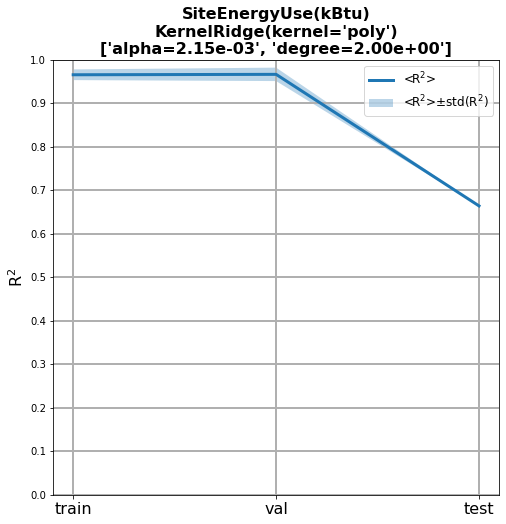

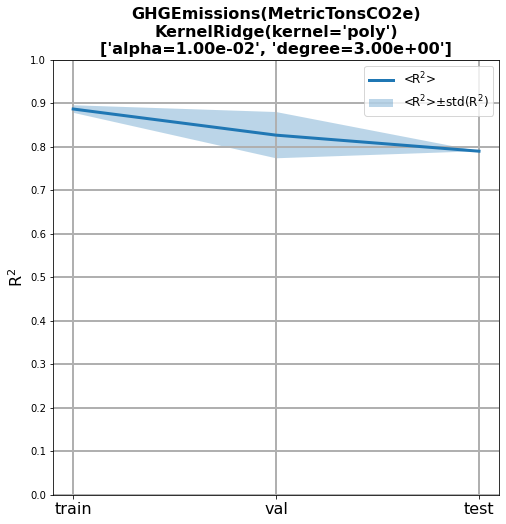

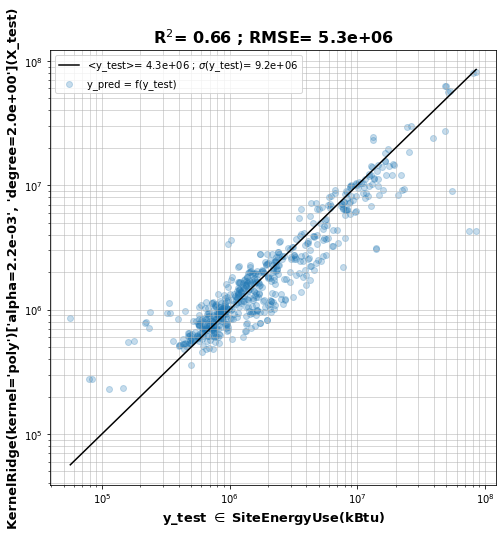

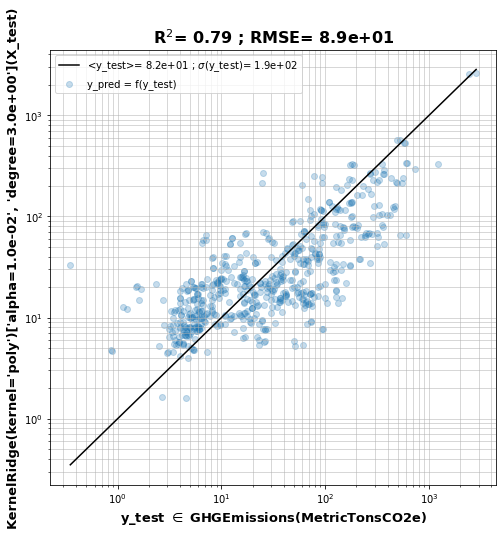

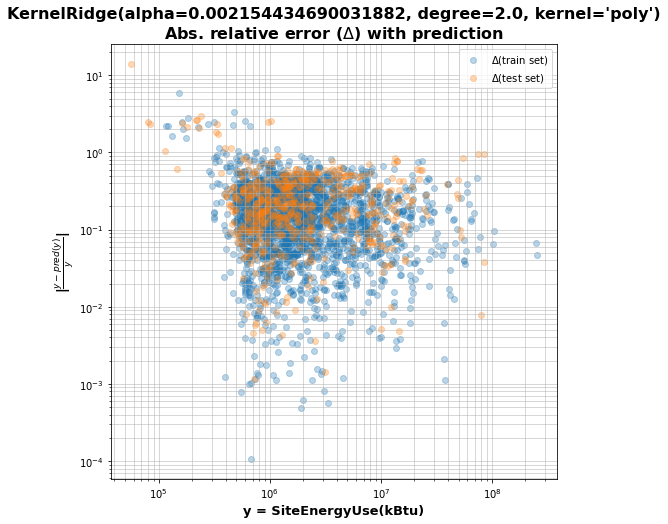

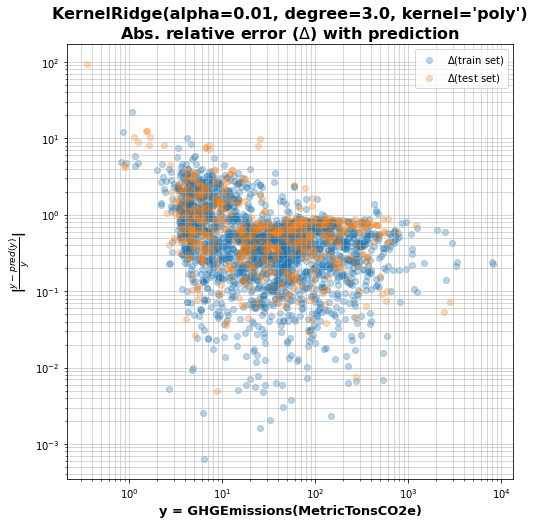

In [121]:
if Tester_EnergystarScore :
    # On redéfinit ces jeux en appliquant ces indices au jeu de données normalisées
    X_train, X_test, Y_train, Y_test = X_withESS.loc[indx_train_withESS], X_withESS.loc[indx_test_withESS], Y_scaled_op1.loc[indx_train_withESS], Y_scaled_op1.loc[indx_test_withESS]
    tab_alpha, tab_degree = np.logspace(-4,0,7), np.linspace(2,10,9)
    tab_models, tab_dict_param = [KernelRidge(kernel='poly')], [{'alpha':tab_alpha, 'degree':tab_degree}]
    tab_gridcv = gridsearchcv_plusieurs_models(tab_etiquettes, X_train, Y_train, X_test, Y_test, tab_models, tab_dict_param, 5, 5)#tab_scores_train_cv, tab_scores_val_cv, tab_scores_test_cv, tab_param_cv, 
    plot_gridsearchcv_plusieurs_models_rescaled(tab_etiquettes, tab_trans_Y, X_train, Y_train, X_test, Y_test, tab_gridcv, 'Test_noypoly_withESS', 3)
    plot_gridsearchcv_pred_f_true_rescaled(tab_etiquettes, tab_trans_Y, X_train, Y_train, X_test, Y_test, tab_gridcv, 'Test_noypoly_withESS')
    tab_delta = plot_abs_err_rel_f_true_rescaled(tab_etiquettes, tab_trans_Y, X_train, Y_train, X_test, Y_test, tab_gridcv, 'Test_noypoly_withESS')

### L'optimisation a produit une amélioration nette des performances pour <i>GHGEmission</i>, et n'a rien changé pour <i>SiteEnergyUse</i> (on peut même dire 'a dégradé', car si R²(test) est quasiment le même, il y a beaucoup plus de sur-apprentissage.
### Tenir compte de l'ESS était donc pertinent au moins pour une étiquette.